# Notebook for data analysis
## - uses dataframes from 'sensory' and 'projection' sessions (see ia_dataframe_basic.ipynb or ia_dataframe_derivative.ipynb)
## - plotting from dataframes (see ia_dataframe_basic.ipynb)

In [1]:
%run ./rob_setup_notebook.ipynb

import utils.utils_funcs as uf
import utils.gsheets_importer as gsi
import utils.ia_funcs as ia 
from utils.paq2py import *
import scipy.stats

session_type = 'sensory_2sec_test'
# 'sensory_nodetrend'
# 'sensory_highactivity'
# 'sensory_topactivity'
# 'sensory_topcells'
# 'sensory_extremefilter'
# 'sensory_responsivecells'
# 'sensory_2sec_test'
# 'projection_nodetrend'
# 'projection_2sec_test'
# 'interneuron'
# 'combined'
# 'sensory_fewtargets'

plot_lw = 3
patch_color = '0.9'

projection = True if 'projection' in session_type else False
sensory = True if 'sensory' in session_type else False
interneuron = True if 'interneuron' in session_type else False

if sensory:
    plot_colors = ['steelblue', 'darkorange', 'mediumseagreen']
    plot_labels = ['Random', 'Sensory', 'Sham']
    photostim_duration = 0.35
    patch_size = 0.4
    
if projection:
    plot_colors = ['sienna', 'mediumpurple', 'mediumseagreen']
    plot_labels = ['Non-wS2-projecting', 'wS2-projecting', 'Sham']
    photostim_duration = 0.35
    patch_size = 0.4

if interneuron:
    plot_colors = ['steelblue', 'mediumseagreen']
    plot_labels = ['Random', 'Sham']
    photostim_duration = 0.2
    patch_size = 0.3

fig_dir = os.path.join(fig_save_path, 'S1S2_mechanisms_panels', '')
fig_save_path = os.path.join(fig_save_path, 'S1S2_mechanisms_panels', session_type)

./rob_setup_notebook.ipynb:13: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  "metadata": {},


No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally

Suite2p path: ['/home/tplas/anaconda3/envs/robs/lib/python3.7/site-packages/suite2p']
qnap_path: /home/rlees/mnt/qnap 
qnap_data_path /home/rlees/mnt/qnap/Data 
pkl_folder: /home/rlees/mnt/qnap/pkl_files 
master_path: /home/rlees/mnt/qnap/master_pkl/master_obj.pkl 
fig_save_path: /home/rlees/mnt/qnap/Analysis/Figures 
stam_save_path: /home/rlees/mnt/qnap/Analysis/STA_movies 
s2_borders_path: /home/rlees/mnt/qnap/Analysis/S2_borders


# Define dataframe paths

In [2]:
session_df_path = qnap_path + '/pkl_files/dataframes/' + session_type + '_session_df.pkl'
experiment_df_path = qnap_path + '/pkl_files/dataframes/' + session_type + '_experiment_df.pkl'
trial_df_path = qnap_path + '/pkl_files/dataframes/' + session_type + '_trial_df.pkl'
cell_df_path = qnap_path + '/pkl_files/dataframes/' + session_type + '_cell_df.pkl'
cell_trial_df_path = qnap_path + '/pkl_files/dataframes/' + session_type + '_cell_trial_df.pkl'
cell_mean_timepoint_df_path = qnap_path + '/pkl_files/dataframes/' + session_type + '_cell_mean_timepoint_df.pkl'
cell_trial_single_timepoint_df_path = (qnap_path + '/pkl_files/dataframes/' + session_type + 
                                       '_cell_trial_single_timepoint_df.pkl')

# Load all dataframes

In [3]:
session_df = pd.read_pickle(session_df_path)
trial_df = pd.read_pickle(trial_df_path)
experiment_df = pd.read_pickle(experiment_df_path)
cell_trial_df = pd.read_pickle(cell_trial_df_path)
cell_df = pd.read_pickle(cell_df_path)
cell_mean_timepoint_df = pd.read_pickle(cell_mean_timepoint_df_path)
cell_trial_single_timepoint_df = pd.read_pickle(cell_trial_single_timepoint_df_path)

In [17]:
cell_df.memory_usage(index=True, deep=True).sum() / 1e6

22.45037

In [6]:
if sensory:
    remove_list = ['2020-09-15_RL102', '2020-09-09_RL100']
    for remove_id in remove_list:
        cell_df = cell_df.query('session_id != @remove_id')
        cell_mean_timepoint_df = cell_mean_timepoint_df.query('session_id != @remove_id')
        cell_trial_df = cell_trial_df.query('session_id != @remove_id')
        trial_df = trial_df.query('session_id != @remove_id')

# General analyses for all trial types

In [16]:
# # GRAND AVERAGE OF ALL CELLS (POSITIVE AND NEGATIVE)

# target_type = ['pr_target', 'ps_target', 'pr_target']
# responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

# fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(12,6))

# n_numbers = []

# n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

# for label, target, response, color in zip(plot_labels, target_type, responses, plot_colors):

#     # filter dataframes using variables above
#     s1_targets = cell_df[cell_df[target] & cell_df['s1_cell']].index
#     nontargets = cell_df[~cell_df[target] & cell_df['s2_cell']].index
    
#     # populate the plots with filtered data
#     for col, cell_id_list in enumerate([s1_targets, nontargets]):
#         df_filter = cell_mean_timepoint_df['cell_id'].isin(cell_id_list)
#         filtered_df = cell_mean_timepoint_df[df_filter].copy()
#         filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
#                     ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
#         rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]
        
#         ax = axes[col]
#         sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
#                      estimator='mean', ci=95, ax=ax, label=label, legend=False, color=color, linewidth=plot_lw)

#         display(fig)
#         clear_output(wait = True)
        
#         target_text = ['targets', 'non targets']
#         n_numbers.append(f'n = {len(cell_id_list.unique())} cells for {label} {target_text[col]}')
    
# # construct patch to cover stim artifact period
# for ax in axes:
#     stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
#     ax.add_patch(stim_patch)

# axes[0].set_title('Targeted S1 cell')
# axes[1].set_title('S2 cell')

# for ax in axes:
#     ax.set_xlabel('Time (s)')
#     ax.set_ylabel('')

# axes[0].set_ylabel('Response (ΔF/F)');
# axes[0].legend(plot_labels, loc='upper right');

# axes[0].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
# axes[1].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

# axes[0].set_ylim([-0.05, 0.3])

# if not projection:
#     axes[1].set_ylim([-0.015, 0.005])
# else:
#     axes[1].set_ylim([-0.01, 0.01])

# axes[1].set_xlim([-2, 6])

# plt.subplots_adjust(wspace=0.4)
# plt.suptitle('Grand mean cell response to photostimulation', fontsize='xx-large', y=1)

# print('N_numbers:', *n_numbers, sep='\n')

# save_path = fig_save_path + '_cell_grandaverage_dff_trace'
# ia.savePlot(save_path)

N_numbers:
n = 4 animals
n = 120 cells for Random targets
n = 136 cells for Sensory targets
n = 120 cells for Sham targets
Result for t-test comparing Random and Sensory: Ttest_indResult(statistic=3.577434216383647, pvalue=0.0004154044439448322)


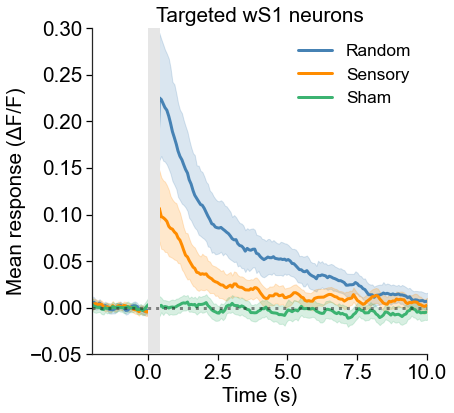

In [201]:
# GRAND AVERAGE OF TARGET CELLS (POSITIVE AND NEGATIVE)

target_type = ['pr_target', 'ps_target', 'pr_target']
responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, figsize=(6,6))

n_numbers = []

n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

for label, target, response, color in zip(plot_labels, target_type, responses, plot_colors):

    # filter dataframes using variables above
    s1_targets = cell_df[cell_df[target] & cell_df['s1_cell']].index
    
    # populate the plots with filtered data
    df_filter = cell_mean_timepoint_df['cell_id'].isin(s1_targets)
    filtered_df = cell_mean_timepoint_df[df_filter].copy()
    filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
                ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
    rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]

    sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
                 estimator='mean', ci=95, ax=ax, label=label, legend=False, color=color, linewidth=plot_lw)

    display(fig)
    clear_output(wait = True)

    n_numbers.append(f'n = {len(s1_targets.unique())} cells for {label} targets')
    
# construct patch to cover stim artifact period
stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
ax.add_patch(stim_patch)

ax.set_xlabel('Time (s)')
ax.set_ylabel('')

ax.set_ylabel('Mean response (ΔF/F)', fontname='Arial');
ax.legend(plot_labels, loc='upper right');

ax.hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

ax.set_ylim([-0.05, 0.3])

ax.set_xlim([-2, 10])

ax.set_title('Targeted wS1 neurons', fontsize='xx-large', y=1)

ax.legend().draw_frame(False)

print('N_numbers:', *n_numbers, sep='\n')

save_path = fig_save_path + '_cell_grandaverage_target_dff_trace'
ia.savePlot(save_path)

pr_avg = cell_df.query('pr_target').pr_sta_amp_resp
ps_avg = cell_df.query('ps_target').ps_sta_amp_resp
print(f'Result for t-test comparing {plot_labels[0]} and {plot_labels[1]}: {stats.ttest_ind(pr_avg, ps_avg)}')

In [ ]:
# Plotting average for each animal and then getting error of that

# temp_grouped_df = filtered_df.groupby(['session_id', 'timepoint']).mean()
# rolling_mean = temp_grouped_df.groupby(['session_id', 'timepoint']).rolling(5, min_periods=1).mean()

# plt.figure(figsize=(6,6))

# for label, target, response, color in zip(plot_labels, target_type, responses, plot_colors):
#     sns.lineplot(data=rolling_mean, x='timepoint', y=response, 
#                  estimator='mean', ci=95, legend=False, color=color, linewidth=plot_lw)

# plt.xlim([-2, 6]);

N_numbers:
n = 8 animals
n = 4633 cells for Random non targets
n = 4633 cells for Sensory non targets
n = 4633 cells for Sham non targets


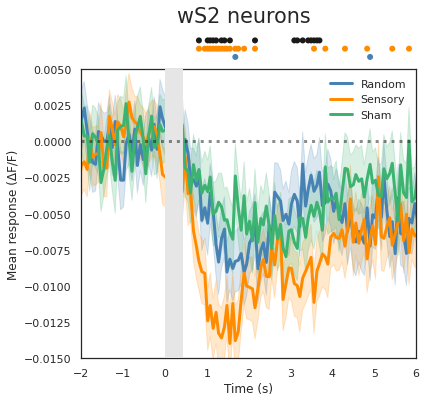

In [4]:
# GRAND AVERAGE OF ALL CELLS (POSITIVE AND NEGATIVE)

target_type = ['pr_target', 'ps_target', 'pr_target']
responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,6), gridspec_kw={'height_ratios': [2,20]})

n_numbers = []

n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

for label, target, response, color in zip(plot_labels, target_type, responses, plot_colors):

    # filter dataframes using variables above
#     trial_type = response.split('_')[0]
#     nontargets = cell_df[~cell_df[target] & cell_df[f'{trial_type}_resp_sign'] & cell_df['s2_cell']].index
    nontargets = cell_df[~cell_df[target] & cell_df['s2_cell']].index
    
    # populate the plots with filtered data
    df_filter = cell_mean_timepoint_df['cell_id'].isin(nontargets)
    filtered_df = cell_mean_timepoint_df[df_filter].copy()
    filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
                ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
    rolling_mean = filtered_df.groupby('cell_id').rolling(1, min_periods=1).mean()[response]
    
    sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
                 estimator='mean', ci=95, ax=ax[1], label=label, legend=False, color=color, linewidth=plot_lw)
    
    display(fig)
    clear_output(wait = True)

    n_numbers.append(f'n = {len(nontargets.unique())} cells for {label} non targets')
    
# construct patch to cover stim artifact period
stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
ax[1].add_patch(stim_patch)

ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Mean response (ΔF/F)');
if sensory:
    ax[1].legend(plot_labels, loc='lower right')
else: 
    ax[1].legend(plot_labels, loc='upper right')
    
ax[1].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

if not projection:
    ax[1].set_ylim([-0.015, 0.005])
#     ax[1].set_ylim([-0.015, 0.025]) # positive responses
#     ax[1].set_ylim([-0.03, 0.005]) # negative responses
else:
    ax[1].set_ylim([-0.01, 0.01])
#     ax[1].set_ylim([-0.05, 0.01])
#     ax[1].set_ylim([-0.01, 0.05])

ax[1].set_xlim([-2, 6])

#plot stats
nontargets = cell_df[(~cell_df['ps_target'] | ~cell_df['pr_target']) & cell_df['s2_cell']].index
df_filter = cell_mean_timepoint_df['cell_id'].isin(nontargets)
temp_df = cell_mean_timepoint_df[df_filter].copy()
temp_df.loc[(temp_df['timepoint'] > -3) & (temp_df['timepoint'] <= photostim_duration), 
            ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
time_array = temp_df['timepoint'].unique()

for tt_i, (col_1, col_2, color) in enumerate(zip(['pr_sta_resp', 'ps_sta_resp', 'pr_sta_resp'],
                                                 ['spont_sta_resp', 'spont_sta_resp', 'ps_sta_resp'],
                                                 [plot_colors[0], plot_colors[1], 'k'])):
    signif_array = ia.stat_test_timepoint(temp_df, time_array, col_1=col_1, col_2=col_2, 
                                       frames_bin=1, th=0.05)
    signif_array[(time_array > -3) & (time_array <= patch_size + 0.05)] = np.nan
    sns.scatterplot(x=time_array, y=[tt_i * 0.02 if x_val==1 else np.nan for x_val in signif_array], 
                    ax=ax[0], color=color, edgecolor='none', lw=0, legend=False)
    clear_output(wait=True)
        
ax[0].set_ylim([-0.01, 0.02*3])
ax[0].axis('off')
plt.subplots_adjust(hspace=0.05)

plt.suptitle('wS2 neurons', fontsize='xx-large', y=0.94)

ax[1].legend().draw_frame(False)

print('N_numbers:', *n_numbers, sep='\n')

save_path = fig_save_path + '_cell_grandaverage_s2_dff_trace'
ia.savePlot(save_path)

Text(0.5, 1.0, 'WSR P = 7.8e-66, t-test P = 1.5e-51')

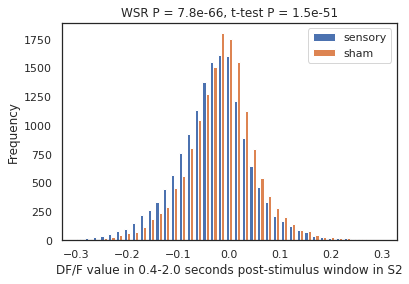

In [27]:
start_window = 0.4
end_window = 2.0
one_session_only = True
sess_index = -2

distr_df = temp_df[np.logical_and(temp_df['timepoint'] >= start_window, temp_df['timepoint'] <= end_window)]
if one_session_only:
    list_sessions = temp_df.session_id.unique()
    sess_id = list_sessions[sess_index]
    distr_df = distr_df[distr_df['session_id'] == sess_id]

_ = plt.hist([distr_df['ps_sta_resp'], distr_df['spont_sta_resp']], bins=np.linspace(-0.3, 0.3, 40),
             label=['sensory', 'sham'])
wilcox = scipy.stats.wilcoxon(x=distr_df['ps_sta_resp'], y=distr_df['spont_sta_resp'], alternative='two-sided')
ttest = scipy.stats.ttest_ind(a=distr_df['ps_sta_resp'], b=distr_df['spont_sta_resp'], alternative='two-sided')
plt.xlabel(f'DF/F value in {start_window}-{end_window} seconds post-stimulus window in S2')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'WSR P = {np.format_float_scientific(wilcox[1], precision=1)}, t-test P = {np.format_float_scientific(ttest[1], precision=1)}')


In [39]:
start_window = 0.4
end_window = 2

distr_df = temp_df[np.logical_and(temp_df['timepoint'] >= start_window, temp_df['timepoint'] <= end_window)]
list_sessions = temp_df.session_id.unique()
p_val_dict = {'session_id': np.zeros(len(list_sessions), dtype='object')}

dict_tt_response = {'sensory': 'ps_sta_resp', 'random': 'pr_sta_resp'}
for tt_type, tt_response in dict_tt_response.items():
    p_val_dict[tt_type] = np.zeros(len(list_sessions)) 
    
for sess_index, sess_id in enumerate(list_sessions):
    curr_distr_df = distr_df[distr_df['session_id'] == sess_id]
    p_val_dict['session_id'][sess_index] = sess_id
    for tt_type, tt_response in dict_tt_response.items():
        wilcox = scipy.stats.wilcoxon(x=curr_distr_df[tt_response], y=curr_distr_df['spont_sta_resp'], alternative='two-sided')
        # ttest = scipy.stats.ttest_ind(a=curr_distr_df[tt_response], b=curr_distr_df['spont_sta_resp'], alternative='two-sided')
        p_val_dict[tt_type][sess_index] = wilcox[1]
        # p_val_dict[tt_response][sess_index] = ttest[1]

print(f'P values WSR, difference between stimulated and sham trials')
print(f'All data points considered in time window {start_window}-{end_window}')
pd.DataFrame(p_val_dict)


P values WSR, difference between stimulated and sham trials
All data points considered in time window 0.4-2


session_id       sensory         random
0  2020-10-02_RL108  5.402044e-01   7.465691e-01
1  2020-09-09_RL100  5.473286e-03   2.236233e-03
2  2020-09-16_RL103  3.664428e-29  2.313808e-105
3  2020-10-12_RL109  3.203221e-18   4.559655e-05
4  2020-09-04_RL093  3.052510e-47   1.066587e-03
5  2020-09-14_RL101  9.706263e-01   4.539114e-04
6  2020-09-15_RL102  7.806220e-66   8.445292e-36
7  2020-09-08_RL099  1.944199e-02   2.828967e-01

In [95]:
# trials = ['pr', 'ps', 'spont']
# targets = ['pr', 'ps', 'pr']

# df = pd.DataFrame()

# for i, (trial, target, color, label) in enumerate(zip(trials, targets, plot_colors, plot_labels)):
    
#     non_target_df = cell_df.query('~' + target + '_target & s2_cell')
#     bias = non_target_df[trial + '_avg_norm_influence']
    
#     temp_df = pd.DataFrame({'Trial type' : np.repeat(label, len(bias)),
#                             'bias' : bias
#                            })
    
#     df = pd.concat([df, temp_df])

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), gridspec_kw={'width_ratios':(5,2)})

# sns.barplot(x='Trial type', y='bias', data=df, ci=95, ax=ax[1], palette=sns.color_palette(plot_colors));
# ax[1].set_ylabel('ΔActivity')
# ax[1].set_xlabel('Trial type')
# ax[1].hlines(0, -0.5, 2.5, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
# ax[1].set_title('Mean')

# # sns.kdeplot(cumulative=True, hue='Trial type', x='bias', data=df, ax=ax[1])
# sns.histplot(hue='Trial type', x='bias', cumulative=True, fill=False, linewidth=plot_lw,
#              element='poly', data=df, ax=ax[0], palette=sns.color_palette(plot_colors))
# ax[0].set_xlim([-0.1, 0.1])
# ax[0].set_xlabel('ΔActivity')
# ax[0].set_ylabel('Count of cells')
# ax[0].set_title('Distribution')

# ax1_labels = [item.get_text() for item in ax[1].get_xticklabels()]
# ax1_labels = ['','', '']

# ax[1].set_xticklabels(ax1_labels)

# plt.subplots_adjust(wspace=0.4)
# plt.suptitle('Change in activity of S2 cells', y=0.99, fontsize='xx-large');

# group1 = df[df['Trial type']==plot_labels[0]]['bias'].to_numpy()
# group2 = df[df['Trial type']==plot_labels[1]]['bias'].to_numpy()
# group3 = df[df['Trial type']==plot_labels[2]]['bias'].to_numpy()

# print(f'{plot_labels[0]}, {plot_labels[2]}', stats.mannwhitneyu(group1, group3))
# print(f'{plot_labels[1]}, {plot_labels[2]}', stats.mannwhitneyu(group2, group3))
# print(f'{plot_labels[0]}, {plot_labels[1]}', stats.mannwhitneyu(group1, group2))

# # save the figure
# save_path = fig_save_path + '_deltaactivity_bias_histogram_barplot'
# ia.savePlot(save_path)

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator


Random, Sham MannwhitneyuResult(statistic=5328388.0, pvalue=4.847272795231292e-05)
Sensory, Sham MannwhitneyuResult(statistic=5149958.0, pvalue=4.0231672141721654e-10)
Random, Sensory MannwhitneyuResult(statistic=5445731.0, pvalue=0.007736471956873148)


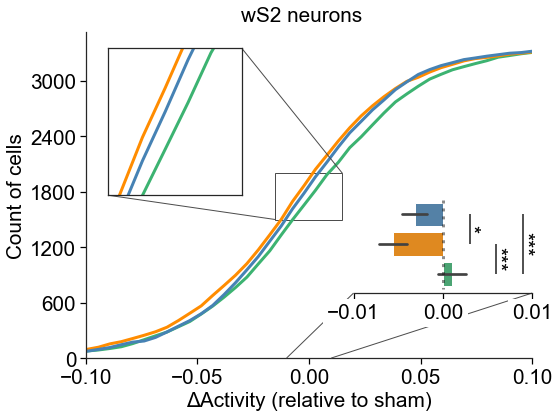

In [162]:
trials = ['pr', 'ps', 'spont']
targets = ['pr', 'ps', 'pr']

df = pd.DataFrame()

for i, (trial, target, color, label) in enumerate(zip(trials, targets, plot_colors, plot_labels)):
    
    non_target_df = cell_df.query('~' + target + '_target & s2_cell')
    bias = non_target_df[trial + '_avg_norm_influence']
    
    temp_df = pd.DataFrame({'Trial type' : np.repeat(label, len(bias)),
                            'bias' : bias
                           })
    
    df = pd.concat([df, temp_df])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

# HISTOGRAM
# sns.kdeplot(cumulative=True, hue='Trial type', x='bias', data=df, ax=ax[1])
sns.histplot(hue='Trial type', x='bias', cumulative=True, fill=False, linewidth=plot_lw, legend=False,
             element='poly', data=df, ax=ax, palette=sns.color_palette(plot_colors))
ax.set_xlim([-0.1, 0.1])
ax.set_ylabel('Count of cells')
ax.set_xlabel('ΔActivity (relative to sham)')
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

# HISTOGRAM ZOOM
inset_ax = plt.axes([0,1,1,1])
ip = InsetPosition(ax, [0.05,0.50,0.3,0.45])
inset_ax.set_axes_locator(ip)

mark_inset(ax, inset_ax, loc1=3, loc2=1, fc="none", ec='0.3')

sns.histplot(hue='Trial type', x='bias', cumulative=True, fill=False, legend=False, linewidth=plot_lw,
             element='poly', data=df, ax=inset_ax, palette=sns.color_palette(plot_colors))
if sensory: inset_ax.axis([-0.015, 0.015, 1500, 2000])
if projection: inset_ax.axis([-0.01, 0.02, 1500, 2000])
inset_ax.set_xlabel('')
inset_ax.set_ylabel('')
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.spines['right'].set_visible(True)
inset_ax.spines['top'].set_visible(True)

# BAR PLOT
plt.sca(ax)
inset_bar_ax = plt.axes([0,0,1,1])
ip = InsetPosition(ax, [0.6,0.2,0.4,0.3])
inset_bar_ax.set_axes_locator(ip)

sns.barplot(y='Trial type', x='bias', data=df, ci=95, ax=inset_bar_ax, palette=sns.color_palette(plot_colors));
inset_bar_ax.vlines(0, -0.5, 2.5, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
inset_bar_ax.set_xlim([-0.01, 0.01])
inset_bar_ax.set_ylabel('')

inset_bar_ax.spines['left'].set_visible(False)
inset_bar_ax.set_yticks([])
inset_bar_ax.set_xlabel('')
inset_bar_ax.patch.set_alpha(0)

fig.canvas.draw()

ax_labels = [item.get_text() for item in inset_bar_ax.get_xticklabels()]
inset_bar_ax.set_xticklabels(ax_labels, backgroundcolor='w')

mark_inset(ax, inset_bar_ax, loc1=3, loc2=4, fc="none", ec='0.3', zorder=-1)

plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.5)
plt.suptitle('wS2 neurons', y=0.94, fontsize='xx-large');

group1 = df[df['Trial type']==plot_labels[0]]['bias'].to_numpy()
group2 = df[df['Trial type']==plot_labels[1]]['bias'].to_numpy()
group3 = df[df['Trial type']==plot_labels[2]]['bias'].to_numpy()

print(f'{plot_labels[0]}, {plot_labels[2]}', stats.mannwhitneyu(group1, group3))
print(f'{plot_labels[1]}, {plot_labels[2]}', stats.mannwhitneyu(group2, group3))
print(f'{plot_labels[0]}, {plot_labels[1]}', stats.mannwhitneyu(group1, group2))

if sensory:
    inset_bar_ax.vlines(0.003, 0, 1, color='k')
    inset_bar_ax.text(0.002, 0.45, '*', fontsize='xx-large', rotation=-90)
    inset_bar_ax.vlines(0.006, 1, 2, color='k')
    inset_bar_ax.text(0.005, 1.75, '***', fontsize='xx-large', rotation=-90)
    inset_bar_ax.vlines(0.009, 0, 2, color='k')
    inset_bar_ax.text(0.008, 1.25, '***', fontsize='xx-large', rotation=-90)
if projection:
    inset_bar_ax.vlines(-0.004, 0, 1, color='k')
    inset_bar_ax.text(-0.007, 0.6, '**', fontsize='xx-large', rotation=-90)
    inset_bar_ax.vlines(0.006, 1, 2, color='k')
    inset_bar_ax.text(0.006, 1.9, 'n.s.', fontsize='x-large', rotation=-90)
    inset_bar_ax.vlines(0.009, 0, 2, color='k')
    inset_bar_ax.text(0.008, 1, '*', fontsize='xx-large', rotation=-90)

# save the figure
save_path = fig_save_path + '_deltaactivity_bias_histogram_barplot_rotated'
ia.savePlot(save_path)

In [97]:
# trials = ['pr', 'ps', 'spont']
# targets = ['pr', 'ps', 'pr']

# df = pd.DataFrame()

# for i, (trial, target, label) in enumerate(zip(trials, targets, plot_labels)):
    
#     non_target_df = cell_df.query('~' + target + '_target & s2_cell')
#     influence = non_target_df[trial + '_avg_norm_influence']
    
#     temp_df = pd.DataFrame({'Trial type' : np.repeat(label, len(influence)),
#                             'influence' : np.absolute(influence)
#                            })
    
#     df = pd.concat([df, temp_df])

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), gridspec_kw={'width_ratios':(5, 2)})

# sns.barplot(x='Trial type', y='influence', data=df, ci=95, ax=ax[1], palette=sns.color_palette(plot_colors));
# ax[1].set_ylabel('|ΔActivity|')
# ax[1].set_ylim([0.03, 0.04])
# ax[1].set_title('Mean')

# # sns.kdeplot(cumulative=True, hue='Trial type', x='influence', data=df, cut=0, ax=ax[1])
# sns.histplot(x='influence', element='poly', hue='Trial type', cumulative=True, fill=False,
#              linewidth=plot_lw, data=df, ax=ax[0], palette=sns.color_palette(plot_colors))
# ax[0].set_xlabel('|ΔActivity|')
# ax[0].set_ylabel('Count of cells')
# ax[0].set_xlim(0, 0.1)
# ax[0].set_title('Distribution')

# ax1_labels = [item.get_text() for item in ax[1].get_xticklabels()]
# ax1_labels = ['','', '']

# ax[1].set_xticklabels(ax1_labels)

# plt.suptitle('Absolute change in activity of S2 cells', y=0.99, fontsize='xx-large');
# plt.subplots_adjust(wspace=0.4)

# group1 = df[df['Trial type']==plot_labels[0]]['influence'].to_numpy()
# group2 = df[df['Trial type']==plot_labels[1]]['influence'].to_numpy()
# group3 = df[df['Trial type']==plot_labels[2]]['influence'].to_numpy()

# print(f'{plot_labels[0]}, {plot_labels[2]}', stats.mannwhitneyu(group1, group3))
# print(f'{plot_labels[1]}, {plot_labels[2]}', stats.mannwhitneyu(group2, group3))
# print(f'{plot_labels[0]}, {plot_labels[1]}', stats.mannwhitneyu(group1, group2))

# # save the figure
# save_path = fig_save_path + '_deltaactivity_magnitude_histogram_barplot'
# ia.savePlot(save_path)

In [98]:
# # GRAND AVERAGE OF ALL CELLS (POSITIVE AND NEGATIVE)

# target_type = ['pr_target', 'ps_target', 'pr_target']
# responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

# fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(12,6))

# n_numbers = []

# n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

# for label, target, response, color in zip(plot_labels, target_type, responses, plot_colors):

#     # filter dataframes using variables above
#     s1_targets = cell_df[cell_df[target] & cell_df['s1_cell']].index
#     s2_nontargets = cell_df[~cell_df[target] & cell_df['s1_cell']].index
    
#     # populate the plots with filtered data
#     for col, cell_id_list in enumerate([s1_targets, s2_nontargets]):
#         df_filter = cell_mean_timepoint_df['cell_id'].isin(cell_id_list)
#         filtered_df = cell_mean_timepoint_df[df_filter].copy()
#         filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
#                 ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
#         rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]
    
#         ax = axes[col]
#         sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
#                      estimator='mean', ci=95, ax=ax, label=label, legend=False, color=color, linewidth=plot_lw)

#         display(fig)
#         clear_output(wait = True)
        
#         target_text = ['targets', 'non targets']
#         n_numbers.append(f'n = {len(cell_id_list.unique())} cells for {label} {target_text[col]}')
    
# # construct patch to cover stim artifact period
# for ax in axes:
#     stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
#     ax.add_patch(stim_patch)

# axes[0].set_title('Targeted S1 cell')
# axes[1].set_title('Non-targeted S1 cell')

# for ax in axes:
#     ax.set_xlabel('Time (s)')
#     ax.set_ylabel('')

# axes[0].set_ylabel('Mean response (ΔF/F)');
# axes[0].legend(plot_labels, loc='upper right');

# axes[0].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
# axes[1].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

# if not projection:
#     axes[0].set_ylim([-0.05, 0.3])
#     axes[1].set_ylim([-0.01, 0.005])
# else:
#     axes[0].set_ylim([-0.05, 0.3])
#     axes[1].set_ylim([-0.01, 0.005])

# axes[1].set_xlim([-2, 6])

# plt.subplots_adjust(wspace=0.4)
# plt.suptitle('Grand mean cell response to photostimulation', fontsize='xx-large', y=1)

# print('N_numbers:', *n_numbers, sep='\n')

# save_path = fig_save_path + '_cell_grandaverage_target_s1nt_dff_trace'
# ia.savePlot(save_path)

N_numbers:
n = 6 animals
n = 6225 cells for Random non targets
n = 6195 cells for Sensory non targets
n = 6225 cells for Sham non targets


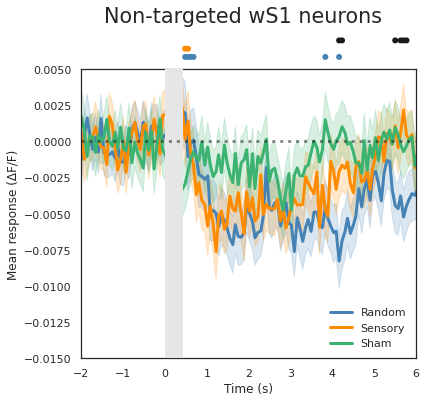

In [90]:
# GRAND AVERAGE OF S1NT CELLS (POSITIVE AND NEGATIVE)

target_type = ['pr_target', 'ps_target', 'pr_target']
responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,6), gridspec_kw={'height_ratios': [2,20]})

n_numbers = []

n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

for label, target, response, color in zip(plot_labels, target_type, responses, plot_colors):

    # filter dataframes using variables above
    nontargets = cell_df[~cell_df[target] & cell_df['s1_cell']].index
    
    # populate the plots with filtered data
    df_filter = cell_mean_timepoint_df['cell_id'].isin(nontargets)
    filtered_df = cell_mean_timepoint_df[df_filter].copy()
    filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
                ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
    # rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]  # see rolling doc; not exactly right
    rolling_mean = filtered_df.groupby('cell_id').rolling(1).mean()[response]
    sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
                 estimator='mean', ci=95, ax=ax[1], label=label, legend=False, color=color, linewidth=plot_lw)

    display(fig)
    clear_output(wait = True)

    n_numbers.append(f'n = {len(nontargets.unique())} cells for {label} non targets')
    
# construct patch to cover stim artifact period
stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
ax[1].add_patch(stim_patch)

ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Mean response (ΔF/F)');
if sensory:
    ax[1].legend(plot_labels, loc='lower right');
else:
    ax[1].legend(plot_labels, loc='upper right');

ax[1].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

if not projection:
    ax[1].set_ylim([-0.015, 0.005])
else:
    ax[1].set_ylim([-0.01, 0.0075])

ax[1].set_xlim([-2, 6])

#plot stats
nontargets = cell_df[(~cell_df['ps_target'] | ~cell_df['pr_target']) & cell_df['s1_cell']].index
df_filter = cell_mean_timepoint_df['cell_id'].isin(nontargets)
temp_df = cell_mean_timepoint_df[df_filter].copy()
temp_df.loc[(temp_df['timepoint'] > -3) & (temp_df['timepoint'] <= photostim_duration), 
            ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
# rolling_mean = temp_df.groupby('cell_id').rolling(5, min_periods=1).mean()
rolling_mean = temp_df.groupby('cell_id').rolling(1, min_periods=1).mean()
# time_array = cell_mean_timepoint_df['timepoint'].unique()
time_array = rolling_mean['timepoint'].unique()

for tt_i, (col_1, col_2, color) in enumerate(zip(['pr_sta_resp', 'ps_sta_resp', 'pr_sta_resp'],
                                                 ['spont_sta_resp', 'spont_sta_resp', 'ps_sta_resp'],
                                                 [plot_colors[0], plot_colors[1], 'k'])):
#     signif_array = ia.stat_test_timepoint(temp_df, time_array, col_1=col_1, col_2=col_2, 
#                                        frames_bin=4, th=0.05).
    signif_array = ia.stat_test_timepoint(rolling_mean, time_array, col_1=col_1, col_2=col_2, 
                                       frames_bin=1, th=0.05)
    signif_array[(time_array > -3) & (time_array <= patch_size + 0.05)] = np.nan
    sns.scatterplot(x=time_array, y=[tt_i * 0.02 if x_val==1 else np.nan for x_val in signif_array], 
                    ax=ax[0], color=color, edgecolor='none', lw=0, legend=False)
    clear_output(wait=True)
        
ax[0].set_ylim([-0.01, 0.02*3])
ax[0].axis('off')
plt.subplots_adjust(hspace=0.05)

ax[1].legend().draw_frame(False)

plt.suptitle('Non-targeted wS1 neurons', fontsize='xx-large', y=0.94)

print('N_numbers:', *n_numbers, sep='\n')

save_path = fig_save_path + '_cell_grandaverage_s1nt_dff_trace'
ia.savePlot(save_path)

In [100]:
# # GRAND AVERAGE FOR CELLS PASSING STATISTICAL TEST

# test_type = 'fdr'
# if test_type == 'fdr':
#     stat_test = ['sta_sig_pr', 'sta_sig_ps', 'sta_sig_spont']
# if test_type == 'nomulti':
#     stat_test = ['sta_sig_nomulti_pr', 'sta_sig_nomulti_ps', 'sta_sig_nomulti_spont']
# target_type = ['pr_target', 'ps_target', 'pr_target']
# responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

# fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12,6))

# n_numbers = []

# n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

# for test, label, target, response, color in zip(stat_test, plot_labels, target_type, responses, plot_colors):

#     # filter dataframes using variables above
#     s1_targets = cell_df[cell_df[test] & cell_df[target] & cell_df['s1_cell']].index
#     s2_nontargets = cell_df[cell_df[test] & ~cell_df[target] & cell_df['s2_cell']].index
    
#     # populate the plots with filtered data
#     for col, cell_id_list in enumerate([s1_targets, s2_nontargets]):
#         df_filter = cell_mean_timepoint_df['cell_id'].isin(cell_id_list)
#         filtered_df = cell_mean_timepoint_df[df_filter].copy()
#         filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
#                 ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
#         rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]
    
#         ax = axes[col]
#         sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
#                      estimator='mean', ci=95, ax=ax, label=label, legend=False, color=color, linewidth=plot_lw)

#         display(fig)
#         clear_output(wait = True)
        
#         n_numbers.append(f'n = {len(cell_id_list.unique())} cells for {label} {target_text[col]}')

# axes[0].set_title('Targeted S1 cell')
# axes[1].set_title('S2 cell')

# # construct patch to cover stim artifact period
# for ax in axes:
#     stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
#     ax.add_patch(stim_patch)
    
# for ax in axes:
#     ax.set_xlabel('Time (s)')
#     ax.set_ylabel('')

# axes[0].set_ylabel('Mean response (ΔF/F)');
# axes[0].legend(plot_labels, loc='upper right');

# axes[0].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
# axes[1].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

# if not projection:
#     axes[0].set_ylim([-0.15, 0.45])
#     axes[1].set_ylim([-0.15, 0.15])
# else:
#     axes[0].set_ylim([-0.15, 0.45])
#     axes[1].set_ylim([-0.25, 0.2])

# axes[1].set_xlim([-2, 6])

# plt.subplots_adjust(wspace=0.4)
# plt.suptitle('Grand mean cell response to photostimulation (significant cells only)', fontsize='xx-large', y=1)
    
# save_path = fig_save_path + '_cell_grandaverage_dff_trace_FDR'
# ia.savePlot(save_path)

# print('N_numbers:', *n_numbers, sep='\n')

In [101]:
# # GRAND AVERAGE FOR CELLS PASSING STATISTICAL TEST

# test_type = 'fdr'
# if test_type == 'fdr':
#     stat_test = ['sta_sig_pr', 'sta_sig_ps', 'sta_sig_spont']
# if test_type == 'nomulti':
#     stat_test = ['sta_sig_nomulti_pr', 'sta_sig_nomulti_ps', 'sta_sig_nomulti_spont']
# target_type = ['pr_target', 'ps_target', 'pr_target']
# responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

# fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(6,6))

# n_numbers = []

# n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

# for test, label, target, response, color in zip(stat_test, plot_labels, target_type, responses, plot_colors):

#     # filter dataframes using variables above
#     s2_nontargets = cell_df[cell_df[test] & ~cell_df[target] & cell_df['s2_cell']].index
    
#     # populate the plots with filtered data
#     for col, cell_id_list in enumerate([s2_nontargets]):
#         df_filter = cell_mean_timepoint_df['cell_id'].isin(cell_id_list)
#         filtered_df = cell_mean_timepoint_df[df_filter].copy()
#         filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
#                 ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
#         rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]
    
#         sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
#                      estimator='mean', ci=95, ax=axes, label=label, legend=False, color=color, linewidth=plot_lw)

#         display(fig)
#         clear_output(wait = True)
        
# #         n_numbers.append(f'n = {len(cell_id_list.unique())} cells for {label} {target_text[col]}')

# # construct patch to cover stim artifact period
# stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
# axes.add_patch(stim_patch)
    
# axes.set_xlabel('Time (s)')
# axes.set_ylabel('')

# axes.set_ylabel('Mean response (ΔF/F)');
# axes.legend(plot_labels, loc='upper right');

# axes.hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

# if not projection:
#     axes.set_ylim([-0.15, 0.15])
# else:
#     axes.set_ylim([-0.25, 0.2])

# axes.set_xlim([-2, 6])

# plt.subplots_adjust(wspace=0.4)
# plt.suptitle('Grand mean wS2 neuron response to \nphotostimulation (significant neurons only)', fontsize='xx-large', y=1)
    
# save_path = fig_save_path + '_cell_grandaverage_s2_dff_trace_FDR'
# ia.savePlot(save_path)

# print('N_numbers:', *n_numbers, sep='\n')

### Plot BH alpha vs. cells responding (use cross-fold validation over 50 random trials)

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator


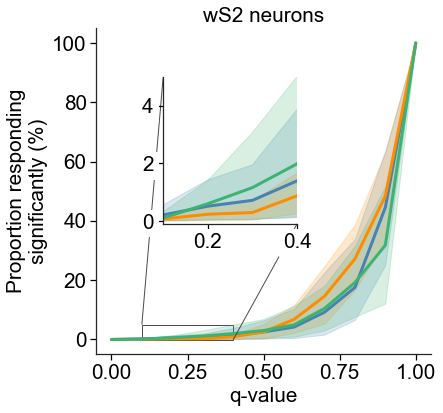

In [164]:
# Analysis for FDR correction at different alpha levels

s2_cell_df = cell_df.query('s2_cell')

bh_alpha_df = pd.DataFrame()
bh_alpha_iter = np.linspace(0, 1, 11)

fig, ax = plt.subplots(1,1, figsize=(6,6))

for name, session_s2_cell_df in s2_cell_df.groupby('session_id'):
    
#     session_s2_cell_df = session_s2_cell_df.query('~(pr_target | ps_target)')
    num_s2_cells = len(session_s2_cell_df)
    
    p_val_list = ['wilcoxons_pr',
                  'wilcoxons_ps',
                  'wilcoxons_spont'
                 ]
    
    for p_vals, trial_type in zip(p_val_list, plot_labels):
        
        pct_sig_s2 = []
        
        for alpha in bh_alpha_iter:

            bh_sig_s2, _, _, _ = smstats.multitest.multipletests(session_s2_cell_df[p_vals], alpha=alpha, 
                                                                 method='fdr_bh', is_sorted=False, 
                                                                 returnsorted=False)

            pct_sig_s2.append(np.sum(bh_sig_s2)/num_s2_cells * 100)
            
        temp_df = pd.DataFrame({'session' : np.repeat(name, len(pct_sig_s2)),
                                'trial_type' : np.repeat(trial_type, len(pct_sig_s2)),
                                'pct_sig_s2': pct_sig_s2,
                                'bh_alpha' : bh_alpha_iter
                                })
        
        bh_alpha_df = pd.concat([bh_alpha_df, temp_df])
    
sns.lineplot(data=bh_alpha_df, x='bh_alpha', y='pct_sig_s2', hue='trial_type', 
             palette=sns.color_palette(plot_colors), ax=ax, ci=95, estimator='mean', 
             lw=plot_lw, legend=False);

plt.title('wS2 neurons')
plt.xlabel('q-value')
plt.ylabel('Proportion responding\nsignificantly (%)');

inset_ax = plt.axes([0,0,1,1])
ip = InsetPosition(ax, [0.2,0.4,0.4,0.45])
inset_ax.set_axes_locator(ip)

sns.lineplot(data=bh_alpha_df, x='bh_alpha', y='pct_sig_s2', hue='trial_type', 
             palette=sns.color_palette(plot_colors), ax=inset_ax, ci=95, estimator='mean', 
             lw=plot_lw, legend=False);

inset_ax.axis([0.1, 0.4, -0.1, 5])
inset_ax.set_xlabel('')
inset_ax.set_ylabel('')

mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec='0.3', zorder=-1)

fig.canvas.draw()

ax_labels = [item.get_text() for item in inset_ax.get_xticklabels()]
inset_ax.set_xticklabels(ax_labels, backgroundcolor='w')

ax_labels = [item.get_text() for item in inset_ax.get_yticklabels()]
inset_ax.set_yticklabels(ax_labels, backgroundcolor='w');

# save the figure
save_path = fig_save_path + '_alphathreshold_vs_cellspassing_BH_FDR_s2'
ia.savePlot(save_path)

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator


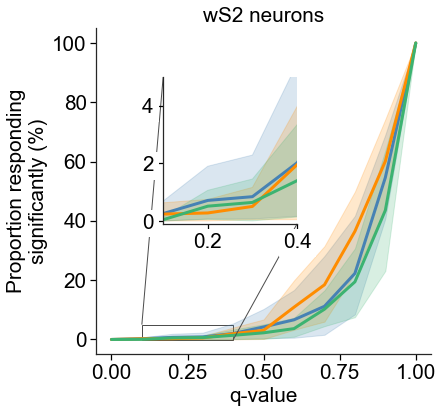

In [103]:
# Analysis for FDR correction at different alpha levels

s2_cell_df = cell_df.query('s2_cell & (~pr_resp_sign | ~ps_resp_sign)')

bh_alpha_df = pd.DataFrame()
bh_alpha_iter = np.linspace(0, 1, 11)

fig, ax = plt.subplots(1,1, figsize=(6,6))

for name, session_s2_cell_df in s2_cell_df.groupby('session_id'):
    
#     session_s2_cell_df = session_s2_cell_df.query('~(pr_target | ps_target)')
    num_s2_cells = len(session_s2_cell_df)
    
    p_val_list = ['wilcoxons_pr',
                  'wilcoxons_ps',
                  'wilcoxons_spont'
                 ]
    
    for p_vals, trial_type in zip(p_val_list, plot_labels):
        
        pct_sig_s2 = []
        
        for alpha in bh_alpha_iter:

            bh_sig_s2, _, _, _ = smstats.multitest.multipletests(session_s2_cell_df[p_vals], alpha=alpha, 
                                                                 method='fdr_bh', is_sorted=False, 
                                                                 returnsorted=False)

            pct_sig_s2.append(np.sum(bh_sig_s2)/num_s2_cells * 100)
            
        temp_df = pd.DataFrame({'session' : np.repeat(name, len(pct_sig_s2)),
                                'trial_type' : np.repeat(trial_type, len(pct_sig_s2)),
                                'pct_sig_s2': pct_sig_s2,
                                'bh_alpha' : bh_alpha_iter
                                })
        
        bh_alpha_df = pd.concat([bh_alpha_df, temp_df])
    
sns.lineplot(data=bh_alpha_df, x='bh_alpha', y='pct_sig_s2', hue='trial_type', 
             palette=sns.color_palette(plot_colors), ax=ax, ci=95, estimator='mean', 
             lw=plot_lw, legend=False);

plt.title('wS2 neurons')
plt.xlabel('q-value')
plt.ylabel('Proportion responding\nsignificantly (%)');

inset_ax = plt.axes([0,0,1,1])
ip = InsetPosition(ax, [0.2,0.4,0.4,0.45])
inset_ax.set_axes_locator(ip)

sns.lineplot(data=bh_alpha_df, x='bh_alpha', y='pct_sig_s2', hue='trial_type', 
             palette=sns.color_palette(plot_colors), ax=inset_ax, ci=95, estimator='mean', 
             lw=plot_lw, legend=False);

inset_ax.axis([0.1, 0.4, -0.1, 5])
inset_ax.set_xlabel('')
inset_ax.set_ylabel('')

mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec='0.3', zorder=-1)

fig.canvas.draw()

ax_labels = [item.get_text() for item in inset_ax.get_xticklabels()]
inset_ax.set_xticklabels(ax_labels, backgroundcolor='w')

ax_labels = [item.get_text() for item in inset_ax.get_yticklabels()]
inset_ax.set_yticklabels(ax_labels, backgroundcolor='w');

# save the figure
save_path = fig_save_path + '_alphathreshold_vs_cellspassing_BH_FDR_s2_negative'
ia.savePlot(save_path)

N_numbers:
n = 3358 cells for Random non-targets
n = 3358 cells for Sensory non-targets
n = 3358 cells for Sham non-targets
n = 6 animals


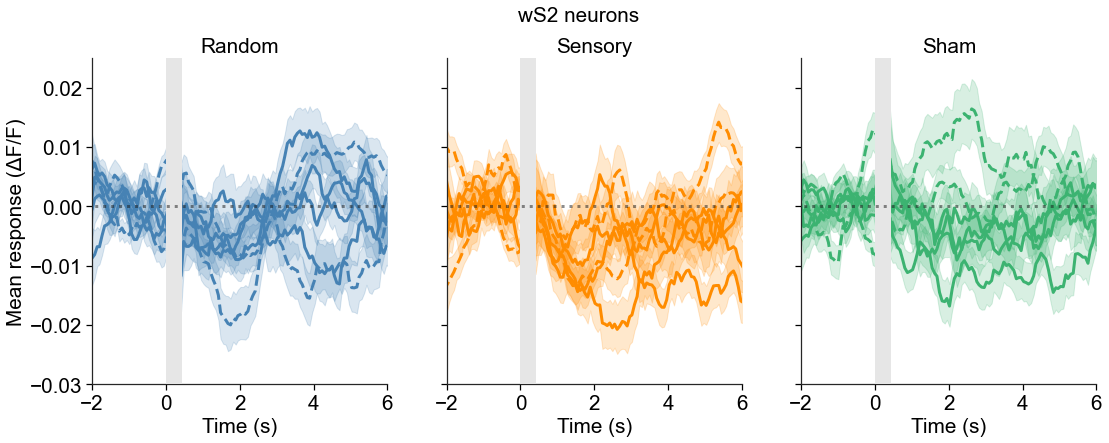

In [276]:
# TRACE AVERAGE PER ANIMAL OF ONLY S2 NON-TARGET

# list of column names to be used to filter the dataframe
target_type = ['pr_target', 'ps_target', 'pr_target']
responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

n_numbers = []

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True, figsize=(18,6))

for target, response, color, label, ax in zip(target_type, responses, plot_colors, plot_labels, axes):

    # filter dataframes using variables above
    s2_nontargets = cell_df[~cell_df[target] & cell_df['s2_cell']].index
    
    df_filter = cell_mean_timepoint_df['cell_id'].isin(s2_nontargets)
    filtered_df = cell_mean_timepoint_df[df_filter]
    
    for session_id in filtered_df.session_id.unique():
        if any(s in session_id for s in ['RL093', 'RL103']): 
            plot_ls = 'dashed'
        else:
            plot_ls = 'solid'
        
        animal_df = filtered_df.loc[filtered_df.session_id == session_id].copy()
        animal_df.loc[(animal_df['timepoint'] > 0) & (animal_df['timepoint'] <= photostim_duration), 
                    ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
        rolling_mean = animal_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]
    
        sns.lineplot(data=animal_df, x='timepoint', y=rolling_mean.to_numpy(), 
                     estimator='mean', ci=95, ax=ax, color=color, linewidth=plot_lw, linestyle=plot_ls)

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mean response (ΔF/F)')
    ax.set_title(label)
    ax.hlines(0, -3, 11, linestyles='dotted', zorder=4, alpha=0.5, lw=3, color='k');
    ax.set_ylim([-0.03, 0.025])
    ax.set_xlim([-2,6])
    
    # construct patch to cover stim artifact period
    stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
    ax.add_patch(stim_patch)
    
    target_text = ['targets', 'non targets']
    n_numbers.append(f'n = {len(s2_nontargets.unique())} cells for {label} non-targets')
    
    display(fig)
    clear_output(wait = True)
        
for ax in axes[1:3]:
    ax.set_ylabel('')

plt.suptitle('wS2 neurons', fontsize='xx-large', y=1)
save_path = fig_save_path + '_cell_grandaverage_dff_trace_s2_animalwise'
ia.savePlot(save_path)
    
n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

print('N_numbers:', *n_numbers, sep='\n')

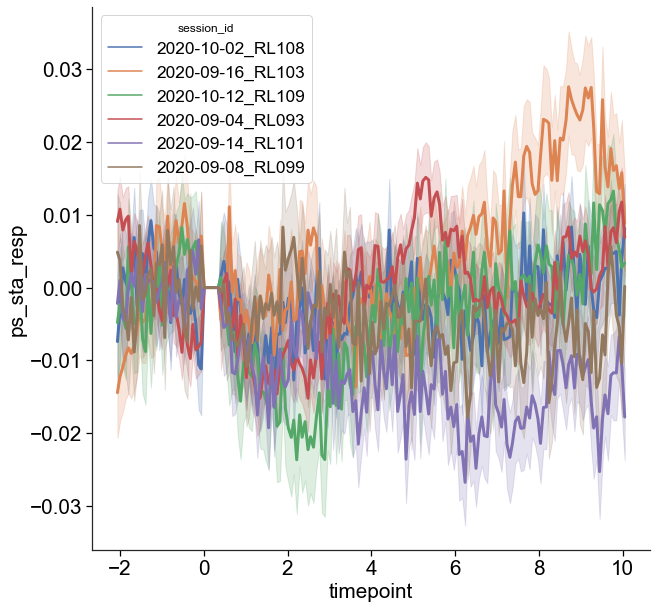

In [105]:
s1_nontargets = cell_df[~cell_df['ps_target'] & cell_df['s2_cell']].index
df_filter = cell_mean_timepoint_df['cell_id'].isin(s1_nontargets)
filtered_df = cell_mean_timepoint_df[df_filter]

fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.lineplot(data=filtered_df, x='timepoint', y='ps_sta_resp', 
             estimator='mean', ci=95, hue='session_id', linewidth=plot_lw);

save_path = fig_save_path + '_cell_grandaverage_dff_trace_s2_animalwise_colorcoded_ps'
ia.savePlot(save_path)

N_numbers:
n = 6225 cells for Random non-targets
n = 6195 cells for Sensory non-targets
n = 6225 cells for Sham non-targets
n = 6 animals


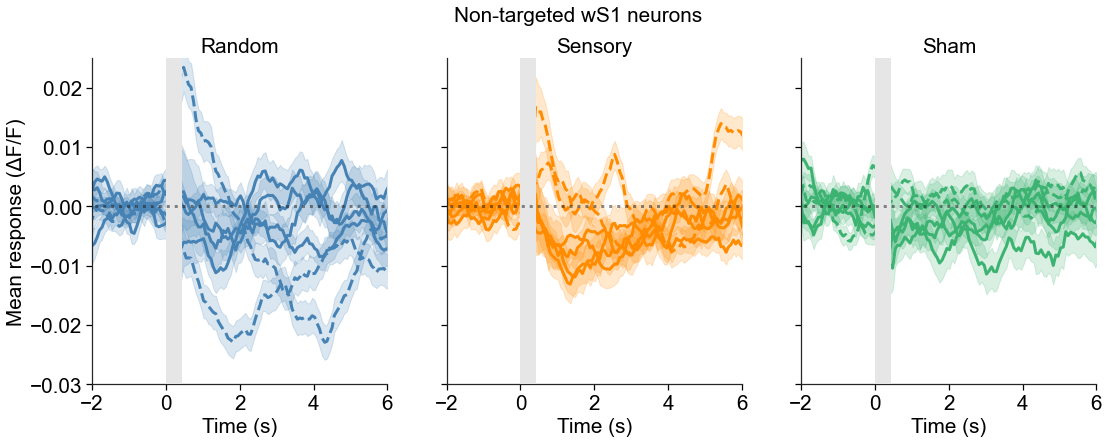

In [277]:
# TRACE AVERAGE PER ANIMAL OF ONLY S1 NON-TARGET

# list of column names to be used to filter the dataframe
target_type = ['pr_target', 'ps_target', 'pr_target']
responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

n_numbers = []

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True, figsize=(18,6))

for target, response, color, label, ax in zip(target_type, responses, plot_colors, plot_labels, axes):

    # filter dataframes using variables above
    s1_nontargets = cell_df[~cell_df[target] & cell_df['s1_cell']].index
    
    df_filter = cell_mean_timepoint_df['cell_id'].isin(s1_nontargets)
    filtered_df = cell_mean_timepoint_df[df_filter]
    
    for session_id in filtered_df.session_id.unique():
        if any(s in session_id for s in ['RL093', 'RL103']): 
            plot_ls = 'dashed'
        else:
            plot_ls = 'solid'
        
        animal_df = filtered_df.loc[filtered_df.session_id == session_id].copy()
        animal_df.loc[(animal_df['timepoint'] > 0) & (animal_df['timepoint'] <= photostim_duration), 
                    ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
        rolling_mean = animal_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]
        
        sns.lineplot(data=animal_df, x='timepoint', y=rolling_mean.to_numpy(), 
                     estimator='mean', ci=95, ax=ax, color=color, linewidth=plot_lw, linestyle=plot_ls)

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mean response (ΔF/F)')
    ax.set_title(label)
    ax.hlines(0, -3, 11, linestyles='dotted', zorder=4, alpha=0.5, lw=3, color='k');
    ax.set_ylim([-0.03, 0.025])
    ax.set_xlim([-2,6])
    
    # construct patch to cover stim artifact period
    stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
    ax.add_patch(stim_patch)
    
    target_text = ['targets', 'non targets']
    n_numbers.append(f'n = {len(s1_nontargets.unique())} cells for {label} non-targets')
    
    display(fig)
    clear_output(wait = True)
        
for ax in axes[1:3]:
    ax.set_ylabel('')

plt.suptitle('Non-targeted wS1 neurons', fontsize='xx-large', y=1)
save_path = fig_save_path + '_cell_grandaverage_dff_trace_s1nt_animalwise'
ia.savePlot(save_path)
    
n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

print('N_numbers:', *n_numbers, sep='\n')

Random, Sham MannwhitneyuResult(statistic=11.0, pvalue=0.1489765308040839)
Sensory, Sham MannwhitneyuResult(statistic=5.0, pvalue=0.02266378103898607)
Random, Sensory MannwhitneyuResult(statistic=9.0, pvalue=0.08674273416073924)


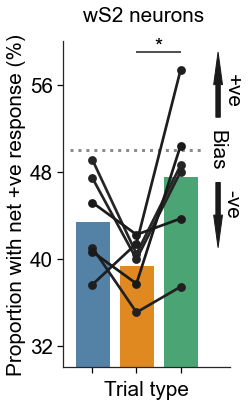

In [167]:
###### list of column names to be used to filter the dataframe
target_type = ['pr_target', 'ps_target', 'pr_target']
sign_bool = ['pr_resp_sign', 'ps_resp_sign', 'spont_resp_sign']

s2_nontargets_neg_df = pd.DataFrame()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,6))

for stim_id, label in enumerate(plot_labels):
        
    # define column names
    target = target_type[stim_id]
    sign = sign_bool[stim_id]
    
    s2_nontargets_neg = cell_df[~cell_df[target] & cell_df['s2_cell'] & 
                                ~cell_df[sign]].groupby('session_id').count()/cell_df[cell_df['s2_cell']].groupby('session_id').count()*100
    s2_nontargets_neg_df = pd.concat([s2_nontargets_neg_df, pd.DataFrame({label : s2_nontargets_neg['cell_num']})])

temp_df = s2_nontargets_neg_df.reset_index() \
                              .melt(id_vars='session_id', value_name='positive_cells', var_name='trial_type') \
                              .dropna() \
                              .copy()
temp_df['positive_cells'] = 100-temp_df['positive_cells']
sns.pointplot(data=temp_df, x='trial_type', y='positive_cells', hue='session_id', color='k', ax=ax)
sns.barplot(data=temp_df, x='trial_type', y='positive_cells', palette=sns.color_palette(plot_colors),
            ci=None, ax=ax, zorder=-1)
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

# sns.swarmplot(data=s2_nontargets_neg_df, color='k', edgecolor='k')
# sns.violinplot(data=s2_nontargets_neg_df, cut=0, scale='width', palette=sns.color_palette(plot_colors))
plt.hlines(50, -0.5, 2.5, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
plt.xlabel('Trial type')
plt.ylabel('Proportion with net +ve response (%)')
plt.suptitle('wS2 neurons', fontsize='xx-large', y=0.96)

ax.text(2.6, 50, 'Bias', va='center', fontsize='xx-large', rotation=-90)

ax.text(2.95, 45, '-ve', va='center', fontsize='xx-large', rotation=-90)
ax.arrow(2.85, 47, 0, -3, width=0.1, head_width=0.2, head_length=3, color='k')

ax.arrow(2.85, 53, 0, 3, width=0.1, head_width=0.2, head_length=3, color='k')
ax.text(2.95, 55.5, '+ve', va='center', fontsize='xx-large', rotation=-90)

ax0_labels = [item.get_text() for item in ax.get_xticklabels()]
ax0_labels = ['','','']

ax.set_xticklabels(ax0_labels)

ax.legend().set_visible(False)

#stats
group1 = temp_df[temp_df['trial_type']==plot_labels[0]]['positive_cells'].to_numpy()
group2 = temp_df[temp_df['trial_type']==plot_labels[1]]['positive_cells'].to_numpy()
group3 = temp_df[temp_df['trial_type']==plot_labels[2]]['positive_cells'].to_numpy()

print(f'{plot_labels[0]}, {plot_labels[2]}', stats.mannwhitneyu(group1, group3))
print(f'{plot_labels[1]}, {plot_labels[2]}', stats.mannwhitneyu(group2, group3))
print(f'{plot_labels[0]}, {plot_labels[1]}', stats.mannwhitneyu(group1, group2))

if sensory:
#     ax.hlines(52, 0, 1, color='k')
#     ax.text(0.15, 53, 'n.s.', fontsize='xx-large')
    ax.hlines(59, 1, 2, color='k')
    ax.text(1.4, 59, '*', fontsize='xx-large')
#     ax.hlines(64, 0, 2, color='k')
#     ax.text(0.65, 65, 'n.s.', fontsize='xx-large')
# if projection:
#     ax.hlines(-0.004, 0, 1, color='k')
#     ax.text(0.6, -0.007, '**', fontsize='xx-large')
#     ax.hlines(0.006, 1, 2, color='k')
#     ax.text(1.9, 0.006, 'n.s.', fontsize='x-large')
#     ax.hlines(0.009, 0, 2, color='k')
#     ax.text(1, 0.008, '*', fontsize='xx-large')

plt.ylim([30, 60])

# save the figure
save_path = fig_save_path + '_proportion_nontarget_cell_positive_responses'
ia.savePlot(save_path)

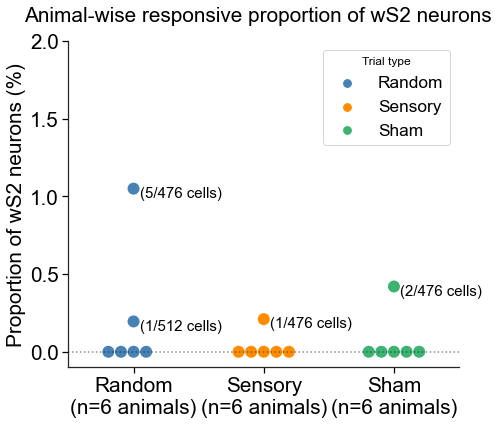

In [108]:
# list of column names to be used to filter the dataframe

# test_type = 'no multiple corrections'
test_type = 'FDR correction'
if test_type == 'FDR correction':
    stat_test = ['sta_sig_pr', 'sta_sig_ps', 'sta_sig_spont']
if test_type == 'no multiple corrections':
    stat_test = ['sta_sig_nomulti_pr', 'sta_sig_nomulti_ps', 'sta_sig_nomulti_spont']
target_type = ['pr_target', 'ps_target', 'pr_target']

s2_nontargets_df = pd.DataFrame()

# create and populate the plots using filtered data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))

for stim_id, trial in enumerate(plot_labels):
        
    # define column names
    test = stat_test[stim_id]
    target = target_type[stim_id]
    
    # filter dataframes using variables above
    num_cells = cell_df[cell_df[test] & ~cell_df[target] & cell_df['s2_cell']].groupby('session_id').count()
    total_cells = cell_df[cell_df['s2_cell']].groupby('session_id').count()
    s2_nontargets = (num_cells/total_cells)*100
    s2_nontargets_df = pd.concat([s2_nontargets_df, 
                                  pd.DataFrame({'proportion' : s2_nontargets['cell_num'],
                                                'Trial type' : np.repeat(trial, len(s2_nontargets)),
                                                'num_cells' : num_cells['cell_num'],
                                                'total_cells' : total_cells['cell_num']
                                               },
                                               index=s2_nontargets.index)], axis=0)

s2_nontargets_df.fillna(0, inplace=True)

sns.swarmplot(data=s2_nontargets_df, x='Trial type', y='proportion', hue='Trial type', 
              ax=ax, palette=sns.color_palette(plot_colors), s=12)
# sns.swarmplot(data=s2_nontargets_df, x='trial_type', y='proportion', color='k', ax=ax, edgecolor='k')
# sns.violinplot(data=s2_nontargets_df, ax=ax, cut=0, scale='width')

ax.set_ylabel('Proportion of wS2 neurons (%)')
ax.set_xlabel('')
ax.hlines(0, -0.5, 2.5, linestyles='dotted', zorder=4, alpha=0.5, color='k');

buffer = 0.1

for row in s2_nontargets_df.iterrows():
    df_row = row[1]
    trial_type_dict = {plot_labels[0] : 0,
                       plot_labels[1] : 1,
                       plot_labels[2] : 2
                      }
    x = trial_type_dict[df_row['Trial type']] + 0.05
    y = df_row.proportion - (ax.get_ylim()[1]/20)
    s = f'({int(df_row["num_cells"])}/{df_row["total_cells"]} cells)'
    
    # verbose way of catching problems with text sitting too close together
    if df_row.proportion > 0:
        if df_row['Trial type'] == 'wS2-projecting':
            y = df_row.proportion - buffer
            buffer = -0.05
            ax.text(x, y, s, fontsize=15)
            continue
        ax.text(x, y, s, fontsize=15)

ax1_labels = [item.get_text() + '\n(n=6 animals)' for item in ax.get_xticklabels()]
if ax1_labels[0] == 'Non-wS2-projecting\n(n=6 animals)': ax1_labels[0] = 'Non-wS2-proj.\n(n=6 animals)'

ax.set_xticklabels(ax1_labels)
# ax.legend().set_visible(False)
ax.set_ylim(-0.1,2)

plt.suptitle('Animal-wise responsive proportion of wS2 neurons', y=0.96, fontsize='xx-large');

# save the figure
save_path = fig_save_path + '_proportion_responsive_s2_cells_' + test_type
ia.savePlot(save_path)

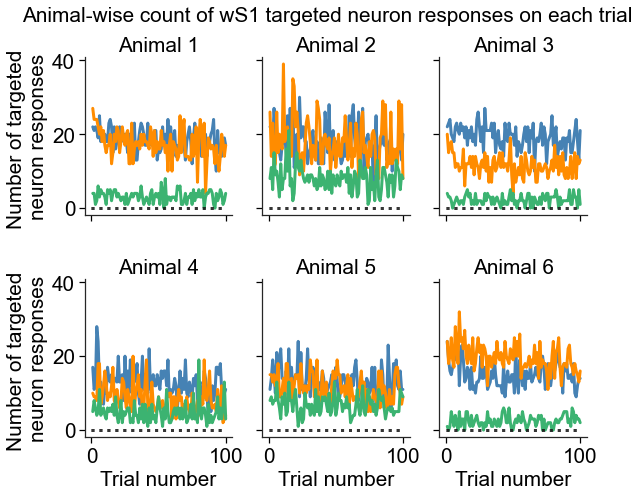

In [109]:
trials = ['pr', 'ps', 'spont']
targets = ['pr', 'ps', 'pr']

session_ids = cell_trial_df['session_id'].unique()   
ncols = np.round(len(session_ids)/2).astype('int')

if not projection:
    fig, axes = plt.subplots(nrows=2, ncols=ncols, sharey=True, sharex=True, figsize=(3*ncols,7))
else:
    fig, axes = plt.subplots(nrows=2, ncols=ncols, sharey=True, sharex=True, figsize=(3*ncols,7))

for color, trial, target, label in zip(plot_colors, trials, targets, plot_labels):
    
    target_cell_ids = cell_df.query(target + '_target & ' + trial + '_resp_sign').index

    target_filter = cell_trial_df['cell_id'].isin(target_cell_ids)
    
    filtered_df = cell_trial_df[target_filter] \
                   .groupby(['session_id', 'trial_num'])['trial_sig_dff_' + trial] \
                   .sum() \
                   .reset_index(drop=False) \
    
    for ax_i, ax in enumerate(axes.flatten()):
        
        if ax_i >= len(session_ids): ax.axis('off')
            
        try:
            animal_df = filtered_df[filtered_df['session_id']==session_ids[ax_i]]
        except:
            break
        
        sns.lineplot(x='trial_num', y='trial_sig_dff_'+trial, data=animal_df, ci=None, ax=ax, 
                     label=label, legend=False, color=color, linewidth=plot_lw)
#         ax.set_title(session_ids[ax_i])
        ax.set_title('Animal ' + str(ax_i+1))
        
        ax.set_ylabel('Number of targeted \nneuron responses')
            
        ax.hlines(0, 0, 100, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
    
    for ax in axes[1]:
        ax.set_xlabel('Trial number')
                    
plt.suptitle('Animal-wise count of wS1 targeted neuron responses on each trial', y=0.98, fontsize='xx-large');
plt.subplots_adjust(hspace=0.4)

# save the figure
save_path = fig_save_path + '_animalwise_trialwise_number_targets_responding'
ia.savePlot(save_path)

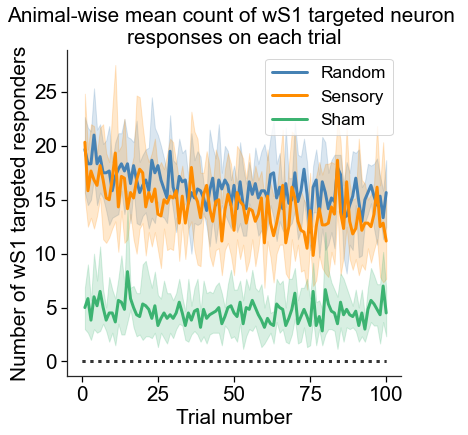

In [110]:
trials = ['pr', 'ps', 'spont']
targets = ['pr', 'ps', 'pr']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

for color, trial, target, label in zip(plot_colors, trials, targets, plot_labels):
    
    target_cell_ids = cell_df.query(target + '_target & ' + trial + '_resp_sign').index

    target_filter = cell_trial_df['cell_id'].isin(target_cell_ids)
    
    filtered_df = cell_trial_df[target_filter] \
                   .groupby(['session_id', 'trial_num'])['trial_sig_dff_' + trial] \
                   .sum() \
                   .reset_index(drop=False) \

    sns.lineplot(x='trial_num', y='trial_sig_dff_'+trial, data=filtered_df, ci=95, estimator='mean', ax=ax, 
                 label=label, legend=False, color=color, linewidth=3)

    ax.legend(plot_labels)
    ax.set_xlabel('Trial number')
    ax.set_ylabel('Number of wS1 targeted responders')

    ax.hlines(0, 0, 100, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
                    
    ax.set_title('Animal-wise mean count of wS1 targeted neuron \nresponses on each trial', y=1, fontsize='xx-large');

# save the figure
save_path = fig_save_path + '_trialwise_average_target_cells_responding'
ia.savePlot(save_path)

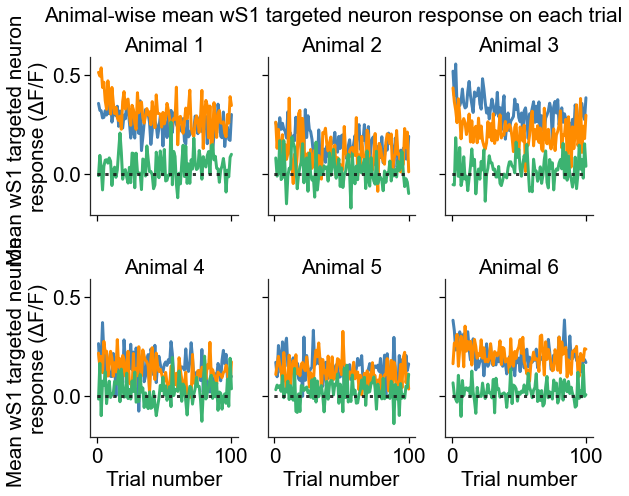

In [111]:
trials = ['pr', 'ps', 'spont']
targets = ['pr', 'ps', 'pr']

session_ids = cell_trial_df['session_id'].unique()   
ncols = np.round(len(session_ids)/2).astype('int')

if not projection:
    fig, axes = plt.subplots(nrows=2, ncols=ncols, sharey=True, sharex=True, figsize=(3*ncols,7))
else:
    fig, axes = plt.subplots(nrows=2, ncols=ncols, sharey=True, sharex=True, figsize=(3*ncols,7))

for color, trial, target, label in zip(plot_colors, trials, targets, plot_labels):
    
    target_cell_ids = cell_df.query(target + '_target & ' + trial + '_resp_sign').index

    target_filter = cell_trial_df['cell_id'].isin(target_cell_ids)
    
    filtered_df = cell_trial_df[target_filter] \
                   .groupby(['session_id', 'trial_num'])[trial + '_amp_resp'] \
                   .mean() \
                   .reset_index(drop=False) \
    
    for ax_i, ax in enumerate(axes.flatten()):
        
        if ax_i >= len(session_ids): ax.axis('off')
            
        try:
            animal_df = filtered_df[filtered_df['session_id']==session_ids[ax_i]]
        except:
            break
        
        sns.lineplot(x='trial_num', y=trial + '_amp_resp', data=animal_df, ci=None, ax=ax, 
                     label=label, legend=False, color=color, linewidth=plot_lw)

        ax.set_title('Animal ' + str(ax_i+1))
             
        ax.set_ylabel('Mean wS1 targeted neuron \nresponse (ΔF/F)')
   
        ax.hlines(0, 0, 100, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
    
    for ax in axes[1]:
        ax.set_xlabel('Trial number')
                    
plt.suptitle('Animal-wise mean wS1 targeted neuron response on each trial', y=0.98, fontsize='xx-large');
plt.subplots_adjust(hspace=0.4)
# save the figure
save_path = fig_save_path + '_animalwise_trialwise_mean_target_response'
ia.savePlot(save_path)

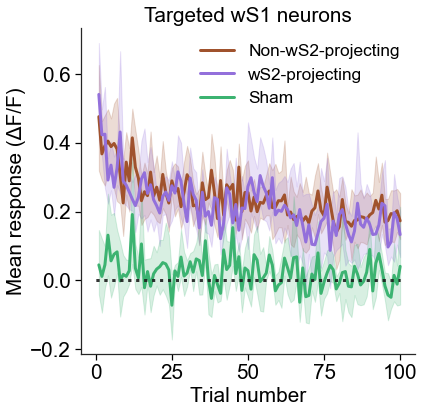

In [250]:
trials = ['pr', 'ps', 'spont']
targets = ['pr', 'ps', 'pr']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

for color, trial, target, label in zip(plot_colors, trials, targets, plot_labels):
    
    target_cell_ids = cell_df.query(target + '_target & ' + trial + '_resp_sign').index

    target_filter = cell_trial_df['cell_id'].isin(target_cell_ids)
    
    filtered_df = cell_trial_df[target_filter] \
                   .groupby(['session_id', 'trial_num'])[trial + '_amp_resp'] \
                   .mean() \
                   .reset_index(drop=False) \

    sns.lineplot(x='trial_num', y=trial + '_amp_resp', data=filtered_df, ci=95, estimator='mean', 
                 ax=ax, label=label, legend=False, color=color, linewidth=3)

    ax.legend(plot_labels)
    ax.set_xlabel('Trial number')
    ax.set_ylabel('Mean response (ΔF/F)')

    ax.hlines(0, 0, 100, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
                    
    ax.set_title('Targeted wS1 neurons', y=1, fontsize='xx-large');

ax.legend().draw_frame(False)

# save the figure
save_path = fig_save_path + '_trialwise_average_target_cell_responses'
ia.savePlot(save_path)

In [7]:
def s2pMasks(s2p_path, cell_ids, values):
    '''Return image of cell masks with pixel value corresponding to index
    
    Inputs:
        s2p_path -- directory with outputs from Suite2p ('save_path0')
        cell_ids -- indices of cells to add to the image
        values   -- values to fill the masks with (default is cell_ids)
    
    Returns:
        mask_img -- 2D uint16 array with cell ROIs filled with cell index value
    '''

    os.chdir(s2p_path)

    stat = np.load('stat.npy', allow_pickle=True)
    ops = np.load('ops.npy', allow_pickle=True).item()
    iscell = np.load('iscell.npy', allow_pickle=True)           
    
    mask_img = np.zeros((ops['Ly'], ops['Lx']), dtype='int16')

    for n in range(0,len(iscell)):
        if n in cell_ids:
            ypix = stat[n]['ypix']
            xpix = stat[n]['xpix']
            mask_img[ypix,xpix] = values[np.where(np.array(cell_ids) == n)[0]]*100
    
    return mask_img

In [5]:
if sensory:
    pkl_files = ia.listdirFullpath(os.path.join(pkl_folder, session_type), string='RL101.pkl')

    # pkl_files = ia.listdirFullpath(os.path.join(pkl_folder, 'interneuron'), string='20_RL124.pkl')

    for pkl in pkl_files:

        ses_obj = ia.loadPickle(pkl)
    
    s2p_path = '/home/rlees/mnt/qnap/Data/2020-09-14/RL101/2020-09-14_RL101_t-007/suite2p/plane0'
    cell_ids = ses_obj.photostim_s.cell_id[0]
    values = ses_obj.photostim_s.sta_amplitudes[0]

    mask_img = s2pMasks(s2p_path, cell_ids, values)

    plt.figure(figsize=(10,10))
    plt.imshow(mask_img, vmin=-50, vmax=50, cmap='bwr');

Loading pickle: /home/rlees/mnt/qnap/pkl_files/sensory_2sec_test/2020-09-14_RL101.pkl


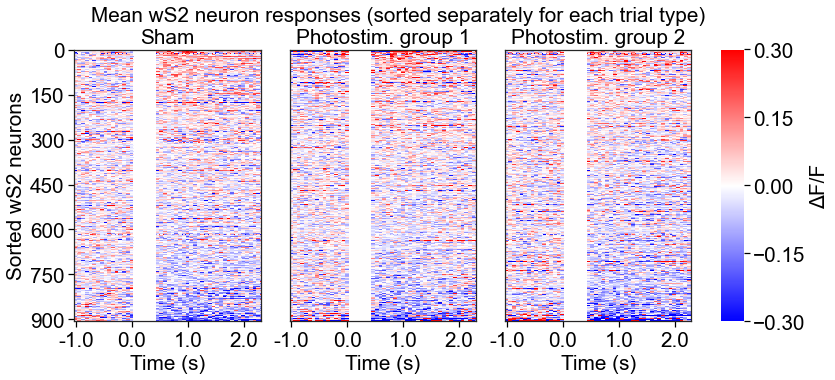

In [9]:
if sensory:
    fig, axes = plt.subplots(1,4,figsize=(12,5), gridspec_kw={'width_ratios' : [2,2,2,0.25]})

    group_labels = ['Sham', 'Photostim. group 1', 'Photostim. group 2']
    exp_objs = [ses_obj.spont, ses_obj.photostim_r, ses_obj.photostim_s]

    for i, (ax, group_label, exp_obj) in enumerate(zip(axes[:3], 
                                                       group_labels, 
                                                       exp_objs)):
        fps = exp_obj.fps

        s2_cells = exp_obj.cell_s2[0]
        s2_stas = exp_obj.stas[0][s2_cells]
        s2_post_stim = s2_stas[:,38:50]
        s2_mean_post_stim = np.mean(s2_post_stim, axis=1)
        sorted_idxs = np.argsort(s2_mean_post_stim)
        sorted_s2_stas = s2_stas[sorted_idxs[::-1]]

        xticks = (np.array( range(0,len(sorted_s2_stas[0]))  ) / fps) - 2
        xticks = xticks.round()
        xticks[xticks==-0] = 0

        sta_df = pd.DataFrame(sorted_s2_stas, columns=xticks)

        if i == 0:
            sns.heatmap(sta_df, vmin=-0.3, vmax=0.3, cmap='bwr', yticklabels=150, 
                        xticklabels=15, ax=ax, cbar=False)
            ax.set_ylabel('Sorted wS2 neurons');
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        elif i == 2:
            sns.heatmap(sta_df, vmin=-0.3, vmax=0.3, cmap='bwr', yticklabels=150, 
                        xticklabels=15, ax=ax, cbar=True, cbar_ax=axes[3])
            ax.set_ylabel('');
            ax.set_yticks([])
        else:
            sns.heatmap(sta_df, vmin=-0.3, vmax=0.3, cmap='bwr', yticklabels=150, 
                        xticklabels=15, ax=ax, cbar=False)
            ax.set_ylabel('');
            ax.set_yticks([])

        ax.set_title(group_label)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        ax.set_xlim([15, 65]);
        ax.set_xlabel('Time (s)');

    for ax in axes:
        for _, spine in ax.spines.items():
            spine.set_visible(True)

    axes[3].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[3].set_ylabel('ΔF/F')
    plt.suptitle('Mean wS2 neuron responses (sorted separately for each trial type)', fontsize='xx-large', y=1);

    fig_dir = os.path.join(fig_save_path, 'S1S2_mechanisms_panels', '')
    save_path = fig_dir + 'RL101_s2_responses_heatmap'
    ia.savePlot(save_path)

# Sort targeted cells by distance to SLM target centers

In [251]:
# ADD TARGET COORDS TO EXPERIMENT DF TO COMPARE EACH CELL TO

# for each row in experiment_df (in order) x
# if stim_type is pr or ps x
# use sheet name to open pkl file x
# obtain exp_obj.target_coords x
# save to list of target_coords x
# append list to dataframe with index obtained from current df row x

pkl_files = ia.listdirFullpath(os.path.join(pkl_folder, session_type), string='.pkl')
if sensory:
    pkl_files = [file for file in pkl_files if not any(s in file for s in remove_list)]

target_coord_df = pd.DataFrame()

for index, row in experiment_df.iterrows():
    if any(s in row['stim_type'] for s in ['pr', 'ps']):
        for pkl_file in pkl_files:
            if row['session_id'] in pkl_file:
                ses_obj = ia.loadPickle(pkl_file)
    
                exp_obj = ia.makeExpList(ses_obj, row['stim_type'])[0]
                temp_df = pd.DataFrame({'target_coords' : [exp_obj.target_coords]}, index=[index])
                target_coord_df = pd.concat([target_coord_df, temp_df])
                
experiment_df['target_coords'] = target_coord_df

Loading pickle: /home/rlees/mnt/qnap/pkl_files/projection_2sec_test/2021-02-24_RL132.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/projection_2sec_test/2021-02-24_RL132.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/projection_2sec_test/2021-02-18_RL127.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/projection_2sec_test/2021-02-18_RL127.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/projection_2sec_test/2021-02-23_RL129.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/projection_2sec_test/2021-02-23_RL129.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/projection_2sec_test/2021-03-02_RL130.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/projection_2sec_test/2021-03-02_RL130.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/projection_2sec_test/2021-02-25_RL131.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/projection_2sec_test/2021-02-25_RL131.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/projection_2sec_test/2021-02-22_RL128.pkl
Loading pickle: /home

In [252]:
# ADD DIST TO TARGET TO THE CELL DF FROM THE TARGET COORDS FOUND IN EXPERIMENT_DF

# use cell_df.cell_med as the median coord, then euclid distance to that x
# save as df x
# append new cells to df in order x
# append new column to cell_df

dist_to_target_center = pd.DataFrame()

trials = ['pr', 'ps']

for trial in trials:
    
    dist_list = []
    index_list = []
    
    for session_id in cell_df.session_id.unique():
        cell_meds = cell_df.query('session_id == @session_id')['cell_med']
        target_coords = experiment_df.query('(session_id == @session_id) & (stim_type == @trial)')['target_coords'][0]
        target_coords = np.vstack(target_coords)
                
        for cell_med in cell_meds:
            dists_to_targets = spatial.distance.cdist([cell_med], target_coords)
            min_dist = np.amin(dists_to_targets)
            
            dist_list.append(min_dist)
            
        index_list.extend(cell_meds.index)
            
    temp_df = pd.DataFrame({'dist_to_target_center_' + trial : dist_list}, index=index_list)

    dist_to_target_center = pd.concat([dist_to_target_center, temp_df], axis=1)

cell_df['dist_to_target_center_pr'] = dist_to_target_center['dist_to_target_center_pr']
cell_df['dist_to_target_center_ps'] = dist_to_target_center['dist_to_target_center_ps']

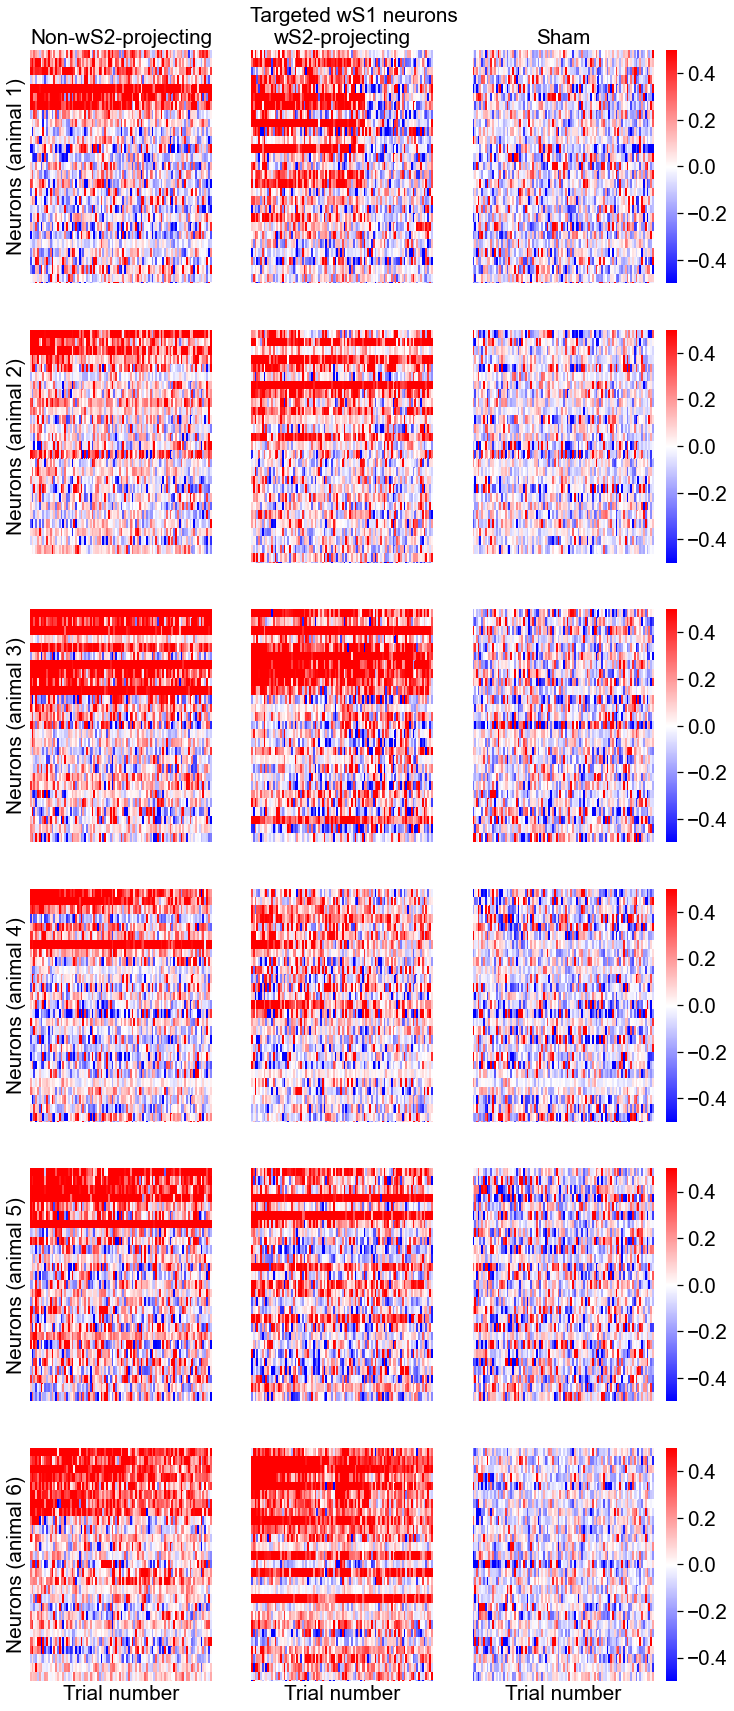

In [253]:
# plot 2d heatmap of target cells (y-axis) vs. activity using trial + _amp_resp from cell_trial_df (x-axis)

trials = ['pr', 'ps', 'spont']
targets = ['pr', 'ps', 'pr']

session_ids = cell_trial_df['session_id'].unique()   

fig, axes = plt.subplots(nrows=len(session_ids), ncols=3, 
                         sharey=True, sharex=True, figsize=(12,5*len(session_ids)), 
                         gridspec_kw={'width_ratios':(8, 8, 10)})

for row_i, session_id in enumerate(session_ids):
        
    session_group = cell_df[cell_df['session_id']==session_id]
    
    for col_i, (trial, target, label, ax) in enumerate(zip(trials, targets, plot_labels, axes[row_i])):
    
#         target_cell_ids = session_group.query('~' + target + '_target & s2_cell').index
        target_df = session_group.query(target + '_target')    
        target_cell_ids = target_df.index
        target_filter = cell_trial_df['cell_id'].isin(target_cell_ids)
        filtered_df = cell_trial_df[target_filter]
        
        crop_df = filtered_df.loc[:,['cell_num', 'trial_num', trial + '_amp_resp']]
        pivot_df = crop_df.pivot('cell_num', 'trial_num', trial + '_amp_resp')
        pivot_df['targ_dist'] = target_df['dist_to_target_center_' + target].values
        pivot_df = pivot_df.sort_values(by=['targ_dist']).drop(columns='targ_dist')
        
        if col_i==2:
            sns.heatmap(pivot_df, vmin=-0.5, vmax=0.5, cmap='bwr', ax=ax, xticklabels=False, yticklabels=False)
        else:
            sns.heatmap(pivot_df, vmin=-0.5, vmax=0.5, cmap='bwr', cbar=False, ax=ax, xticklabels=False, yticklabels=False)
            
        if row_i==0: ax.set_title(label)
        
        if row_i==(len(session_ids)-1): ax.set_xlabel('Trial number') 
        else: ax.set_xlabel('')
        
        if col_i == 0: ax.set_ylabel(f'Neurons (animal {row_i+1})')
        else: ax.set_ylabel('')
        
        plt.suptitle('Targeted wS1 neurons', fontsize='xx-large', y=0.9);
        
save_path = fig_save_path + '_animalwise_trialwise_target_response_heatmap'
ia.savePlot(save_path)

In [116]:
# # plot 2d heatmap of target cells (y-axis) vs. activity using trial + _amp_resp from cell_trial_df (x-axis)

# trials = ['pr', 'ps', 'spont']
# targets = ['pr', 'ps', 'pr']

# session_ids = cell_trial_df['session_id'].unique()   

# fig, axes = plt.subplots(nrows=len(session_ids), ncols=3, 
#                          sharey=True, sharex=True, figsize=(12,5*len(session_ids)), 
#                          gridspec_kw={'width_ratios':(8, 8, 10)})

# for row_i, session_id in enumerate(session_ids):
        
#     session_group = cell_df[cell_df['session_id']==session_id]
    
#     for col_i, (trial, target, label, ax) in enumerate(zip(trials, targets, plot_labels, axes[row_i])):
    
# #         target_cell_ids = session_group.query('~' + target + '_target & s2_cell').index
#         target_cell_ids = session_group.query(target + '_target').index
#         target_filter = cell_trial_df['cell_id'].isin(target_cell_ids)
#         filtered_df = cell_trial_df[target_filter]

#         crop_df = filtered_df.loc[:,['cell_num', 'trial_num', trial + '_amp_resp']]
#         pivot_df = crop_df.pivot('cell_num', 'trial_num', trial + '_amp_resp')
        
#         if col_i==2:
#             sns.heatmap(pivot_df, vmin=-0.5, vmax=0.5, cmap='bwr', ax=ax, xticklabels=False, yticklabels=False)
#         else:
#             sns.heatmap(pivot_df, vmin=-0.5, vmax=0.5, cmap='bwr', cbar=False, ax=ax, xticklabels=False, yticklabels=False)
            
#         if row_i==0: ax.set_title(label)
        
#         if row_i==(len(session_ids)-1): ax.set_xlabel('Trial number') 
#         else: ax.set_xlabel('')
        
#         if col_i == 0: ax.set_ylabel(f'Targeted cells (animal {row_i+1})')
#         else: ax.set_ylabel('')
        
#         plt.suptitle('S1 targeted cell response amplitude on each trial', fontsize='xx-large', y=0.9);
        
# save_path = fig_save_path + '_animalwise_trialwise_target_response_heatmap'
# ia.savePlot(save_path)

In [117]:
# trials = ['pr', 'ps']

# df = trial_df[trial_df.stim_type.isin(trials)]
# unique_animals = len(cell_df.session_id.unique())

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6), sharey=True, gridspec_kw={'width_ratios':(4,1)})

# sns.barplot(data=df, y='trial_target_euclid_dist', x='session_id', hue='stim_type', 
#             ax=axes[0], palette=sns.color_palette(plot_colors))
# sns.barplot(data=df, y='trial_target_euclid_dist', x='stim_type', 
#             ax=axes[1], palette=sns.color_palette(plot_colors))

# axes[0].set_ylabel('Mean distance from centroid of \ntargeted cell group (μm)')
# axes[1].set_ylabel('')

# axes[0].set_xlabel('Animal')
# axes[1].set_xlabel('Trial type')
    
# axes[0].set_title('All animals')
# axes[1].set_title('Mean');

# axes[0].legend().set_visible(False)

# ax0_labels = [item.get_text() for item in axes[0].get_xticklabels()]
# ax0_labels = list(range(1,unique_animals+1))

# axes[0].set_xticklabels(ax0_labels)

# ax1_labels = [item.get_text() for item in axes[1].get_xticklabels()]
# ax1_labels = ['','']

# axes[1].set_xticklabels(ax1_labels)

# plt.suptitle('Trial-wise mean spread of S1 targeted cells', fontsize='xx-large', y=1)

# # save the figure
# save_path = fig_save_path + '_target_cell_spread'
# ia.savePlot(save_path)

# Responses across trials and cells

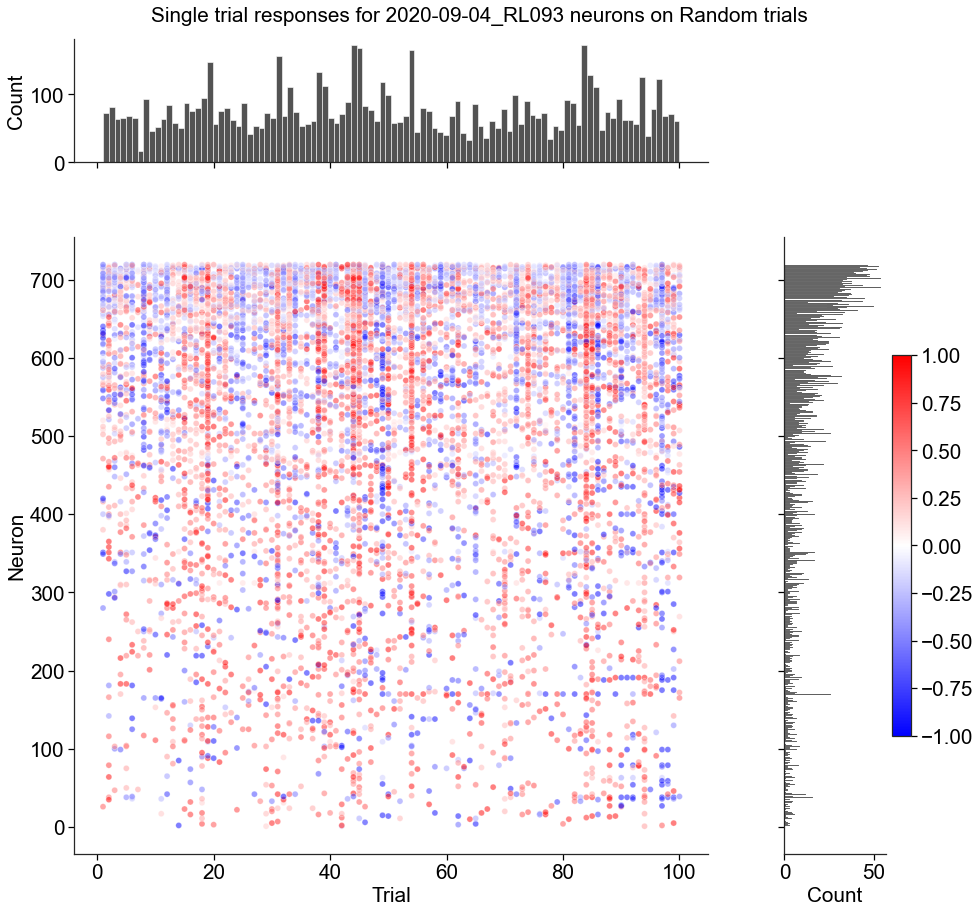

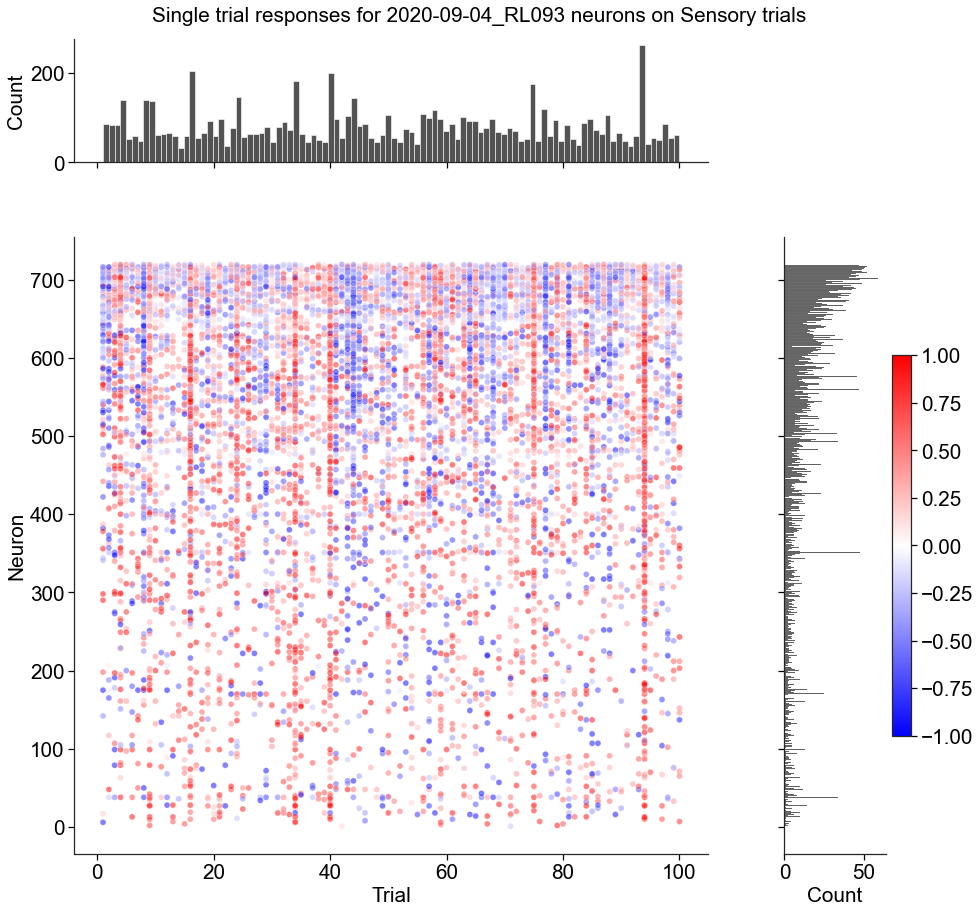

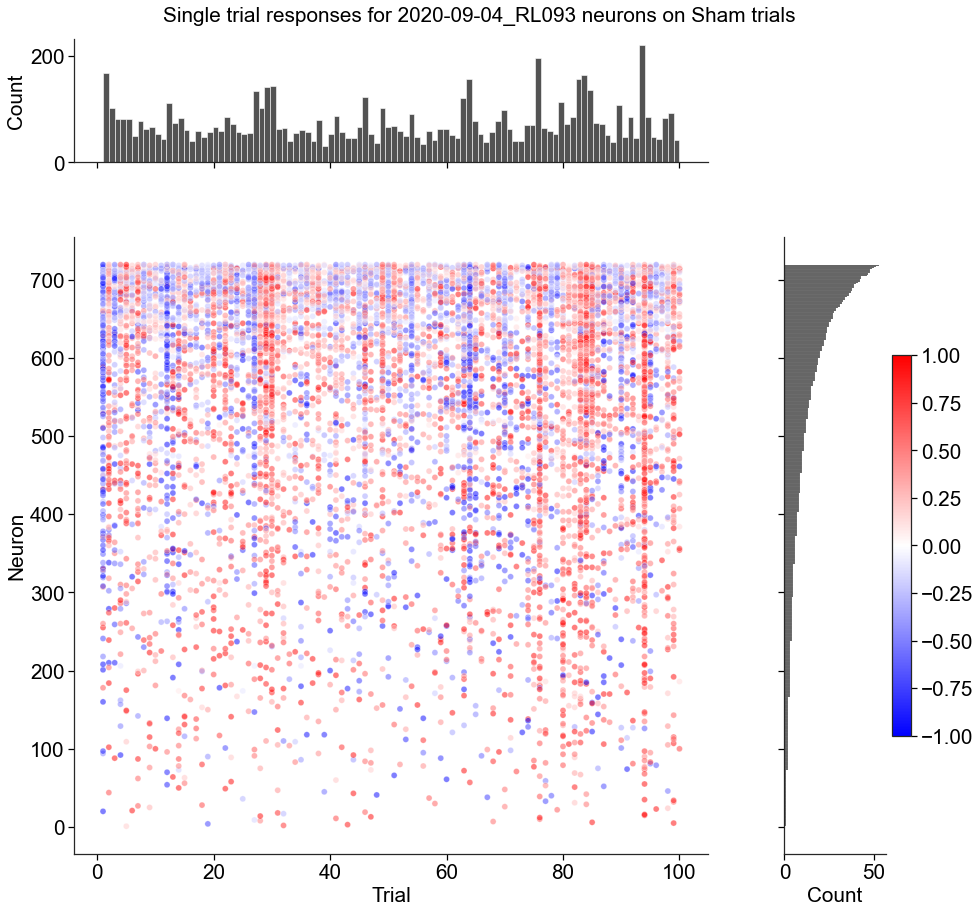

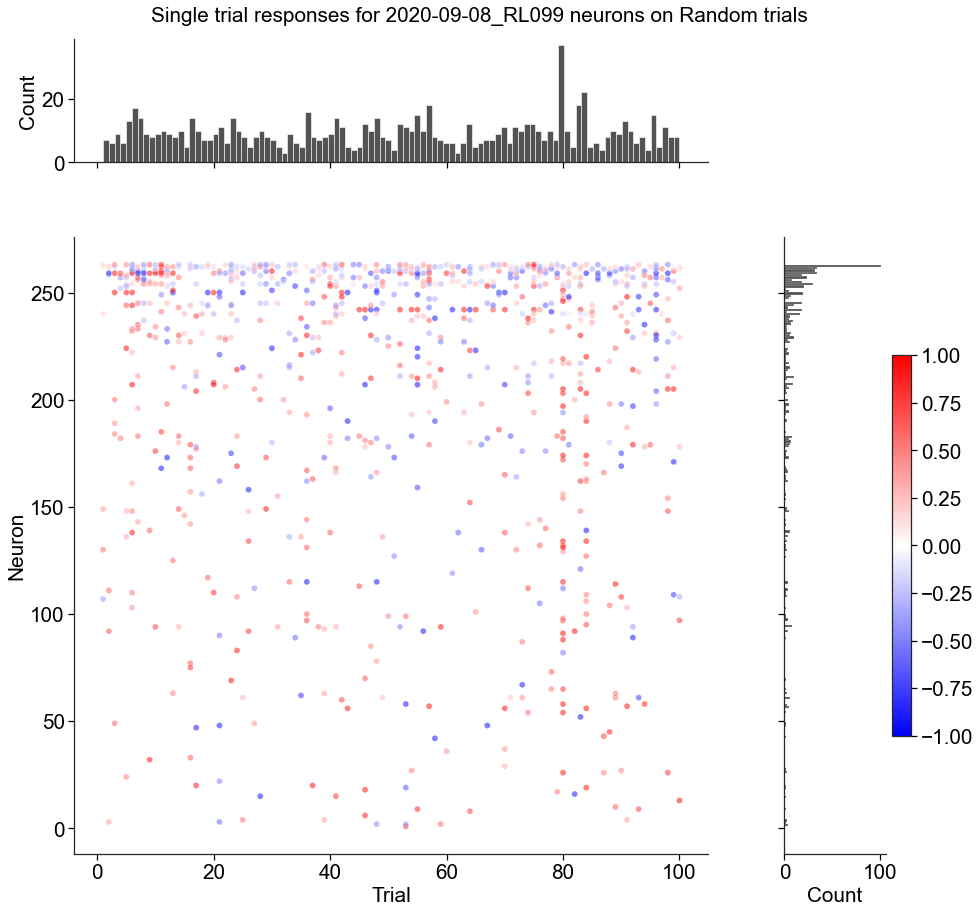

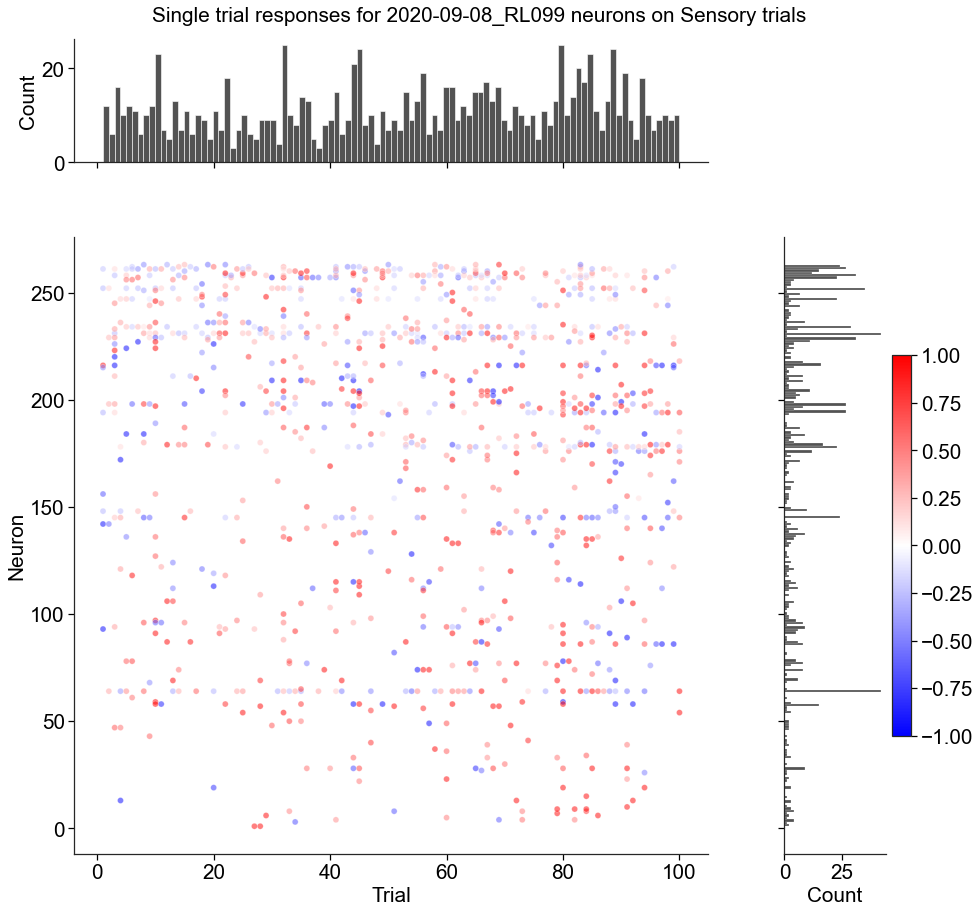

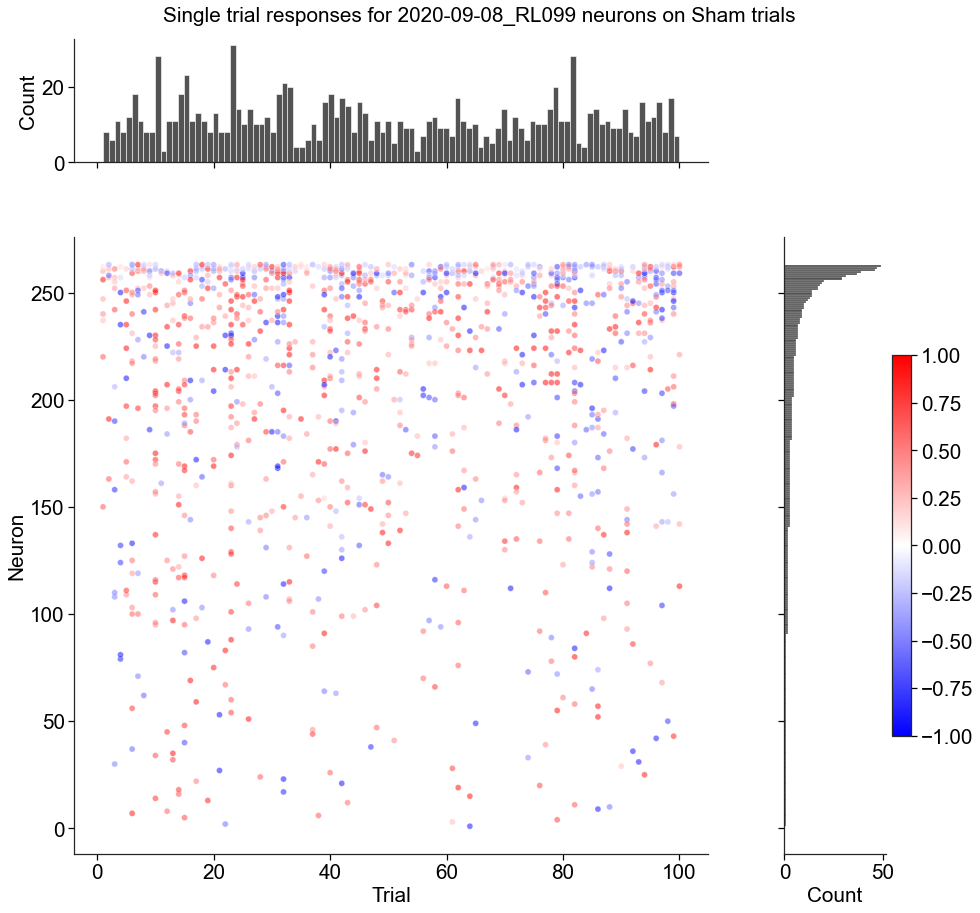

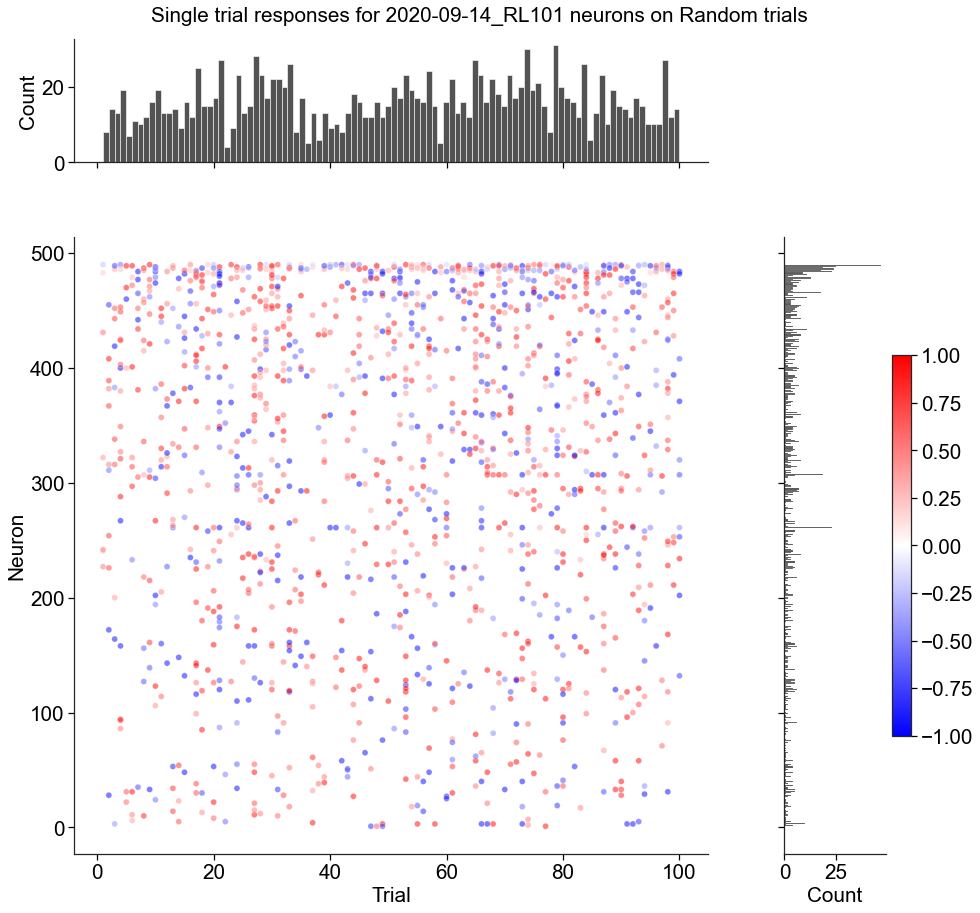

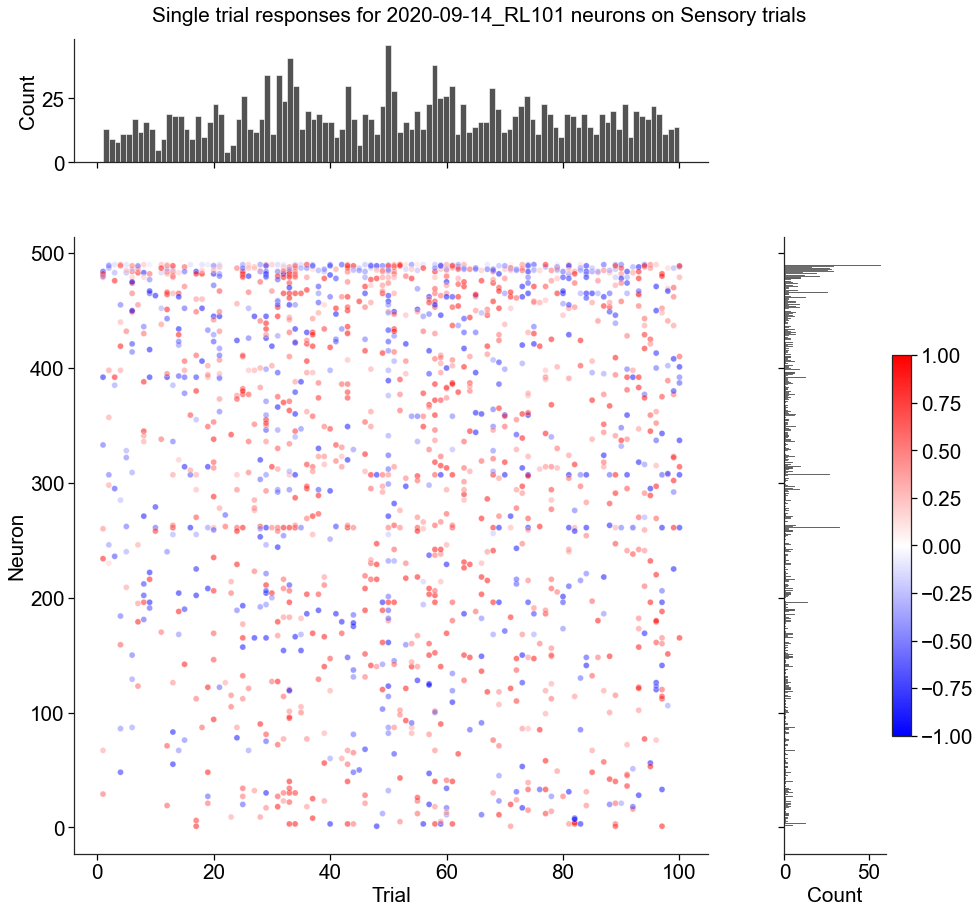

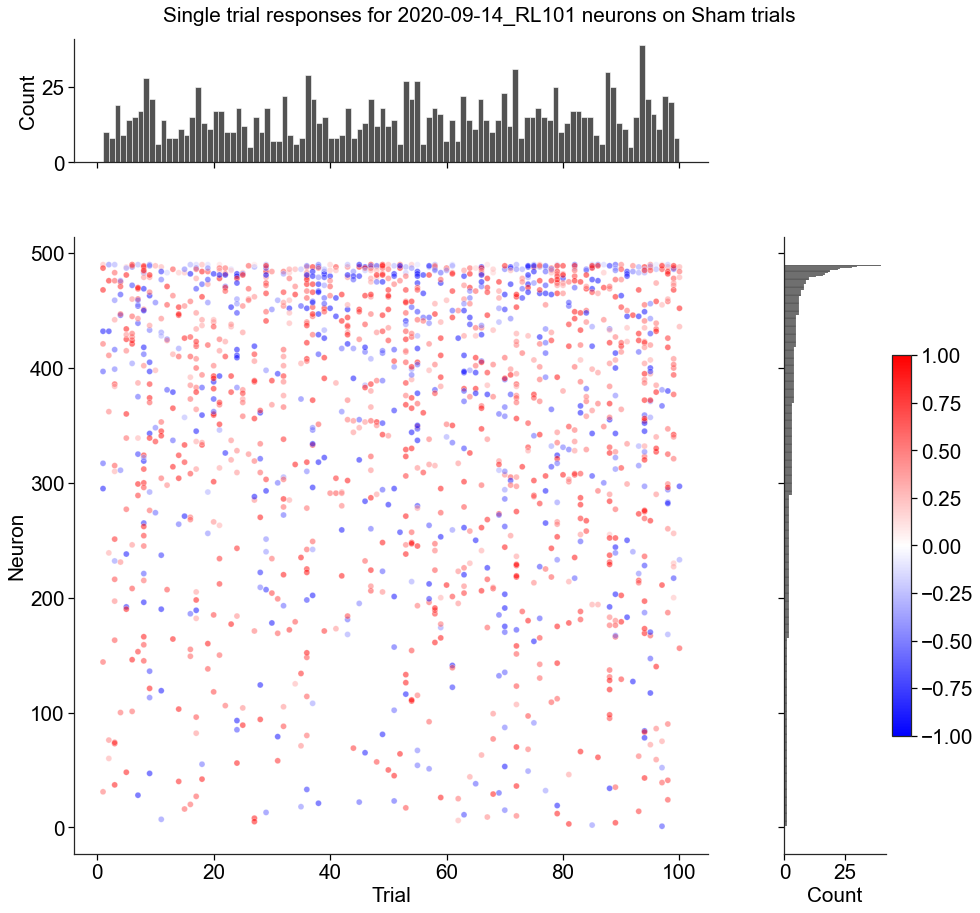

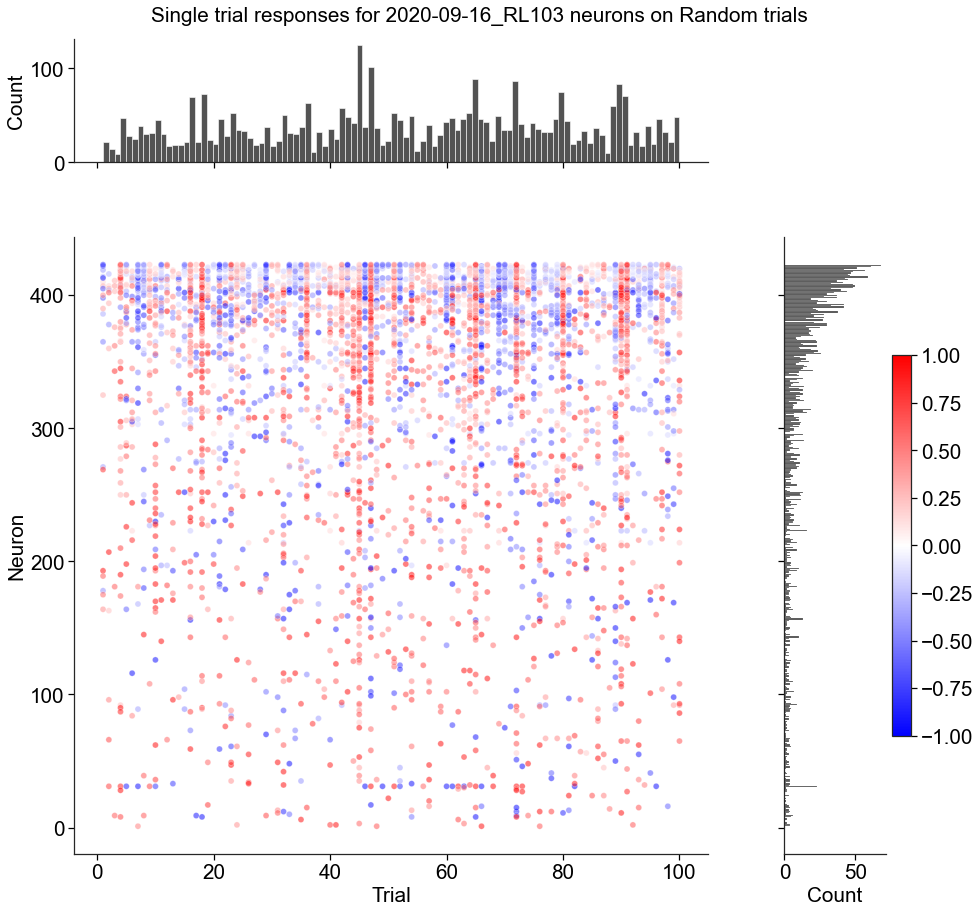

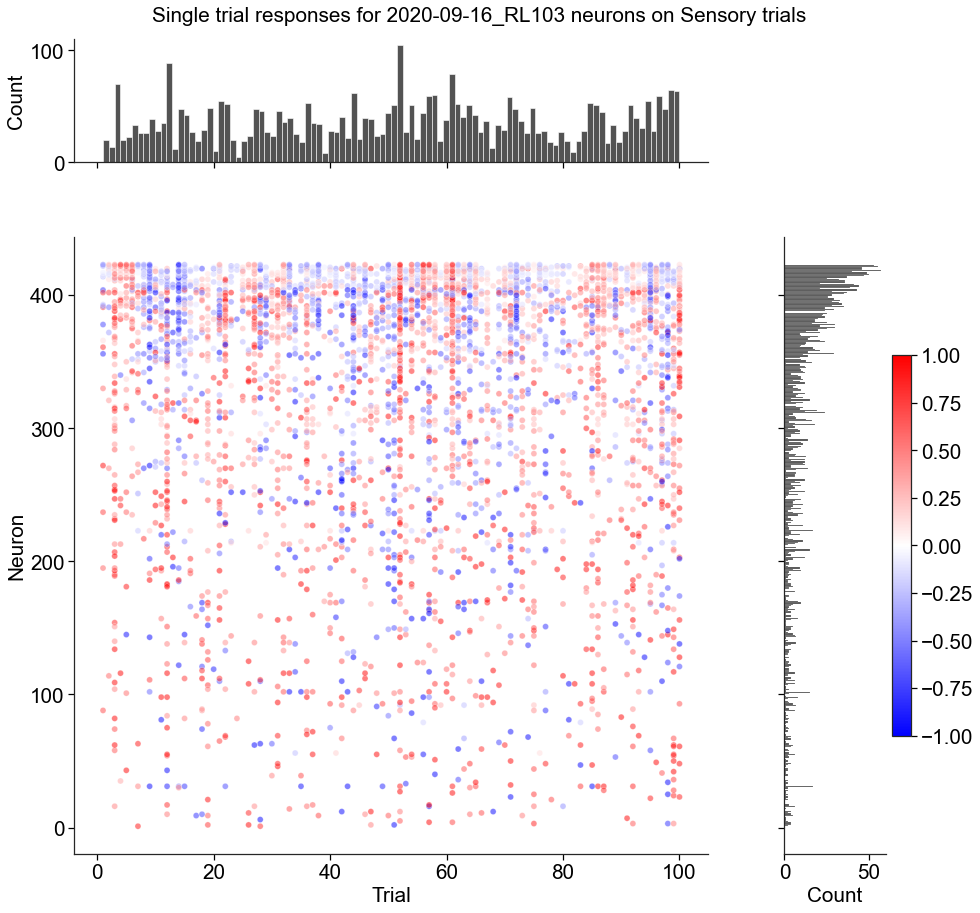

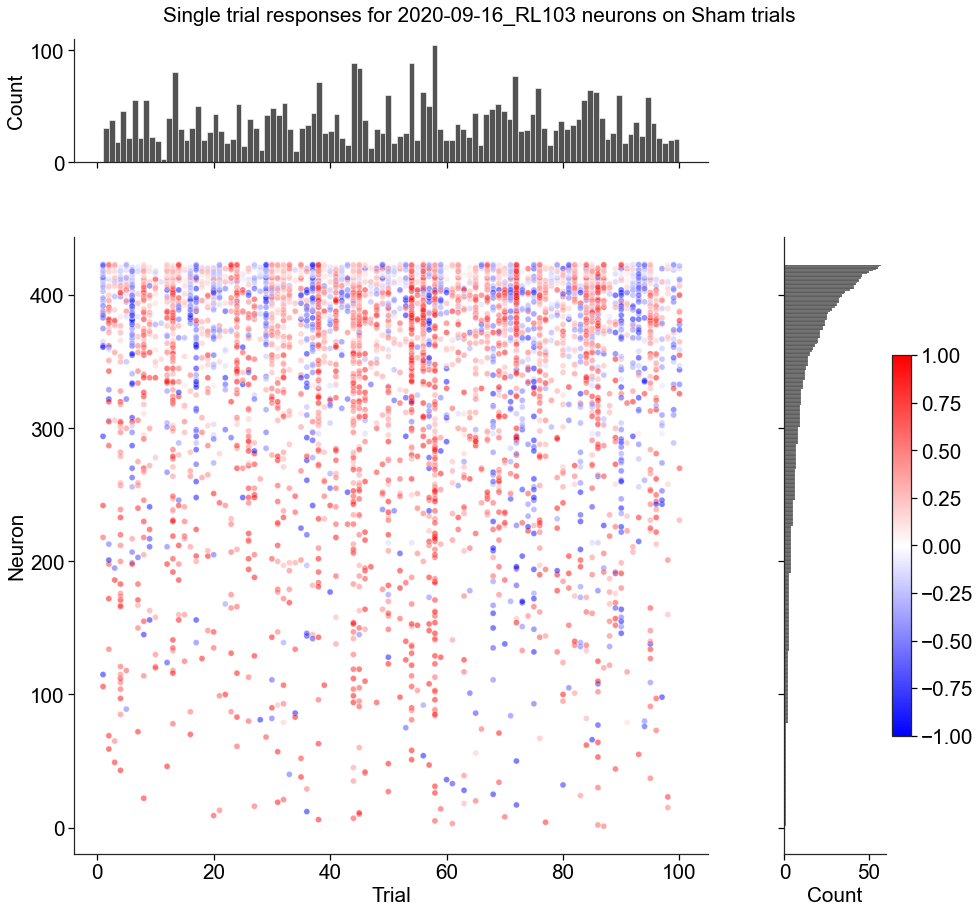

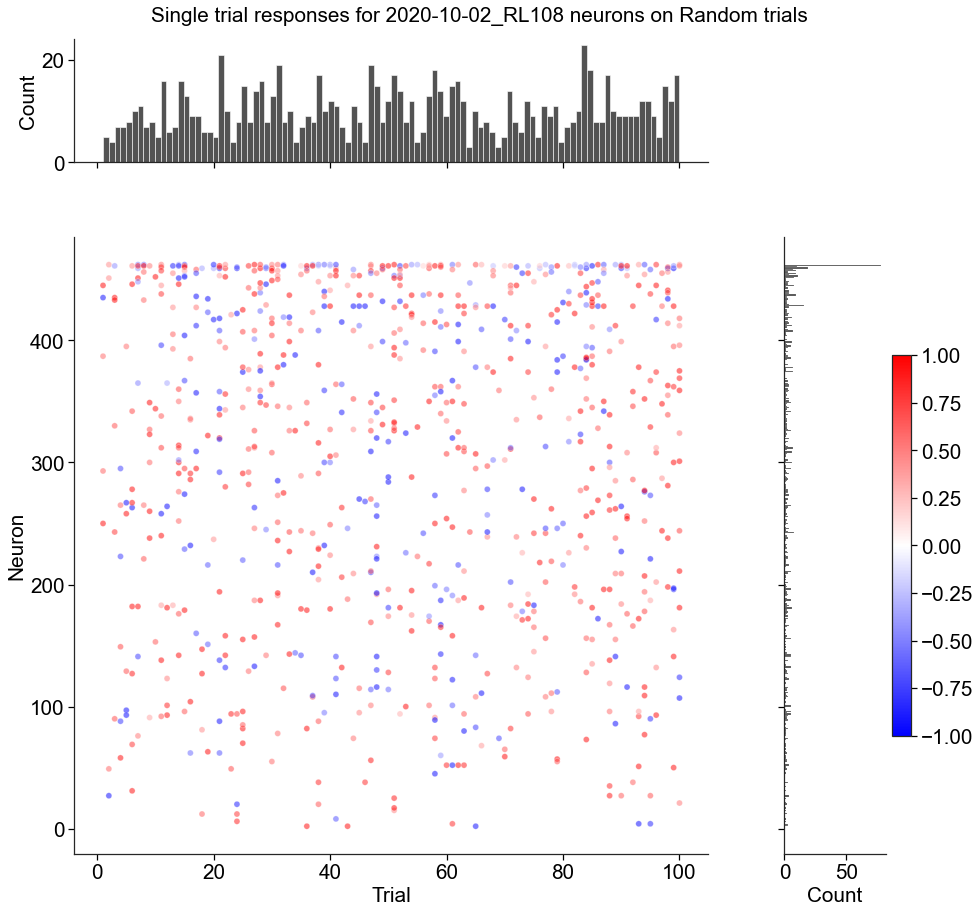

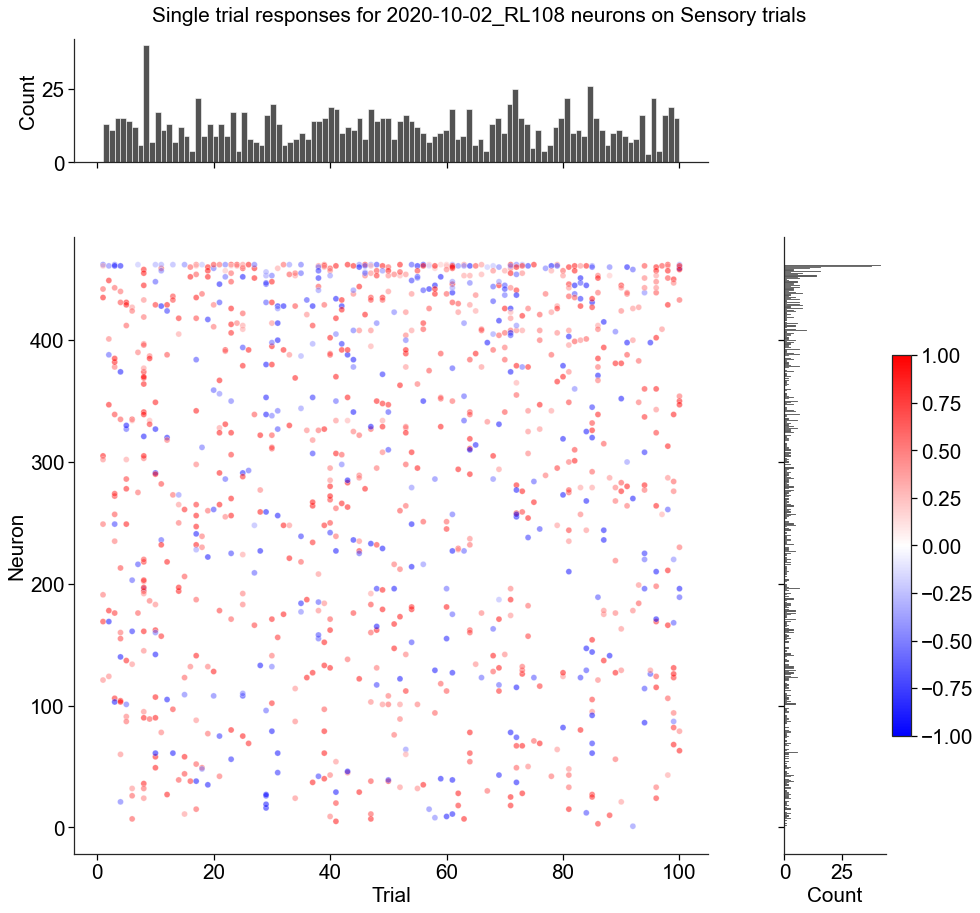

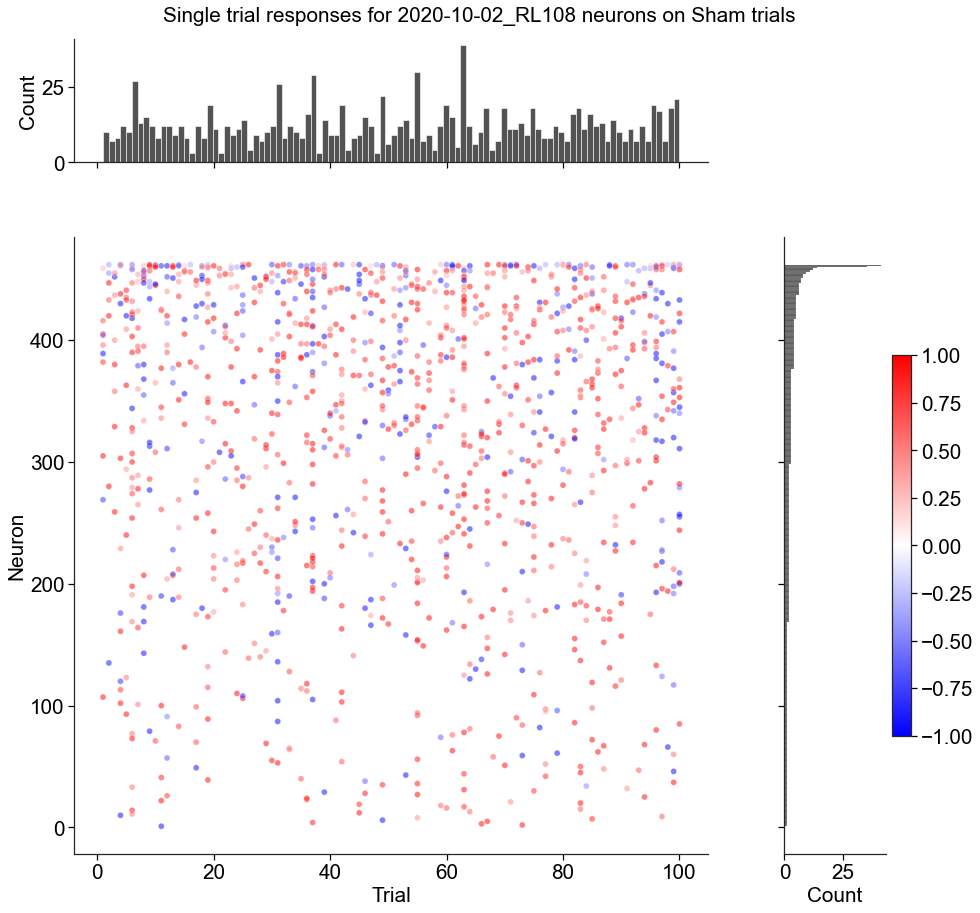

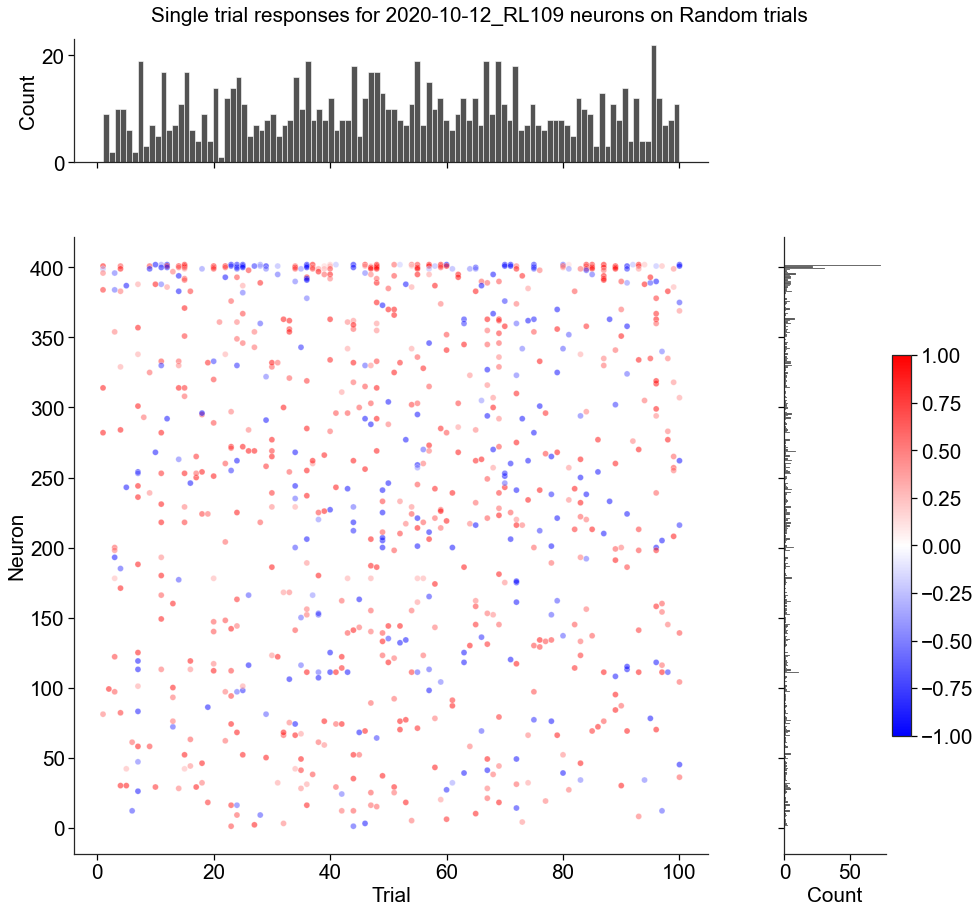

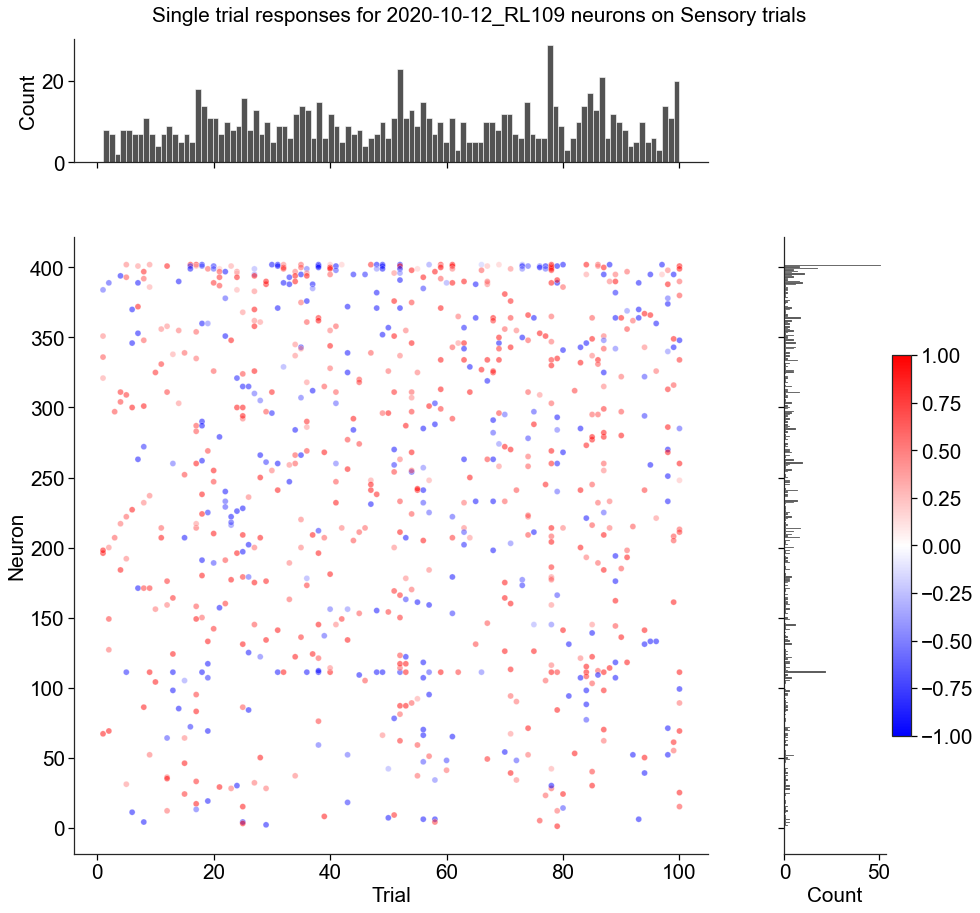

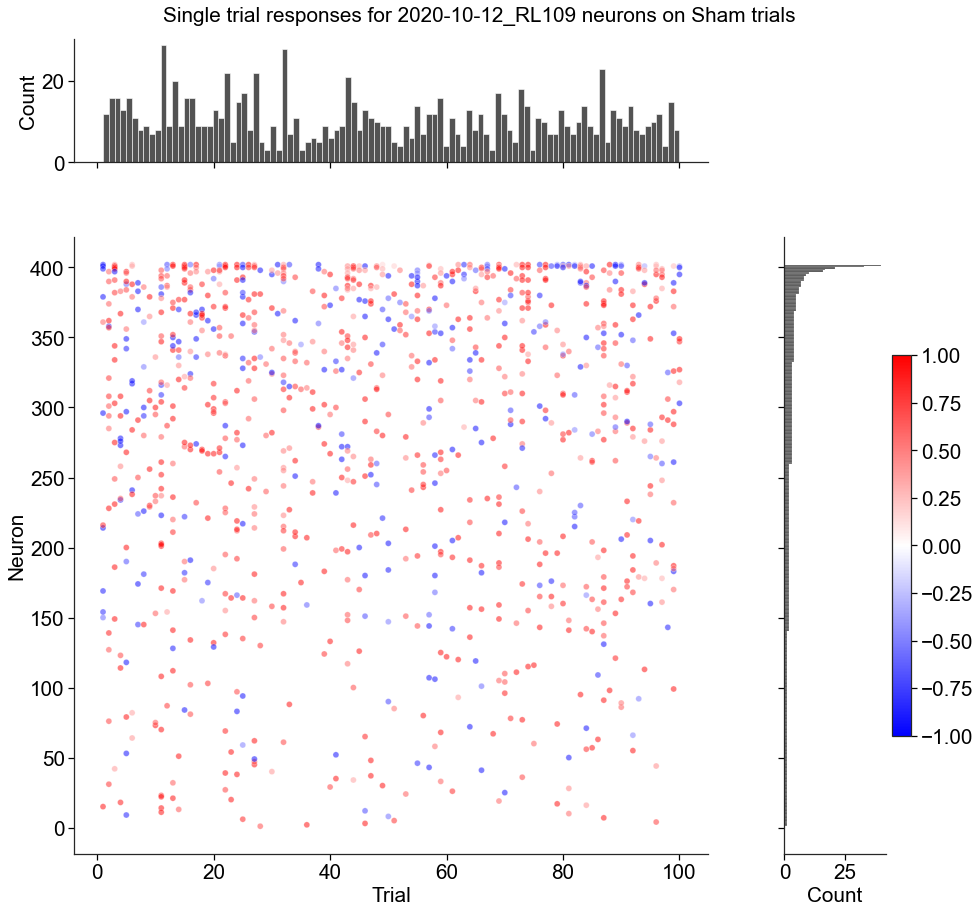

In [118]:
# PLOT SCATTER OF TRIAL X CELL IN EACH POSITION WHERE THE CELL RESPONDED ON THAT TRIAL 
# (maybe also colour according to response dF/F from -ve to +ve)
# (also plot histograms to right and above for the number of cells responding on trial and vice versa)

# query S2 cells in cell_trial_df and relevant trial response (e.g. pr or ps) x
# for each session_id in the df
# scatter x=cell, y=trial, hue=trial + '_amp_resp'
# histogram of trial nums (x-axis) and cell nums (y-axis)

s2_filter = cell_trial_df.cell_id.isin(cell_df.query('s2_cell').index)
s2_cell_trial_df = cell_trial_df[s2_filter]

for label, session_df in s2_cell_trial_df.groupby('session_id'):
    
    spont_session_df = session_df.query('trial_sig_dff_spont')
    
    # order cells by num trials responded on for spont trial type
    cell_id_sorted = spont_session_df.groupby('cell_id') \
                                     .count() \
                                     .sort_values(by='trial_sig_dff_spont')['cell_num'] \
                                     .index

    sorterIndex = dict(zip(cell_id_sorted, np.arange(1,len(cell_id_sorted)+1)))
    
    for trial_type, plot_label in zip(['pr', 'ps', 'spont'], plot_labels):
        
        fig, axes = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(15,15), gridspec_kw={'width_ratios' : (1,0.2), 'height_ratios' : (0.2,1)})
    
        s2_session_df = session_df.query('trial_sig_dff_' + trial_type).copy()
        
        # reset cell number (id) to run uninterrupted
#         unique_cell_nums = s2_session_df.cell_num.unique()
#         new_cell_nums = np.arange(1,len(unique_cell_nums)+1)
#         replace_cell_nums = dict(zip(unique_cell_nums, new_cell_nums))
        
#         s2_session_df = s2_session_df.replace({'cell_num' : replace_cell_nums})

        s2_session_df['trial_rank'] = s2_session_df['cell_id'].map(sorterIndex)
        
        response = trial_type + '_amp_resp'
        
#         sns.scatterplot(data=s2_session_df, x='trial_num', y='cell_num', legend=False, alpha=0.5,
#                         c=s2_session_df[response], cmap='bwr', vmin=-1, vmax=1, ax=axes[1,0])
        sns.scatterplot(data=s2_session_df, x='trial_num', y='trial_rank', legend=False, alpha=0.5,
                        hue=response, palette='bwr', hue_norm=(-1,1), ax=axes[1,0])
        sns.histplot(data=s2_session_df, x='trial_num', color='k', bins=100, ax=axes[0,0])
#         sns.histplot(data=s2_session_df, y='cell_num', color='k', bins=len(new_cell_nums), ax=axes[1,1])
        sns.histplot(data=s2_session_df, y='trial_rank', color='k', 
                     bins=len(s2_session_df.cell_id.unique()), ax=axes[1,1])
        
        # put colorbar in separate axis with same colormapping
        norm = plt.Normalize(-1, 1)
        sm = plt.cm.ScalarMappable(cmap='bwr', norm=norm)
        sm.set_array([])
        
        axes[0,1].axis('off')
        axes[0,1].figure.colorbar(sm)
        
        plt.suptitle(f'Single trial responses for {label} neurons on {plot_label} trials', fontsize='xx-large', y=0.91)
        axes[1,0].set_xlabel('Trial')
        axes[1,0].set_ylabel('Neuron')

        # save the figure
        save_path = f'{fig_save_path}_single_trial_response_{label}_{plot_label}'
        ia.savePlot(save_path)

In [119]:
s2_filter = cell_trial_df.cell_id.isin(cell_df.query('s2_cell').index)
s2_cell_trial_df = cell_trial_df[s2_filter]

master_cell_id_list = []

for label, session_df in s2_cell_trial_df.groupby('session_id'):
    
    spont_session_df = session_df.query('trial_sig_dff_spont')
    
    # order cells by num trials responded on for spont trial type
    cell_id_sorted = spont_session_df.groupby('cell_id') \
                                     .count() \
                                     .sort_values(by='trial_sig_dff_spont')['cell_num'] \
                                     .index[:100]
    
    master_cell_id_list.extend(cell_id_sorted)

N_numbers:
n = 6 animals


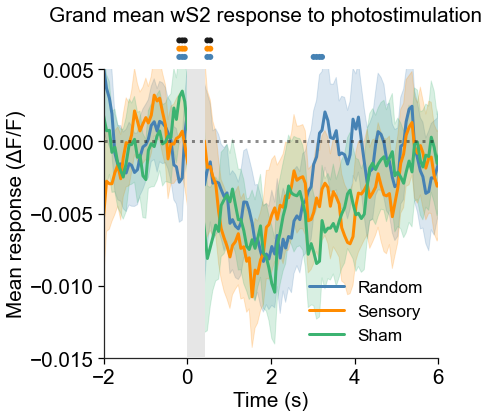

In [120]:
# GRAND AVERAGE OF TOP 100 CELLS (POSITIVE AND NEGATIVE)

target_type = ['pr_target', 'ps_target', 'pr_target']
responses = ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,6), gridspec_kw={'height_ratios': [2,20]})

n_numbers = []

n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

for label, target, response, color in zip(plot_labels, target_type, responses, plot_colors):

    # filter dataframes using variables above
#     nontargets = cell_df[~cell_df[target] & cell_df['s2_cell']].index
    
    # populate the plots with filtered data
    df_filter = cell_mean_timepoint_df['cell_id'].isin(master_cell_id_list)
    filtered_df = cell_mean_timepoint_df[df_filter].copy()
    filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
                ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
    rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]
    
    sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
                 estimator='mean', ci=95, ax=ax[1], label=label, legend=False, color=color, linewidth=plot_lw)
    
    display(fig)
    clear_output(wait = True)

# construct patch to cover stim artifact period
stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
ax[1].add_patch(stim_patch)

ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Mean response (ΔF/F)');
if sensory:
    ax[1].legend(plot_labels, loc='lower right')
else: 
    ax[1].legend(plot_labels, loc='upper right')
    
ax[1].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

if not projection:
    ax[1].set_ylim([-0.015, 0.005])
else:
    ax[1].set_ylim([-0.01, 0.01])

ax[1].set_xlim([-2, 6])

#plot stats
nontargets = cell_df[(~cell_df['ps_target'] | ~cell_df['pr_target']) & cell_df['s2_cell']].index
df_filter = cell_mean_timepoint_df['cell_id'].isin(master_cell_id_list)
temp_df = cell_mean_timepoint_df[df_filter].copy()
temp_df.loc[(temp_df['timepoint'] > 0) & (temp_df['timepoint'] <= photostim_duration), 
            ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
time_array = cell_mean_timepoint_df['timepoint'].unique()

for tt_i, (col_1, col_2, color) in enumerate(zip(['pr_sta_resp', 'ps_sta_resp', 'pr_sta_resp'],
                                                 ['spont_sta_resp', 'spont_sta_resp', 'ps_sta_resp'],
                                                 [plot_colors[0], plot_colors[1], 'k'])):
    signif_array = ia.stat_test_timepoint(temp_df, time_array, col_1=col_1, col_2=col_2, 
                                       frames_bin=4, th=0.05)
    signif_array[(time_array > -0.05) & (time_array <= patch_size + 0.05)] = np.nan
    sns.scatterplot(x=time_array, y=[tt_i * 0.02 if x_val==1 else np.nan for x_val in signif_array], 
                    ax=ax[0], color=color, edgecolor='none', lw=0, legend=False)
    clear_output(wait=True)
        
ax[0].set_ylim([-0.01, 0.02*3])
ax[0].axis('off')
plt.subplots_adjust(hspace=0.05)

plt.suptitle('Grand mean wS2 response to photostimulation', fontsize='xx-large', y=0.94)

ax[1].legend().draw_frame(False)

print('N_numbers:', *n_numbers, sep='\n')

save_path = fig_save_path + '_cell_grandaverage_s2_dff_trace_top100'
ia.savePlot(save_path)

Result for t-test: Ttest_relResult(statistic=-1.7374320837497248, pvalue=0.14281684228341032)


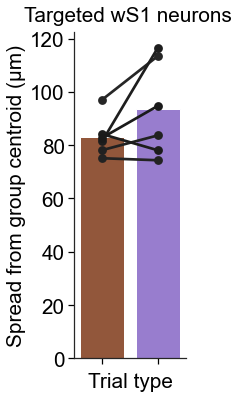

In [254]:
trials = ['pr', 'ps']

df = trial_df[trial_df.stim_type.isin(trials)]
unique_animals = len(cell_df.session_id.unique())

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(2,6))

sns.barplot(data=df, y='trial_target_euclid_dist', x='stim_type', ci=None,
            ax=axes, palette=sns.color_palette(plot_colors))
sns.pointplot(data=df, y='trial_target_euclid_dist', x='stim_type', hue='session_id',
             color='k', ax=axes, dodge=False, ci=None)

axes.set_ylabel('Spread from group centroid (μm)')

axes.set_xlabel('Trial type')

axes.legend().set_visible(False)

ax1_labels = [item.get_text() for item in axes.get_xticklabels()]
ax1_labels = ['','']

axes.set_xticklabels(ax1_labels)

plt.suptitle('Targeted wS1 neurons', fontsize='xx-large', y=0.94);

# save the figure
save_path = fig_save_path + '_target_cell_spread_mean'
ia.savePlot(save_path)

pr_avg = df.groupby(['stim_type', 'session_id']).mean().loc['pr', 'trial_target_euclid_dist']
ps_avg = df.groupby(['stim_type', 'session_id']).mean().loc['ps', 'trial_target_euclid_dist']
print(f'Result for t-test: {stats.ttest_rel(pr_avg, ps_avg)}')

Loading pickle: /home/rlees/mnt/qnap/pkl_files/sensory_2sec_test/2020-09-04_RL093.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/sensory_2sec_test/2020-09-08_RL099.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/sensory_2sec_test/2020-09-14_RL101.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/sensory_2sec_test/2020-09-16_RL103.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/sensory_2sec_test/2020-10-02_RL108.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/sensory_2sec_test/2020-10-12_RL109.pkl
[47.83491331013802, 42.19820908725848, 82.07903784011759, 112.52164212216317, 95.13584505263366, 176.5084482135241]


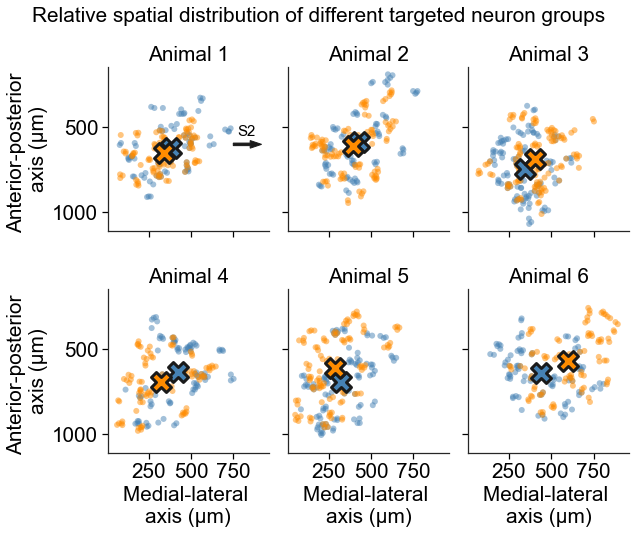

In [173]:
# plot difference between target cloud centroids

stim_types = ['pr', 'ps']
pkl_files = ia.listdirFullpath(os.path.join(pkl_folder, session_type), string='.pkl')
if sensory:
    pkl_files = [file for file in pkl_files if not any(s in file for s in remove_list)]
dist = []

session_ids = cell_trial_df['session_id'].unique()   
ncols = np.round(len(session_ids)/2).astype('int')

if not projection:
    fig, axes = plt.subplots(nrows=2, ncols=ncols, sharex=True, sharey=True, figsize=(3*ncols, 9))
else:
    fig, axes = plt.subplots(nrows=2, ncols=ncols, sharey=True, sharex=True, figsize=(3*ncols, 9))

cloud_axes = axes.flatten()

for i, pkl in enumerate(pkl_files):
    
    ses_obj = ia.loadPickle(pkl)
    
    exp_list = ia.makeExpList(ses_obj, stim_types)
    
    coords = []
    
    for exp_obj, color in zip(exp_list, plot_colors):
        
        cell_meds = np.array(exp_obj.cell_med[0])*exp_obj.pix_sz_x
        target_cell_meds = cell_meds[exp_obj.targeted_cells]
        
        x = target_cell_meds[:,1].mean()
        y = target_cell_meds[:,0].mean()
        
        cloud_axes[i].scatter(target_cell_meds[:,1], target_cell_meds[:,0], zorder=-1, 
                              edgecolors='none', color=color, alpha=0.5)
        cloud_axes[i].scatter(x, y, marker='X', linewidth=plot_lw, edgecolors='k', s=400, color=color)
        
        cloud_axes[i].set_title('Animal ' + str(i+1))
        
        coords.append([x,y])
    
    dist_x = coords[0][0] - coords[1][0]
    dist_y = coords[0][1] - coords[1][1]
    
    dist.append(np.sqrt(dist_x**2 + dist_y**2))
    
for row, row_ax in enumerate(axes):
    for col, col_ax in enumerate(row_ax):
        if col == 0: col_ax.set_ylabel('Anterior-posterior \naxis (μm)')
        if row == 1: col_ax.set_xlabel('Medial-lateral \naxis (μm)')
        col_ax.set_aspect('equal')
        
        if (row==0) and (col==0): 
            col_ax.arrow(750, 600, 100, 0, width=15, color='k')
            col_ax.text(775, 550, 'S2', fontsize=15)

axes[0,0].invert_yaxis()

fig.tight_layout(h_pad=-8)

if projection:
    plt.suptitle('Relative spatial distribution of different targeted neuron groups', fontsize='xx-large', y=0.85)
if sensory: 
    plt.suptitle('Relative spatial distribution of different targeted neuron groups', fontsize='xx-large', y=0.92)
    
print(dist)

save_path = fig_save_path + '_target_group_centroid_positions'
ia.savePlot(save_path)

In [123]:
# df = pd.DataFrame()

# unique_animals = len(cell_df.session_id.unique())

# targets = ['pr_target', 'ps_target']

# for target in targets:
#     target_df = cell_df.query(target)
    
#     num_targets = target_df.groupby('session_id')[target].count()

#     session_labels = [session_id[-5:] for session_id in target_df['session_id'].unique()]

#     temp_df = pd.DataFrame({'target_type' : np.repeat(target, len(num_targets)),
#                             'num_targets' : num_targets,
#                             'session_id' : session_labels
#                            })
    
#     df = pd.concat([df, temp_df])
    
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6), sharey=True, gridspec_kw={'width_ratios':(4, 1)})

# sns.barplot(data=df, x='session_id', y='num_targets', hue='target_type', 
#             ax=axes[0], palette=sns.color_palette(plot_colors));
# sns.barplot(data=df, y='num_targets', x='target_type', 
#             ax=axes[1], palette=sns.color_palette(plot_colors));

# for ax in axes:
#     ax.set_ylabel('Number of targeted cells');
    
# axes[0].set_xlabel('Animal')
# axes[1].set_xlabel('Trial type')

# axes[0].set_title('All animals')
# axes[1].set_title('Mean')

# axes[0].legend().set_visible(False)
# axes[1].set_ylabel('')

# ax0_labels = [item.get_text() for item in axes[0].get_xticklabels()]
# ax0_labels = list(range(1,unique_animals+1))

# axes[0].set_xticklabels(ax0_labels)

# ax1_labels = [item.get_text() for item in axes[1].get_xticklabels()]
# ax1_labels = ['','']

# axes[1].set_xticklabels(ax1_labels)

# plt.suptitle('Total number of cells targeted by photostimulus', fontsize='xx-large', y=1);

# # save the figure
# save_path = fig_save_path + '_target_cell_group_size'
# ia.savePlot(save_path)

Result for t-test: Ttest_relResult(statistic=-2.598076211353316, pvalue=0.04836185235458744)


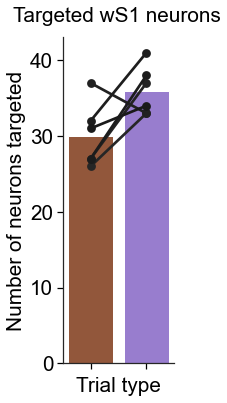

In [255]:
df = pd.DataFrame()

unique_animals = len(cell_df.session_id.unique())

targets = ['pr_target', 'ps_target']

for target in targets:
    target_df = cell_df.query(target)
    
    num_targets = target_df.groupby('session_id')[target].count()

    session_labels = [session_id[-5:] for session_id in target_df['session_id'].unique()]

    temp_df = pd.DataFrame({'target_type' : np.repeat(target, len(num_targets)),
                            'num_targets' : num_targets,
                            'session_id' : session_labels
                           })
    
    df = pd.concat([df, temp_df])
    
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(2,6))

sns.barplot(data=df, y='num_targets', x='target_type', ci=None, 
            ax=axes, palette=sns.color_palette(plot_colors), zorder=-1);
sns.pointplot(data=df, x="target_type", y="num_targets", hue='session_id', color='k', dodge=False)
axes.legend().set_visible(False)

axes.set_ylabel('Number of neurons targeted');
axes.set_xlabel('Trial type')

ax1_labels = [item.get_text() for item in axes.get_xticklabels()]
ax1_labels = ['','']

axes.set_xticklabels(ax1_labels)

plt.suptitle('Targeted wS1 neurons', fontsize='xx-large', y=0.95);

# save the figure
save_path = fig_save_path + '_target_cell_group_size_mean'
ia.savePlot(save_path)

df.reset_index(drop=True, inplace=True)
pr_avg = df.groupby(['target_type', 'session_id']).mean().loc['pr_target', 'num_targets']
ps_avg = df.groupby(['target_type', 'session_id']).mean().loc['ps_target', 'num_targets']
print(f'Result for t-test: {stats.ttest_rel(pr_avg, ps_avg)}')

In [125]:
# targets = ['pr_target', 'ps_target']
# trials = ['pr', 'ps']

# unique_animals = len(cell_df.session_id.unique())

# fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,12), gridspec_kw={'width_ratios':(4, 1)})

# for i, (trial, label, ax) in enumerate(zip(trials, plot_labels, axes)):

#     df = pd.DataFrame()

#     for target in targets:

#         target_df = cell_df.query(target)

#         mean_resp_target = target_df.groupby('session_id').mean()[trial + '_sta_amp_resp']
#         session_labels = mean_resp_target.groupby('session_id').mean().index.to_numpy()

#     #     ctb_positive_filter = cell_mean_timepoint_df.cell_id.isin(ctb_positive_targets)
#     #     ctb_positive_df = cell_mean_timepoint_df[ctb_positive_filter]

#     #     ctb_negative_filter = cell_mean_timepoint_df.cell_id.isin(ctb_negative_targets)
#     #     ctb_negative_df = cell_mean_timepoint_df[ctb_negative_filter]

#         temp_df = pd.DataFrame({'mean_resp' : mean_resp_target,
#                                 'Target type' : np.repeat(target, len(mean_resp_target)),
#                                 'session_id' : [session_label[-5:] for session_label in session_labels]
#                                })

#         df = pd.concat([df, temp_df])

#     sns.barplot(data=df, x='session_id', y='mean_resp', hue='Target type', 
#                 palette=sns.color_palette(plot_colors), ax=ax[0])
#     sns.barplot(data=df, y='mean_resp', x='Target type', 
#                 palette=sns.color_palette(plot_colors), ax=ax[1])

#     ax[0].set_title(label + ' trial type (all animals)')
#     ax[0].set_ylabel('Mean targeted cell response (ΔF/F)')
#     ax[0].set_xlabel('Animal')

#     ax[1].set_ylabel('')
#     ax[1].set_title('Mean')

#     ax0_labels = [item.get_text() for item in ax[0].get_xticklabels()]
#     ax0_labels = list(range(1,unique_animals+1))

#     ax[0].set_xticklabels(ax0_labels)

#     ax1_labels = [item.get_text() for item in ax[1].get_xticklabels()]
#     ax1_labels = ['','']

#     ax[1].set_xticklabels(ax1_labels)

#     ax[0].legend().set_visible(False)

# plt.suptitle('S1 targeted cell responses to each trial type', fontsize='xx-large', y=0.94);
# plt.subplots_adjust(hspace=0.35)

# # save the figure
# save_path = fig_save_path + '_target_cell_group_response_by_trialtype'
# ia.savePlot(save_path)

Result for t-test pr vs ps on pr trials: Ttest_relResult(statistic=6.082733224339031, pvalue=0.0017362435402856313)
Result for t-test pr vs ps on ps trials: Ttest_relResult(statistic=-4.164857231707589, pvalue=0.008782658857922364)


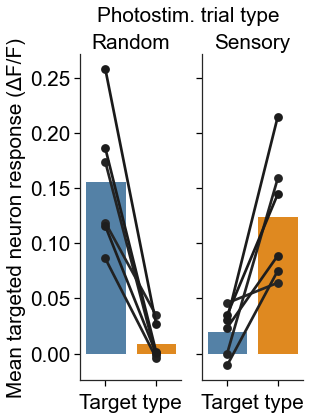

In [175]:
targets = ['pr_target', 'ps_target']
trials = ['pr', 'ps']

unique_animals = len(cell_df.session_id.unique())

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(4,6))

for i, (trial, label, ax) in enumerate(zip(trials, plot_labels, axes)):

    df = pd.DataFrame()

    for target in targets:

        target_df = cell_df.query(target)

        mean_resp_target = target_df.groupby('session_id').mean()[trial + '_sta_amp_resp']
        session_labels = mean_resp_target.groupby('session_id').mean().index.to_numpy()

    #     ctb_positive_filter = cell_mean_timepoint_df.cell_id.isin(ctb_positive_targets)
    #     ctb_positive_df = cell_mean_timepoint_df[ctb_positive_filter]

    #     ctb_negative_filter = cell_mean_timepoint_df.cell_id.isin(ctb_negative_targets)
    #     ctb_negative_df = cell_mean_timepoint_df[ctb_negative_filter]

        temp_df = pd.DataFrame({'mean_resp' : mean_resp_target,
                                'Target type' : np.repeat(target, len(mean_resp_target)),
                                'session_id' : [session_label[-5:] for session_label in session_labels]
                               })

        df = pd.concat([df, temp_df])

    sns.barplot(data=df, y='mean_resp', x='Target type', 
                palette=sns.color_palette(plot_colors), ax=ax, ci=None, zorder=-1)
    sns.pointplot(data=df, x='Target type', y='mean_resp', hue='session_id', color='k', dodge=False,
                 ax=ax)
    
    if label == 'Non-wS2-projecting':
        label = 'Non-wS2-proj.'
    if label == 'wS2-projecting':
        label = 'wS2-proj.'
    ax.set_title(label)
    
    df.reset_index(drop=True, inplace=True)
    pr_avg = df.groupby(['Target type', 'session_id']).mean().loc['pr_target', 'mean_resp']
    ps_avg = df.groupby(['Target type', 'session_id']).mean().loc['ps_target', 'mean_resp']
    print(f'Result for t-test pr vs ps on {trial} trials: {stats.ttest_rel(pr_avg, ps_avg)}')

axes[0].set_ylabel('Mean targeted neuron response (ΔF/F)')

axes[1].set_ylabel('')

ax0_labels = [item.get_text() for item in axes[0].get_xticklabels()]
ax0_labels = ['','']

axes[0].set_xticklabels(ax0_labels)

ax1_labels = [item.get_text() for item in axes[1].get_xticklabels()]
ax1_labels = ['','']

axes[1].set_xticklabels(ax1_labels)

axes[0].legend().set_visible(False)
axes[1].legend().set_visible(False)

plt.suptitle('Photostim. trial type', fontsize='xx-large', y=0.99);

# save the figure
save_path = fig_save_path + '_target_cell_group_response_by_trialtype_mean'
ia.savePlot(save_path)

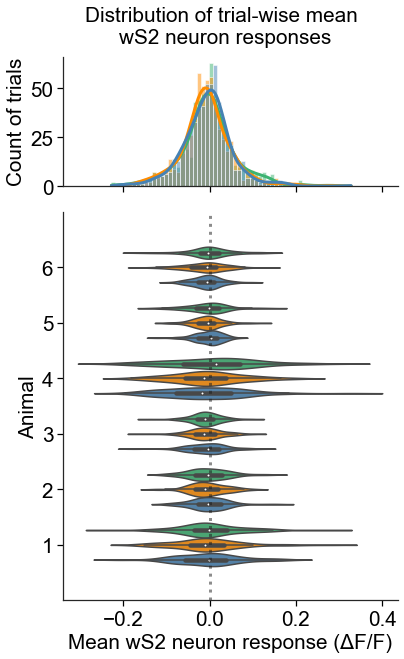

In [127]:
target_types = ['pr', 'ps', 'pr']
trial_types = ['pr', 'ps', 'spont']

unique_animals = len(cell_df.session_id.unique())

df = pd.DataFrame()

for target, trial in zip(target_types, trial_types):

    s2_nontarget_cell_ids = cell_df.query('~' + target + '_target & s2_cell').index
    
    cell_id_list = [s2_nontarget_cell_ids]
    
    for i, cell_ids in enumerate(cell_id_list):
        
        cell_filter = cell_trial_df['cell_id'].isin(cell_ids)
        filtered_df = cell_trial_df[cell_filter]
        
        mean_df = filtered_df.groupby(['session_id', 'trial_num']).mean().reset_index(drop=False)
        temp_df = pd.DataFrame({'session_id' : mean_df['session_id'],
                                'trial_num' : mean_df['trial_num'],
                                'trial_type' : np.repeat(trial, len(mean_df)),
                                'mean_activity' : mean_df[trial + '_amp_resp']
                               })
        df = pd.concat([df, temp_df])
        
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,10), gridspec_kw={'height_ratios':(1, 3)})

# top plot
s2_cell_ids = cell_df.query('s2_cell').index
s2_df = cell_trial_df[cell_trial_df['cell_id'].isin(s2_cell_ids)]
long_df = s2_df.reset_index(drop=False).melt(id_vars=['trial_num', 'session_id'], 
                                             value_vars=['pr_amp_resp', 'ps_amp_resp', 'spont_amp_resp'])
summed_df = long_df.groupby(['trial_num', 'session_id', 'variable']).mean()

summed_df[summed_df['value']==0] = np.nan

sns.histplot(kde=True, data=summed_df.reset_index(), x='value',
             hue='variable', palette=sns.color_palette(plot_colors), ax=axes[0], legend=False,
             line_kws={'linewidth': plot_lw});

axes[0].set_xlabel('')
axes[0].set_ylabel('Count of trials')

#bottom plot
session_ids = cell_df['session_id'].unique()
animal_ids = [session_id.split('_')[-1] for session_id in session_ids]

# sns.swarmplot(x='session_id', y='mean_activity', hue='trial_type', size=3, dodge=True, data=df, 
#               ax=axes, color='k')
sns.violinplot(y='session_id', x='mean_activity', hue='trial_type', size=3, dodge=True, data=df, 
               ax=axes[1], palette=sns.color_palette(plot_colors))

axes[1].set_yticklabels(animal_ids)
axes[1].set_xlabel('Mean wS2 neuron response (ΔF/F)')
axes[1].legend().set_visible(False)

ax0_labels = [item.get_text() for item in axes[1].get_yticklabels()]
ax0_labels = list(range(1,unique_animals+1))

axes[1].set_yticklabels(ax0_labels)
axes[1].set_ylabel('Animal')

axes[1].vlines(0, -1, 17, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);
axes[1].set_ylim([-1, unique_animals]);

plt.subplots_adjust(hspace=0.1)

plt.suptitle('Distribution of trial-wise mean \nwS2 neuron responses', fontsize='xx-large', y=0.95);

# save the figure
save_path = fig_save_path + '_s2_cell_mean_activity_trialwise_animalwise'
ia.savePlot(save_path)

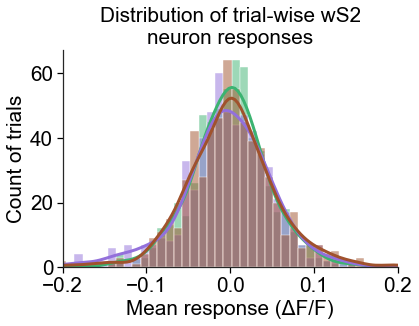

In [233]:
# PLOT DISTRIBUTION OF SUMMED S2 TRIAL RESPONSES

s2_cell_ids = cell_df.query('s2_cell').index
s2_df = cell_trial_df[cell_trial_df['cell_id'].isin(s2_cell_ids)]
long_df = s2_df.reset_index(drop=False).melt(id_vars=['trial_num', 'session_id'], 
                                             value_vars=['pr_amp_resp', 'ps_amp_resp', 'spont_amp_resp'])
summed_df = long_df.groupby(['trial_num', 'session_id', 'variable']).mean()

summed_df[summed_df['value']==0] = np.nan

sns.histplot(kde=True, data=summed_df.reset_index(), x='value',
             hue='variable', palette=sns.color_palette(plot_colors), 
             legend=False, line_kws={'linewidth': plot_lw});

# axes = plt.gca()
# box = axes.get_position()
# axes.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# axes.legend(plot_labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.axis([-0.2, 0.2, None, None])
plt.xlabel('Mean response (ΔF/F)')
plt.ylabel('Count of trials')
plt.title('Distribution of trial-wise wS2\nneuron responses');

# save the figure
save_path = fig_save_path + '_distribution_s2_cell_responses_trial'
ia.savePlot(save_path)

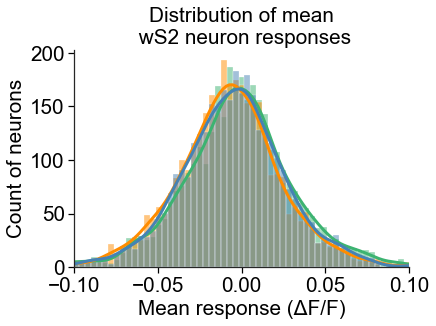

In [129]:
# PLOT DISTRIBUTION OF S2 CELL RESPONSES

s2_df = cell_df.query('s2_cell').reset_index(drop=False)
temp_df = s2_df.melt(id_vars='cell_id', value_vars=['pr_sta_amp_resp', 'ps_sta_amp_resp', 'spont_sta_amp_resp'])
sns.histplot(kde=True, data=temp_df, x='value', hue='variable', 
             palette=sns.color_palette(plot_colors), legend=False, line_kws={'linewidth': plot_lw})

# axes = plt.gca()
# box = axes.get_position()
# axes.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# axes.legend(plot_labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.axis([-0.1, 0.1, None, None])
plt.xlabel('Mean response (ΔF/F)')
plt.ylabel('Count of neurons')
plt.title('Distribution of mean\n wS2 neuron responses');

# save the figure
save_path = fig_save_path + '_distribution_s2_cell_responses_cell'
ia.savePlot(save_path)

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


trial: Non-wS2-projecting slope 0.15240383090312234 r_value 0.15240383068878482 p_value 0.00017878888864072444


/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


trial: wS2-projecting slope 0.2659194586891544 r_value 0.2659194656951214 p_value 3.6008241058547494e-11


/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


trial: Sham slope 0.23059680061074878 r_value 0.23059679761854973 p_value 1.1044973281360097e-08


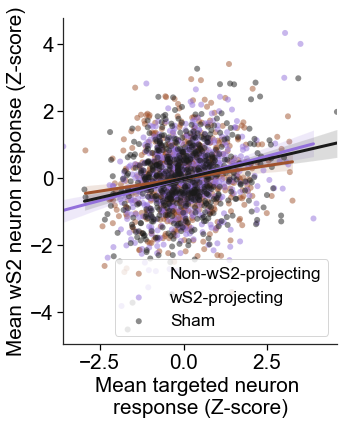

In [265]:
# Z SCORING

responses = ['pr_amp_resp', 'ps_amp_resp', 'spont_amp_resp']
targets = ['pr_target', 'ps_target', 'pr_target']

colors = plot_colors[:2]
colors.append('k')

# create and populate the plots using filtered data
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(6,6))

for response, target, label, color in zip(responses, targets, plot_labels, colors):
    
    s2_cell_ids = cell_df.query('s2_cell & ~' + target).index
    target_cell_ids = cell_df.query(target).index
#     target_cell_ids = cell_df.query('s2_cell & ~' + target).index

    target_filter = cell_trial_df['cell_id'].isin(target_cell_ids)
    target_df = cell_trial_df[target_filter].dropna(axis=0, subset=[response])
    target_amp_resp = target_df.groupby(['trial_num','session_id']).mean()
    target_amp_resp = target_amp_resp.groupby('session_id').transform(lambda x : stats.zscore(x, ddof=1))[response]

    s2_filter = cell_trial_df['cell_id'].isin(s2_cell_ids)
    s2_df = cell_trial_df[s2_filter].dropna(axis=0, subset=[response])
    s2_amp_resp = s2_df.groupby(['trial_num','session_id']).mean()
    s2_amp_resp = s2_amp_resp.groupby('session_id').transform(lambda x : stats.zscore(x, ddof=1))[response]

    df = pd.DataFrame({'target_amp_resp' : target_amp_resp,
                       's2_amp_resp'     : s2_amp_resp})

    df = df.reset_index(drop=False)
    
    sns.regplot(x=df['target_amp_resp'], y=df['s2_amp_resp'], 
                data=df, ax=axes, label=label, color=color, scatter_kws={'alpha': 0.5, 'edgecolor' : 'none'},
                line_kws={'linewidth' : plot_lw})
    
    axes.legend()
    axes.set_ylabel('Mean wS2 neuron response (Z-score)')
    axes.set_xlabel('Mean targeted neuron \nresponse (Z-score)')

    axes.set_aspect('equal')
    
    slope, _, r_value, p_value, _ = stats.linregress(x=df['target_amp_resp'], 
                                                     y=df['s2_amp_resp'])
    print('trial:', label,
          'slope', slope,
          'r_value', r_value,
          'p_value', p_value
         )
            
# plt.suptitle('Trial-wise mean targeted neuron \nvs. wS2 neuron responses', y=0.96, 
#          fontsize='xx-large');

# save the figure
save_path = fig_save_path + '_target_s2_activity_correlation_trialwise_zscore'
ia.savePlot(save_path)

N_numbers:
n = 3358 non-target s2 cells for pr
n = 3358 non-target s2 cells for ps


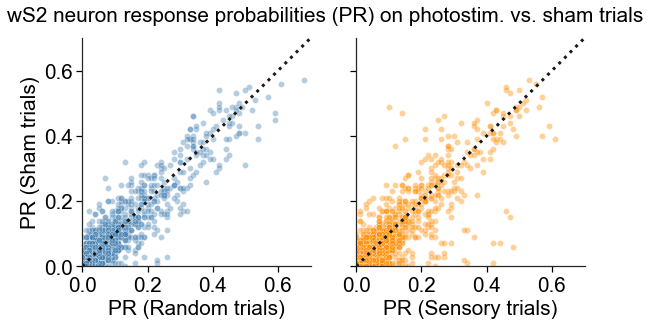

In [131]:
trials = ['pr', 'ps']

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(9,6))

n_numbers = []

for i, (trial, ax, label, color) in enumerate(zip(trials, axes, plot_labels, plot_colors)):
    df = cell_df.query('~' + trial + '_target & s2_cell')

#     sns.histplot(x='prob_response_'+trial, y='prob_response_spont',
#                  data=df, ax=ax, binwidth=(0.01,0.01), cbar=True, 
#                  cbar_kws={'shrink':.75, 'label': 'Number of cells', 'orientation':'horizontal', 'extend':'max'}, 
#                  vmin=0, vmax=100, color='k')
    sns.scatterplot(x='prob_response_'+trial, y='prob_response_spont', data=df, ax=ax, 
                    alpha=0.4, color=color)
#     sns.regplot(x='prob_response_'+trial, y='prob_response_spont', data=df, ax=ax,
#                 line_kws={'color': 'k'}, scatter_kws={'color': color, 'alpha' : 0.4})
    ax.set_aspect('equal')
    ax.axis([0,0.7,0,0.7]);
    
    ax.set_xlabel(f'PR ({label} trials)')
    ax.set_ylabel('PR (Sham trials)')
    
    ax.plot([0,1],[0,1], 'k', linestyle='dotted', lw=3)
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    
    n_numbers.append(f'n = {len(df.index.unique())} non-target s2 cells for {trial}')

plt.suptitle('wS2 neuron response probabilities (PR) on photostim. vs. sham trials', 
             y=0.84, fontsize='xx-large');

print('N_numbers:', *n_numbers, sep='\n')

# save the figure
save_path = fig_save_path + '_s2_cell_response_probability'
ia.savePlot(save_path)

N_numbers:
n = 1889 non-target s2 cells for pr
n = 2035 non-target s2 cells for ps


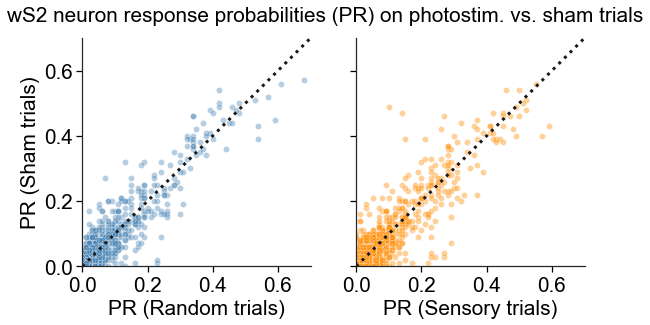

In [132]:
trials = ['pr', 'ps']

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(9,6))

n_numbers = []

for i, (trial, ax, label, color) in enumerate(zip(trials, axes, plot_labels, plot_colors)):
    df = cell_df.query('~' + trial + '_target & ~' + trial + '_resp_sign & s2_cell')
    
#     sns.histplot(x='prob_response_'+trial, y='prob_response_spont',
#                  data=df, ax=ax, binwidth=(0.01,0.01), cbar=True, 
#                  cbar_kws={'shrink':.75, 'label': 'Number of cells', 'orientation':'horizontal', 'extend':'max'}, 
#                  vmin=0, vmax=100, color='k')
    sns.scatterplot(x='prob_response_'+trial, y='prob_response_spont', data=df, ax=ax, 
                    alpha=0.4, color=color)
#     sns.regplot(x='prob_response_'+trial, y='prob_response_spont', data=df, ax=ax,
#                 line_kws={'color': 'k'}, scatter_kws={'color': color, 'alpha' : 0.4})
    ax.set_aspect('equal')
    ax.axis([0,0.7,0,0.7]);
    
    ax.set_xlabel(f'PR ({label} trials)')
    ax.set_ylabel('PR (Sham trials)')
    
    ax.plot([0,1],[0,1], 'k', linestyle='dotted', lw=3)
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    
    n_numbers.append(f'n = {len(df.index.unique())} non-target s2 cells for {trial}')

plt.suptitle('wS2 neuron response probabilities (PR) on photostim. vs. sham trials', 
             y=0.84, fontsize='xx-large');

print('N_numbers:', *n_numbers, sep='\n')

# save the figure
save_path = fig_save_path + '_s2_cell_response_probability_negativeonly'
ia.savePlot(save_path)

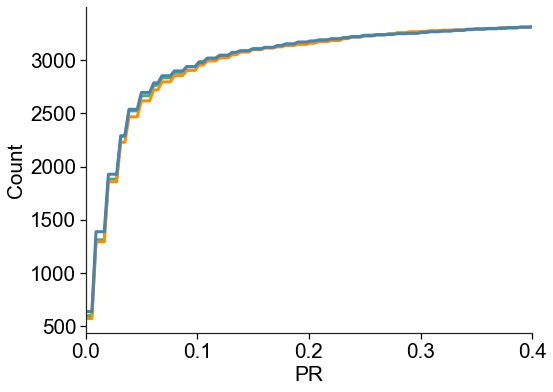

In [133]:
trials = ['pr', 'ps', 'spont']
targets = ['pr', 'ps', 'pr']

df = pd.DataFrame()

for i, (trial, target, color, label) in enumerate(zip(trials, targets, plot_colors, plot_labels)):
    
    non_target_df = cell_df.query('~' + target + '_target & s2_cell')
    bias = non_target_df['prob_response_' + trial]
    
    temp_df = pd.DataFrame({'Trial type' : np.repeat(label, len(bias)),
                            'PR' : bias
                           })
    
    df = pd.concat([df, temp_df])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

# HISTOGRAM
# sns.kdeplot(cumulative=True, hue='Trial type', palette=sns.color_palette(plot_colors), x='PR', 
#             statistic='count', data=df, ax=ax, clip = (0, 1))
sns.histplot(hue='Trial type', x='PR', cumulative=True, fill=False, linewidth=plot_lw, legend=False,
             element='poly', data=df, ax=ax, palette=sns.color_palette(plot_colors))
# sns.histplot(kde=True, hue='Trial type', x='PR', legend=False, data=df, ax=ax, palette=sns.color_palette(plot_colors))
ax.set_xlim([0, 0.4]);

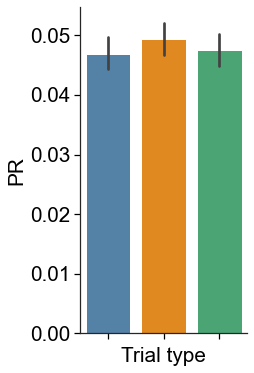

In [134]:
trials = ['pr', 'ps', 'spont']
targets = ['pr', 'ps', 'pr']

df = pd.DataFrame()

for i, (trial, target, color, label) in enumerate(zip(trials, targets, plot_colors, plot_labels)):
    
    non_target_df = cell_df.query('~' + target + '_target & s2_cell')
    bias = non_target_df['prob_response_' + trial]
    
    temp_df = pd.DataFrame({'Trial type' : np.repeat(label, len(bias)),
                            'PR' : bias
                           })
    
    df = pd.concat([df, temp_df])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,6))

sns.barplot(y='PR', x='Trial type', palette=sns.color_palette(plot_colors), data=df)
ax.set_xticklabels(['','','']);

# save the figure
save_path = fig_save_path + '_s2_cell_response_probability_mean'
ia.savePlot(save_path)

In [135]:
df = cell_df.query('s2_cell')

prob_resp_pr = df['prob_response_pr']
prob_resp_ps = df['prob_response_ps']
prob_resp_sham = df['prob_response_spont']

mean_pr = np.mean(prob_resp_pr)
mean_ps = np.mean(prob_resp_ps)
mean_sham = np.mean(prob_resp_sham)

print(f'mean for Random: {mean_pr} \nmean for Sensory: {mean_ps} \nmean for Sham: {mean_sham}')
print(stats.wilcoxon(prob_resp_pr, prob_resp_sham), 'pr vs. sham')
print(stats.wilcoxon(prob_resp_ps, prob_resp_sham), 'ps vs. sham')
print(stats.wilcoxon(prob_resp_ps, prob_resp_pr), 'pr vs. ps')

mean for Random: 0.046941631923764146 
mean for Sensory: 0.049359737939249554 
mean for Sham: 0.04757593805836807
WilcoxonResult(statistic=1671281.0, pvalue=0.06144971818140648) pr vs. sham
WilcoxonResult(statistic=1776192.0, pvalue=0.12016469827408402) ps vs. sham
WilcoxonResult(statistic=1576276.0, pvalue=8.296114285888761e-06) pr vs. ps


# Specific analyses for sensory photostim. trial type

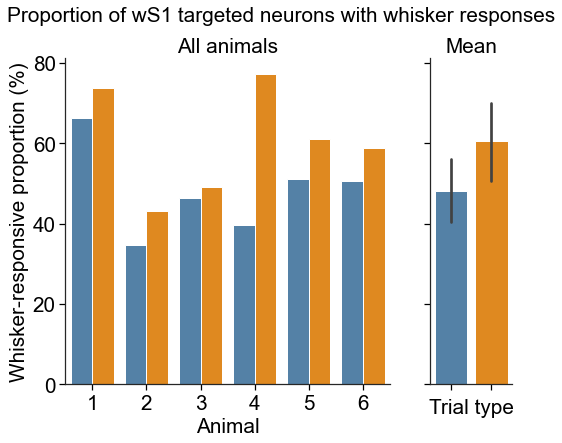

In [136]:
if sensory:
    df = pd.DataFrame()

    unique_animals = len(cell_df.session_id.unique())

    targets = ['pr_target', 'ps_target']

    for target in targets:
        target_df = cell_df.query(target)
        sr_target_df = cell_df.query(target + ' & sta_sig_whisker')

        num_sr_targets = sr_target_df.groupby('session_id')[target].count()
        num_targets = target_df.groupby('session_id')[target].count()

        percent_targets_sr = num_sr_targets/num_targets * 100
        session_labels = [session_id[-5:] for session_id in target_df['session_id'].unique()]

        temp_df = pd.DataFrame({'target_type' : np.repeat(target, len(percent_targets_sr)),
                                'percent_sr' : percent_targets_sr,
                                'session_id' : session_labels
                               })

        df = pd.concat([df, temp_df])

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6), sharey=True, gridspec_kw={'width_ratios':(4, 1)})

    sns.barplot(data=df, x='session_id', y='percent_sr', hue='target_type', 
                ax=axes[0], palette=sns.color_palette(plot_colors));
    sns.barplot(data=df, y='percent_sr', x='target_type', 
                ax=axes[1], palette=sns.color_palette(plot_colors));

    for ax in axes:
        ax.set_ylabel('Whisker-responsive proportion (%)');

    axes[0].set_xlabel('Animal')
    axes[1].set_xlabel('Trial type')

    axes[0].set_title('All animals')
    axes[1].set_title('Mean')

    axes[0].legend().set_visible(False)
    axes[1].set_ylabel('')
    
    ax0_labels = [item.get_text() for item in axes[0].get_xticklabels()]
    ax0_labels = list(range(1,unique_animals+1))

    axes[0].set_xticklabels(ax0_labels)

    ax1_labels = [item.get_text() for item in axes[1].get_xticklabels()]
    ax1_labels = ['','']

    axes[1].set_xticklabels(ax1_labels)

    plt.suptitle('Proportion of wS1 targeted neurons with whisker responses', fontsize='xx-large', y=1);

    # save the figure
    save_path = fig_save_path + '_target_cell_group_sensory_responsiveness'
    ia.savePlot(save_path)

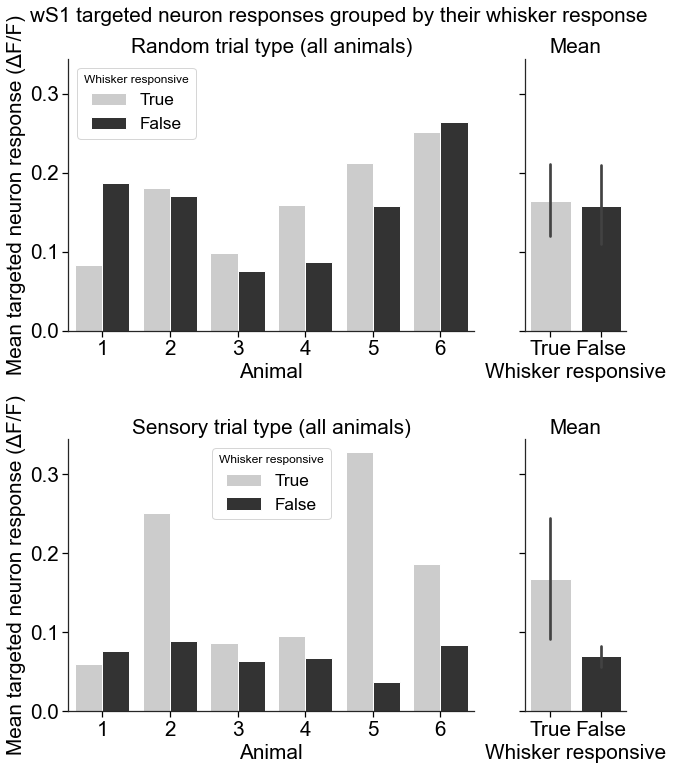

In [137]:
if sensory:
    targets = ['pr_target', 'ps_target']
    trials = ['pr', 'ps']

    unique_animals = len(cell_df.session_id.unique())

    fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,12), gridspec_kw={'width_ratios':(4, 1)})

    for i, (target, trial, label, ax) in enumerate(zip(targets, trials, plot_labels, axes)):

        session_labels = []

        target_df = cell_df.query(target)

        ctb_positive_targets = target_df.query('sta_sig_whisker')
        sum_resp_ctb_positive = ctb_positive_targets.groupby('session_id').mean()[trial + '_sta_amp_resp']
        session_labels.extend(ctb_positive_targets.groupby('session_id').mean().index.to_numpy())

        ctb_negative_targets = target_df.query('~sta_sig_whisker')
        sum_resp_ctb_negative = ctb_negative_targets.groupby('session_id').mean()[trial + '_sta_amp_resp']
        session_labels.extend(ctb_negative_targets.groupby('session_id').mean().index.to_numpy())

    #     ctb_positive_filter = cell_mean_timepoint_df.cell_id.isin(ctb_positive_targets)
    #     ctb_positive_df = cell_mean_timepoint_df[ctb_positive_filter]

    #     ctb_negative_filter = cell_mean_timepoint_df.cell_id.isin(ctb_negative_targets)
    #     ctb_negative_df = cell_mean_timepoint_df[ctb_negative_filter]

        df = pd.DataFrame({'summed_resp' : np.hstack([sum_resp_ctb_positive, sum_resp_ctb_negative]),
                           'Whisker responsive' : np.hstack([np.repeat('True', len(sum_resp_ctb_positive)),
                                                  np.repeat('False', len(sum_resp_ctb_negative))
                                                ]),
                           'session_id' : [session_label[-5:] for session_label in session_labels]
                          })

        sns.barplot(data=df, x='session_id', y='summed_resp', hue='Whisker responsive', 
                    palette=sns.color_palette(['0.8', '0.2']), ax=ax[0])
        sns.barplot(data=df, y='summed_resp', x='Whisker responsive', 
                    palette=sns.color_palette(['0.8', '0.2']), ax=ax[1])
        ax[0].set_title(label + ' trial type (all animals)')
        ax[0].set_ylabel('Mean targeted neuron response (ΔF/F)')
        ax[0].set_xlabel('Animal')

        ax[1].set_ylabel('')
        ax[1].set_title('Mean')

        ax0_labels = [item.get_text() for item in ax[0].get_xticklabels()]
        ax0_labels = list(range(1,unique_animals+1))

        ax[0].set_xticklabels(ax0_labels)

    #     ax1_labels = [item.get_text() for item in ax[1].get_xticklabels()]
    #     ax1_labels = ['','']

    #     ax[1].set_xticklabels(ax1_labels)

    plt.suptitle('wS1 targeted neuron responses grouped by their whisker response', fontsize='xx-large', y=0.94);
    plt.subplots_adjust(hspace=0.4)

    # save the figure
    save_path = fig_save_path + '_target_cell_group_response_by_whiskerresponse'
    ia.savePlot(save_path)

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:58: Us

Result for t-test pr vs ps on: Ttest_indResult(statistic=-8.93053819788064, pvalue=1.8541980695018955e-18)
 n=512 pr, n=542 ps


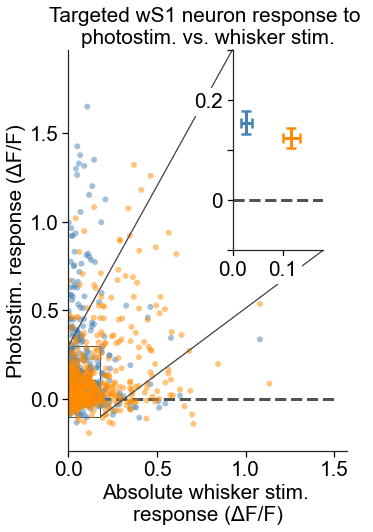

In [245]:
if sensory:
    
    trials = ['pr', 'ps']

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,12))

    for label, color, trial in zip(plot_labels, plot_colors, trials):
        target_df = cell_df.query(trial + '_target')
                
        photostim_mean_df = target_df[trial + '_sta_amp_resp'].mean()
        photostim_std_df = target_df[trial + '_sta_amp_resp'].std()
        photostim_95ci = 1.96*(photostim_std_df/np.sqrt(len(target_df)))
        whisker_mean_df = target_df['whisker_sta_amp_resp'].mean()
        whisker_std_df = target_df['whisker_sta_amp_resp'].std()
        whisker_95ci = 1.96*(whisker_std_df/np.sqrt(len(target_df)))
        
        # The data.
        sns.scatterplot(y=target_df[trial + '_sta_amp_resp'], x=np.absolute(target_df['whisker_sta_amp_resp']), 
                        alpha=0.5, ax=ax1, label=label, color=color, edgecolor='none')
    
        
        ax1.hlines(0, 0, 1.5, linestyle='--', zorder=-1, alpha=0.5, color='k', lw=3)
        ax1.set_aspect('equal')
        ax1.set_xlim([0,None])
        ax1.legend().set_visible(False)

        ax1.set_xlabel('Absolute whisker stim. \nresponse (ΔF/F)')
        ax1.set_ylabel('Photostim. response (ΔF/F)')
        ax1.set_title('Targeted wS1 neuron response to \nphotostim. vs. whisker stim.', fontsize='xx-large', y=1)
        
        # Create a set of inset Axes: these should fill the bounding box allocated to
        # them.
        ax2 = plt.axes([0,0,1,1])
        # Manually set the position and relative size of the inset axes within ax1
        ip = InsetPosition(ax1, [0.5,0.5,0.5,0.5])
        ax2.set_axes_locator(ip)
        
        # Mark the region corresponding to the inset axes on ax1 and draw lines
        # in grey linking the two axes.
        pp = mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='0.3', zorder=-1)
#         pp[1].set_visible(False)
#         pp[2].set_visible(False)
        
        # The data: only display for low temperature in the inset figure.
        ax2.errorbar(whisker_mean_df, photostim_mean_df,
                     yerr=photostim_95ci, xerr=whisker_95ci, elinewidth=plot_lw,
                     capsize=5, capthick=2.5, color=color)
        
        ax2.hlines(0, 0, 0.3, linestyle='--', zorder=-1, alpha=0.5, color='k', lw=3)
        ax2.set_aspect('equal')
        
        ax2.set_xlabel('')
        ax2.set_ylabel('')
        
        fig.canvas.draw()
        
        ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor='w')
        ax2.set_yticklabels(['', '0', '', '0.2'], backgroundcolor='w')
        
        ax2.set_xlim([0, 0.18])
        ax2.set_ylim([-0.1, 0.3])
        
    # save the figure
    save_path = fig_save_path + '_target_cell_whisker_vs_photostim_response'
    ia.savePlot(save_path)
    
    pr_whisker = cell_df.query('pr_target').whisker_sta_amp_resp
    ps_whisker = cell_df.query('ps_target').whisker_sta_amp_resp
    print(f'Result for t-test pr vs ps on: {stats.ttest_ind(pr_whisker, ps_whisker)}\n',
          f'n={len(pr_whisker)} pr, n={len(ps_whisker)} ps'
         )

# Specific analyses for projection photostim. trial type

In [109]:
# if projection:
#     df = pd.DataFrame()
    
#     unique_animals = len(cell_df.session_id.unique())
    
#     targets = ['Non_projecting', 'Projecting']
    
#     renamed_cell_df = cell_df.rename(columns = {'pr_target': 'Non_projecting', 'ps_target': 'Projecting'})

#     for target in targets:
#         target_df = renamed_cell_df.query(target)

#         num_ctb_targets = target_df.groupby('session_id')['ctb_targets'].sum()
#         num_targets = target_df.groupby('session_id')[target].count()

#         percent_targets_ctb = num_ctb_targets/num_targets * 100
#         session_labels = [session_id[-5:] for session_id in target_df['session_id'].unique()]

#         temp_df = pd.DataFrame({'target_type' : np.repeat(target, len(percent_targets_ctb)),
#                                 'percent_ctb' : percent_targets_ctb,
#                                 'session_id' : session_labels
#                                })

#         df = pd.concat([df, temp_df])

#     fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8,6), gridspec_kw={'width_ratios':(4, 1)})

#     sns.barplot(data=df, x='session_id', y='percent_ctb', hue='target_type', palette=sns.color_palette(plot_colors), ax=axes[0]);
#     sns.barplot(data=df, y='percent_ctb', x='target_type', palette=sns.color_palette(plot_colors), ax=axes[1]);

#     for ax in axes:
#         ax.set_ylabel('Directly-projecting (%)');

#     axes[0].set_xlabel('Animal')
#     axes[1].set_xlabel('Target type')

#     axes[0].set_title('All animals')
#     axes[1].set_title('Mean')
    
#     axes[0].legend().set_visible(False)
#     axes[1].set_ylabel('')
    
#     ax0_labels = [item.get_text() for item in axes[0].get_xticklabels()]
#     ax0_labels = list(range(1,unique_animals+1))

#     axes[0].set_xticklabels(ax0_labels)
    
#     ax1_labels = [item.get_text() for item in axes[1].get_xticklabels()]
#     ax1_labels = ['','']

#     axes[1].set_xticklabels(ax1_labels)
    
#     plt.suptitle('Percentage of targeted cells that directly projected to S2', fontsize='xx-large', y=0.99);

#     # save the figure
#     save_path = fig_save_path + '_target_cell_group_ctb_labelling'
#     ia.savePlot(save_path)

Result for t-test: Ttest_relResult(statistic=-9.106770396818767, pvalue=0.00026726997824327837)


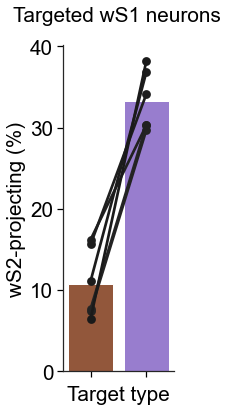

In [256]:
if projection:
    df = pd.DataFrame()
    
    unique_animals = len(cell_df.session_id.unique())
    
    targets = ['Non_projecting', 'Projecting']
    
    renamed_cell_df = cell_df.rename(columns = {'pr_target': 'Non_projecting', 'ps_target': 'Projecting'})

    for target in targets:
        target_df = renamed_cell_df.query(target)

        num_ctb_targets = target_df.groupby('session_id')['ctb_targets'].sum()
        num_targets = target_df.groupby('session_id')[target].count()

        percent_targets_ctb = num_ctb_targets/num_targets * 100
        session_labels = [session_id[-5:] for session_id in target_df['session_id'].unique()]

        temp_df = pd.DataFrame({'target_type' : np.repeat(target, len(percent_targets_ctb)),
                                'percent_ctb' : percent_targets_ctb,
                                'session_id' : session_labels
                               })

        df = pd.concat([df, temp_df])

    fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(2,6))

    sns.barplot(data=df, y='percent_ctb', x='target_type', palette=sns.color_palette(plot_colors), ci=None,
                ax=axes, zorder=-1);
    sns.pointplot(data=df, x='target_type', y='percent_ctb', hue='session_id', color='k', dodge=False,
                 ax=axes)
    
    axes.set_ylabel('wS2-projecting (%)');

    axes.set_xlabel('Target type')
    
    axes.legend().set_visible(False)
    
    ax1_labels = [item.get_text() for item in axes.get_xticklabels()]
    ax1_labels = ['','']

    axes.set_xticklabels(ax1_labels)
    
    plt.suptitle('Targeted wS1 neurons', fontsize='xx-large', y=0.97);

    # save the figure
    save_path = fig_save_path + '_target_cell_group_ctb_labelling_mean'
    ia.savePlot(save_path)
    
    df.reset_index(drop=True, inplace=True)
    pr_avg = df.groupby(['target_type', 'session_id']).mean().loc['Non_projecting', 'percent_ctb']
    ps_avg = df.groupby(['target_type', 'session_id']).mean().loc['Projecting', 'percent_ctb']
    print(f'Result for t-test: {stats.ttest_rel(pr_avg, ps_avg)}')

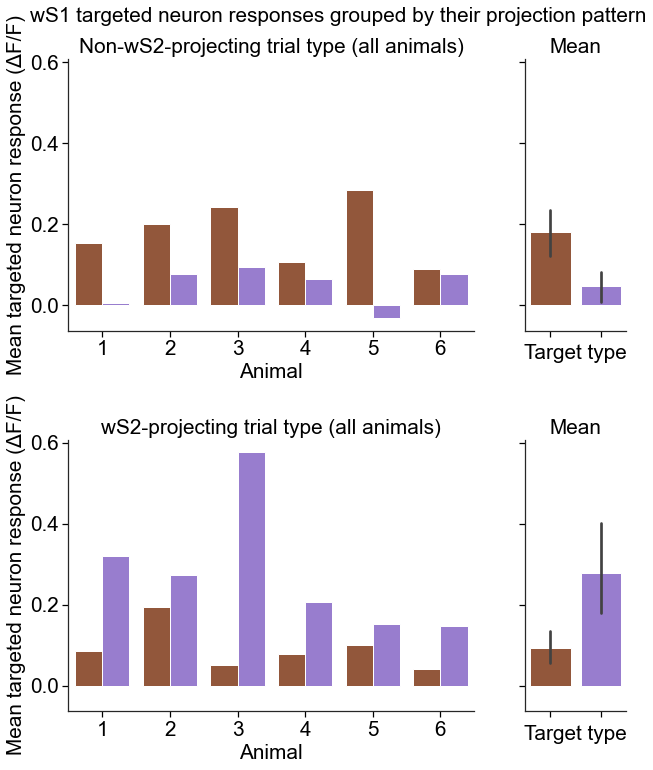

In [111]:
if projection:
    targets = ['Non_projecting', 'Projecting']
    labels = plot_labels[:2]
    trials = ['pr', 'ps']

    fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,12), gridspec_kw={'width_ratios':(4,1)})
    
    renamed_cell_df = cell_df.rename(columns = {'pr_target': 'Non_projecting', 'ps_target': 'Projecting'})
    
    for i, (label, target, trial, ax) in enumerate(zip(labels, targets, trials, axes)):

        session_labels = []

        target_df = renamed_cell_df.query(target)

        ctb_negative_targets = target_df.query('~ctb_targets')
        sum_resp_ctb_negative = ctb_negative_targets.groupby('session_id').mean()[trial + '_sta_amp_resp']
        ctb_negative_labels = ctb_negative_targets.groupby('session_id').mean().index.to_numpy()
        
        ctb_positive_targets = target_df.query('ctb_targets')
        sum_resp_ctb_positive = ctb_positive_targets.groupby('session_id').mean()[trial + '_sta_amp_resp']
        ctb_positive_labels = ctb_positive_targets.groupby('session_id').mean().index.to_numpy()

    #     ctb_positive_filter = cell_mean_timepoint_df.cell_id.isin(ctb_positive_targets)
    #     ctb_positive_df = cell_mean_timepoint_df[ctb_positive_filter]

    #     ctb_negative_filter = cell_mean_timepoint_df.cell_id.isin(ctb_negative_targets)
    #     ctb_negative_df = cell_mean_timepoint_df[ctb_negative_filter]

        df = pd.DataFrame({'summed_resp' : np.hstack([sum_resp_ctb_negative, sum_resp_ctb_positive]),
                           'Target type' : np.hstack([np.repeat('Non_projecting', len(sum_resp_ctb_negative)), 
                                                      np.repeat('Projecting', len(sum_resp_ctb_positive))]),
                           'session_id' : np.hstack([ctb_negative_labels, ctb_positive_labels])
                          })
        
        sns.barplot(data=df, x='session_id', y='summed_resp', hue='Target type', 
                    palette=sns.color_palette(plot_colors), ax=ax[0])
        sns.barplot(data=df, y='summed_resp', x='Target type', 
                    palette=sns.color_palette(plot_colors), ax=ax[1])
    
        ax[0].set_title(label + ' trial type (all animals)')
        ax[0].set_ylabel('Mean targeted neuron response (ΔF/F)')
        ax[0].set_xlabel('Animal')

        ax[1].set_ylabel('')
        ax[1].set_title('Mean')

        ax0_labels = [item.get_text() for item in ax[0].get_xticklabels()]
        ax0_labels = list(range(1,unique_animals+1))

        ax[0].set_xticklabels(ax0_labels)

        ax1_labels = [item.get_text() for item in ax[1].get_xticklabels()]
        ax1_labels = ['','']

        ax[1].set_xticklabels(ax1_labels)
        
        ax[0].legend().set_visible(False)

    plt.subplots_adjust(hspace=0.4)
    plt.suptitle('wS1 targeted neuron responses grouped by their projection pattern',
                fontsize='xx-large', y=0.94);

    # save the figure
    save_path = fig_save_path + '_target_cell_group_response_by_projection_type'
    ia.savePlot(save_path)

Result for t-test pr vs ps on pr trials:: Ttest_relResult(statistic=3.014537574017591, pvalue=0.029601131138895963)
Result for t-test pr vs ps on ps trials:: Ttest_relResult(statistic=-2.577629716830738, pvalue=0.04957436156927171)


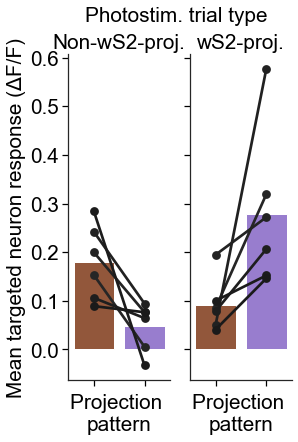

In [260]:
if projection:
    targets = ['Non_projecting', 'Projecting']
    labels = plot_labels[:2]
    trials = ['pr', 'ps']

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(4,6))
    
    renamed_cell_df = cell_df.rename(columns = {'pr_target': 'Non_projecting', 'ps_target': 'Projecting'})
    
    for i, (label, target, trial, ax) in enumerate(zip(labels, targets, trials, axes)):

        session_labels = []

        target_df = renamed_cell_df.query(target)

        ctb_negative_targets = target_df.query('~ctb_targets')
        sum_resp_ctb_negative = ctb_negative_targets.groupby('session_id').mean()[trial + '_sta_amp_resp']
        ctb_negative_labels = ctb_negative_targets.groupby('session_id').mean().index.to_numpy()
        
        ctb_positive_targets = target_df.query('ctb_targets')
        sum_resp_ctb_positive = ctb_positive_targets.groupby('session_id').mean()[trial + '_sta_amp_resp']
        ctb_positive_labels = ctb_positive_targets.groupby('session_id').mean().index.to_numpy()

    #     ctb_positive_filter = cell_mean_timepoint_df.cell_id.isin(ctb_positive_targets)
    #     ctb_positive_df = cell_mean_timepoint_df[ctb_positive_filter]

    #     ctb_negative_filter = cell_mean_timepoint_df.cell_id.isin(ctb_negative_targets)
    #     ctb_negative_df = cell_mean_timepoint_df[ctb_negative_filter]

        df = pd.DataFrame({'summed_resp' : np.hstack([sum_resp_ctb_negative, sum_resp_ctb_positive]),
                           'Target type' : np.hstack([np.repeat('Non_projecting', len(sum_resp_ctb_negative)), 
                                                      np.repeat('Projecting', len(sum_resp_ctb_positive))]),
                           'session_id' : np.hstack([ctb_negative_labels, ctb_positive_labels])
                          })
        
        sns.pointplot(data=df, x='Target type', y='summed_resp', hue='session_id', color='k', 
                      dodge=False, ax=ax)
        sns.barplot(data=df, y='summed_resp', x='Target type', zorder=-1, ci=None, 
                    palette=sns.color_palette(plot_colors), ax=ax)
    
        ax.set_ylabel('Mean targeted neuron response (ΔF/F)')
        if label == 'Non-wS2-projecting':
            label = 'Non-wS2-proj.'
        if label == 'wS2-projecting':
            label = 'wS2-proj.'
            
        ax.set_title(label)

        ax1_labels = [item.get_text() for item in ax.get_xticklabels()]
        ax1_labels = ['','']

        ax.set_xticklabels(ax1_labels)
        ax.set_xlabel('Projection \npattern')
        
        ax.legend().set_visible(False)
        
        df.reset_index(drop=True, inplace=True)
        pr_avg = df.groupby(['Target type', 'session_id']).mean().loc['Non_projecting', 'summed_resp']
        ps_avg = df.groupby(['Target type', 'session_id']).mean().loc['Projecting', 'summed_resp']
        print(f'Result for t-test pr vs ps on {trial} trials:: {stats.ttest_rel(pr_avg, ps_avg)}')
    
    axes[1].set_ylabel('')
    
    plt.suptitle('Photostim. trial type', fontsize='xx-large', y=0.99);

    # save the figure
    save_path = fig_save_path + '_target_cell_group_response_by_projection_type_mean'
    ia.savePlot(save_path)

In [261]:
if projection:
    s2p_paths = session_df['s2p_path'].values
    session_ids = session_df.index.values

    whisker_responses = pd.Series(dtype='float64')

    for s2p_path, session_id in zip(s2p_paths, session_ids):

        tiff_folder = os.path.dirname(os.path.dirname(s2p_path))
        file_list = os.listdir(tiff_folder)

        for file in file_list:
            if 'whisker_response' in file:
                whisker_dff_img = tf.imread(os.path.join(tiff_folder, file))

        session_cell_df = cell_df[cell_df['session_id'] == session_id]

        cell_x_list = session_cell_df['cell_x'].values
        cell_y_list = session_cell_df['cell_y'].values
        cell_id_list = session_cell_df.index.values

        whisker_response = []

        for cell_x, cell_y in zip(cell_x_list, cell_y_list):

            whisker_response.append(np.mean(whisker_dff_img[cell_x, cell_y]))

        new_rows = pd.Series(data=whisker_response, index=cell_id_list)

        whisker_responses = whisker_responses.append(new_rows)

    cell_df['whisker_sta_amp_resp'] = whisker_responses

In [262]:
# if projection:
#     trial = 'whisker'

#     fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8,6), gridspec_kw={'width_ratios': (4,1)})
    
#     renamed_cell_df = cell_df.rename(columns = {'pr_target': 'Non_projecting', 'ps_target': 'Projecting'}).copy()
#     target_df = renamed_cell_df.query('Non_projecting | Projecting').copy()

#     ctb_negative_targets = target_df.query('~ctb_targets').copy()
#     mean_resp_ctb_negative = ctb_negative_targets[trial + '_sta_amp_resp']
#     ctb_negative_labels = ctb_negative_targets.session_id.to_numpy()
    
#     ctb_positive_targets = target_df.query('ctb_targets').copy()
#     mean_resp_ctb_positive = ctb_positive_targets[trial + '_sta_amp_resp']
#     ctb_positive_labels = ctb_positive_targets.session_id.to_numpy()

#     df = pd.DataFrame({'mean_resp' : np.hstack([mean_resp_ctb_negative, mean_resp_ctb_positive]),
#                        'Target_type' : np.hstack([np.repeat('Non-projecting', len(mean_resp_ctb_negative)), 
#                                                   np.repeat('Projecting', len(mean_resp_ctb_positive))]),
#                        'session_id' : np.hstack([ctb_negative_labels, ctb_positive_labels])
#                       })

#     sns.barplot(data=df, x='session_id', y='mean_resp', hue='Target_type', ci=95,
#                 palette=sns.color_palette(plot_colors), ax=ax[0])
#     sns.barplot(data=df, x='Target_type', y='mean_resp', ci=95,
#                 palette=sns.color_palette(plot_colors), ax=ax[1])

#     ax[0].set_ylabel('Mean whisker response (ΔF/F)')
#     ax[0].set_xlabel('Animal')

#     ax[1].set_ylabel('')
#     ax[1].set_xlabel('Target type')
    
#     ax[0].set_title('All animals')
#     ax[1].set_title('Mean')
    
#     ax0_labels = [item.get_text() for item in ax[0].get_xticklabels()]
#     ax0_labels = list(range(1,unique_animals+1))

#     ax[0].set_xticklabels(ax0_labels)

#     ax1_labels = [item.get_text() for item in ax[1].get_xticklabels()]
#     ax1_labels = ['','']

#     ax[1].set_xticklabels(ax1_labels)
    
#     ax[0].legend().set_visible(False)

#     plt.suptitle('S1 targeted cell whisker response grouped by trial type',
#                 fontsize='xx-large', y=0.99);

#     # save the figure
#     save_path = fig_save_path + '_ResponseAmplitude_TargetCells_ProjectingS2_WhiskerResponse'
#     ia.savePlot(save_path)

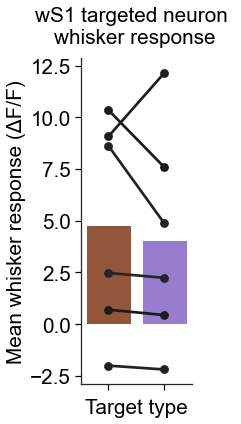

In [263]:
if projection:
    trial = 'whisker'

    fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(2,6))
    
    renamed_cell_df = cell_df.rename(columns = {'pr_target': 'Non_projecting', 'ps_target': 'Projecting'}).copy()
    target_df = renamed_cell_df.query('Non_projecting | Projecting').copy()

    ctb_negative_targets = target_df.query('~ctb_targets').copy()
    mean_resp_ctb_negative = ctb_negative_targets[trial + '_sta_amp_resp']
    ctb_negative_labels = ctb_negative_targets.session_id.to_numpy()
    
    ctb_positive_targets = target_df.query('ctb_targets').copy()
    mean_resp_ctb_positive = ctb_positive_targets[trial + '_sta_amp_resp']
    ctb_positive_labels = ctb_positive_targets.session_id.to_numpy()

    df = pd.DataFrame({'mean_resp' : np.hstack([mean_resp_ctb_negative, mean_resp_ctb_positive]),
                       'Target_type' : np.hstack([np.repeat('Non-projecting', len(mean_resp_ctb_negative)), 
                                                  np.repeat('Projecting', len(mean_resp_ctb_positive))]),
                       'session_id' : np.hstack([ctb_negative_labels, ctb_positive_labels])
                      })

    sns.pointplot(data=df, x='Target_type', y='mean_resp', hue='session_id', color='k', ci=None, 
                      dodge=False, ax=ax)
    sns.barplot(data=df, x='Target_type', y='mean_resp', ci=None, zorder=-1,
                palette=sns.color_palette(plot_colors), ax=ax)

    ax.set_ylabel('Mean whisker response (ΔF/F)')

    ax.set_xlabel('Target type')
    
    ax1_labels = [item.get_text() for item in ax.get_xticklabels()]
    ax1_labels = ['','']

    ax.set_xticklabels(ax1_labels)
    
    ax.legend().set_visible(False)

    plt.suptitle('wS1 targeted neuron \nwhisker response',
                fontsize='xx-large', y=1);

    # save the figure
    save_path = fig_save_path + '_ResponseAmplitude_TargetCells_ProjectingS2_WhiskerResponse_mean'
    ia.savePlot(save_path)

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:57: Us

Result for t-test pr vs ps on: Ttest_indResult(statistic=0.9905780017679741, pvalue=0.3224996256006736)
 n=180 pr, n=216 ps


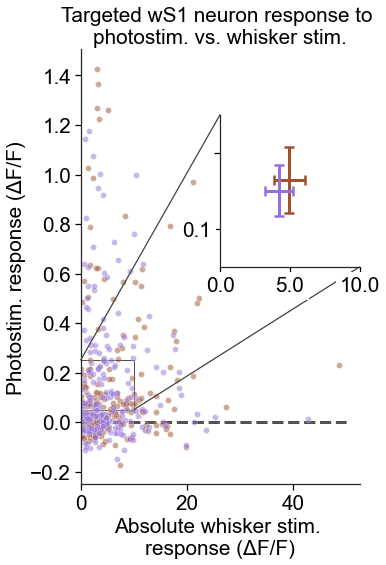

In [264]:
if projection:
    trials = ['pr', 'ps']

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,8))

    for label, color, trial in zip(plot_labels, plot_colors, trials):
        target_df = cell_df.query(trial + '_target')

        photostim_mean_df = target_df[trial + '_sta_amp_resp'].mean()
        photostim_std_df = target_df[trial + '_sta_amp_resp'].std()
        photostim_95ci = 1.96*(photostim_std_df/np.sqrt(len(target_df)))
        whisker_mean_df = target_df['whisker_sta_amp_resp'].mean()
        whisker_std_df = target_df['whisker_sta_amp_resp'].std()
        whisker_95ci = 1.96*(whisker_std_df/np.sqrt(len(target_df)))

        # The data.
        sns.scatterplot(y=target_df[trial + '_sta_amp_resp'], x=np.absolute(target_df['whisker_sta_amp_resp']), 
                        alpha=0.5, ax=ax1, label=label, color=color)


        ax1.hlines(0, 0, 50, linestyle='--', zorder=-1, alpha=0.5, color='k', lw=3)
    #     ax1.set_aspect('equal')
        ax1.set_xlim([0,None])
        ax1.legend().set_visible(False)

        ax1.set_xlabel('Absolute whisker stim. \nresponse (ΔF/F)')
        ax1.set_ylabel('Photostim. response (ΔF/F)')
        ax1.set_title('Targeted wS1 neuron response to \nphotostim. vs. whisker stim.', fontsize='xx-large', y=1)

        # Create a set of inset Axes: these should fill the bounding box allocated to
        # them.
        ax2 = plt.axes([0,0,1,1])
        # Manually set the position and relative size of the inset axes within ax1
        ip = InsetPosition(ax1, [0.5,0.5,0.5,0.35])
        ax2.set_axes_locator(ip)

        # Mark the region corresponding to the inset axes on ax1 and draw lines
        # in grey linking the two axes.
        pp = mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='0.3', zorder=-1)
    #         pp[1].set_visible(False)
    #         pp[2].set_visible(False)

        # The data: only display for low temperature in the inset figure.
        ax2.errorbar(whisker_mean_df, photostim_mean_df,
                     yerr=photostim_95ci, xerr=whisker_95ci, elinewidth=plot_lw,
                     capsize=5, capthick=2.5, color=color)

        ax2.hlines(0, 0, 0.3, linestyle='--', zorder=-1, alpha=0.5, color='k', lw=3)
    #     ax2.set_aspect('equal')

        ax2.set_xlabel('')
        ax2.set_ylabel('')

        fig.canvas.draw()

        ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor='w')
        ax2.set_yticklabels(['', '0.1', '', '0.2', ''], backgroundcolor='w')

        ax2.set_xlim([0, 10])
        ax2.set_ylim([0.05, 0.25])

    # save the figure
    save_path = fig_save_path + '_target_cell_whisker_vs_photostim_response_mean'
    ia.savePlot(save_path)
    
    pr_whisker = cell_df.query('pr_target').whisker_sta_amp_resp
    ps_whisker = cell_df.query('ps_target').whisker_sta_amp_resp
    print(f'Result for t-test pr vs ps on: {stats.ttest_ind(pr_whisker, ps_whisker)}\n',
          f'n={len(pr_whisker)} pr, n={len(ps_whisker)} ps'
         )

## Pupil size vs. s2 activity

In [104]:
# pupil vs. average delta activity

# responses = ['pr_norm_influence', 'ps_norm_influence', 'spont_norm_influence']

# s2_cell_ids = cell_df.query('s2_cell').index
# s2_filter = cell_trial_df['cell_id'].isin(s2_cell_ids)
# s2_df = cell_trial_df[s2_filter]

# s2_delta_act = s2_df.groupby(['trial_num','session_id']).mean()[responses]

# s2_delta_act.reset_index(inplace=True)
# s2_delta_act = s2_delta_act.melt(id_vars=['session_id', 'trial_num'], 
#                                  value_name='delta_activity', 
#                                  var_name='stim_type')
# s2_delta_act.replace({'pr_norm_influence': 'photostim',
#                       'ps_norm_influence': 'photostim',
#                       'spont_norm_influence': 'sham'
#                      }, inplace=True)

# pupil_trial_df = trial_df.loc[:, ['session_id', 'trial_num', 'stim_type', 'pupil_area_smooth']]
# pupil_trial_df.replace({'pr': 'photostim',
#                         'ps': 'photostim',
#                         'none': 'sham'
#                        }, inplace=True)

# grouped_pupil_df = pupil_trial_df.set_index(['session_id', 'trial_num', 'stim_type']).sort_index()
# grouped_s2_df = s2_delta_act.set_index(['session_id', 'trial_num', 'stim_type']).sort_index()
# pupil_s2_df = pd.concat([grouped_pupil_df, grouped_s2_df], axis=1).reset_index(drop=False)

# sns.lmplot(data=pupil_s2_df, x='pupil_area_smooth', y='delta_activity', hue='stim_type',
#            palette=sns.color_palette(['k', plot_colors[2]]), x_bins=10);

# save_path = fig_save_path + '_deltaactivity_pupilarea_photostim_sham'
# ia.savePlot(save_path)

In [105]:
# pupil vs. number of s2 cells positive

# responses = ['pr_norm_influence', 'ps_norm_influence', 'spont_norm_influence']

# s2_cell_ids = cell_df.query('s2_cell').index
# s2_filter = cell_trial_df['cell_id'].isin(s2_cell_ids)
# s2_df = cell_trial_df[s2_filter]

# num_s2_positive = (s2_df.set_index(['session_id', 'trial_num']).loc[:,['pr_amp_resp', 'ps_amp_resp', 'spont_amp_resp']]>0).reset_index().groupby(['session_id', 'trial_num']).sum()

# total_s2 = s2_df.set_index(['session_id', 'trial_num']).groupby(['session_id', 'trial_num']).count()
# total_s2_cells = total_s2.cell_num.sort_index()

# prop_s2_positive = num_s2_positive[['pr_amp_resp', 'ps_amp_resp', 'spont_amp_resp']].div(total_s2_cells, axis=0)

# prop_s2_positive.reset_index(inplace=True)
# prop_s2_positive = prop_s2_positive.melt(id_vars=['session_id', 'trial_num'], 
#                                          value_name='proportion_positive_s2', 
#                                          var_name='stim_type')
# prop_s2_positive.replace({'pr_amp_resp': 'photostim',
#                           'ps_amp_resp': 'photostim',
#                           'spont_amp_resp': 'sham'
#                          }, inplace=True)

# pupil_trial_df = trial_df.loc[:, ['session_id', 'trial_num', 'stim_type', 'pupil_area_smooth']]
# pupil_trial_df.replace({'pr': 'photostim',
#                         'ps': 'photostim',
#                         'none': 'sham'
#                        }, inplace=True)

# grouped_pupil_df = pupil_trial_df.set_index(['session_id', 'trial_num', 'stim_type']).sort_index()
# grouped_s2_df = prop_s2_positive.set_index(['session_id', 'trial_num', 'stim_type']).sort_index()
# pupil_s2_df = pd.concat([grouped_pupil_df, grouped_s2_df], axis=1).reset_index(drop=False)

# sns.lmplot(data=pupil_s2_df, x='pupil_area_smooth', y='proportion_positive_s2', hue='stim_type',
#            palette=sns.color_palette(['k', plot_colors[2]]), x_bins=10);

# save_path = fig_save_path + '_positives2proportion_pupilarea_photostim_sham'
# ia.savePlot(save_path)

# Combined dataset analyses

In [ ]:
# target spread vs. s2 response
# target spread found in trial_df for each session/trial num
# s2 response per trial average can be calculated from session/trial num average of cell_df?
if combined: 
    s2_cell_ids = cell_df.query('s2_cell').index
    s2_cell_filter = cell_trial_df.cell_id.isin(s2_cell_ids)
    s2_cell_trial_df = cell_trial_df[s2_cell_filter].copy()
    mean_trial_s2_resp = s2_cell_trial_df.groupby(['session_id', 'trial_num']).mean()
    mean_trial_s2_resp.reset_index(drop=False, inplace=True)

    s2_resp_df = mean_trial_s2_resp.melt(id_vars=['session_id', 'trial_num'], 
                                         value_vars=['pr_amp_resp', 'ps_amp_resp', 'spont_amp_resp'],
                                         value_name='s2_resp',
                                         var_name='trial_type'
                                        )

    s2_resp_df.replace({'pr_amp_resp': 'pr', 
                        'ps_amp_resp': 'ps', 
                        'spont_amp_resp' : 'none'
                        }, inplace=True)

    s2_resp_df.set_index(['session_id', 'trial_num', 'trial_type'], inplace=True)

    new_trial_df = trial_df.rename(columns={'stim_type': 'trial_type'}).copy()
    target_spread_ser = new_trial_df.set_index(['session_id', 'trial_num', 'trial_type'])['trial_target_euclid_dist']

    s2_resp_df['avg_target_spread'] = target_spread_ser
    s2_resp_df.reset_index(inplace=True)
    s2_resp_df.drop(columns=['session_id', 'trial_num'], inplace=True)
    s2_resp_df.replace({'pr': 'photostim', 'ps': 'photostim', 'none': 'sham'}, inplace=True)

In [ ]:
if combined: 
    sns.lmplot(data=s2_resp_df, y='s2_resp', x='avg_target_spread', hue='trial_type',
               palette=sns.color_palette(['0.2', 'mediumseagreen']),
               scatter_kws={'alpha': 0.5, 'edgecolor': 'none'},
               line_kws={'linewidth': plot_lw} 
              )

    save_path = fig_save_path + '_targetspread_s2resp'
    ia.savePlot(save_path)

    plt.figure()
    sns.lmplot(data=s2_resp_df, y='s2_resp', x='avg_target_spread', x_bins=30, hue='trial_type',
               palette=sns.color_palette(['0.2', 'mediumseagreen']), 
               scatter_kws={'alpha': 0.5, 'edgecolor': 'none'},
               line_kws={'linewidth': plot_lw} 
              );

    save_path = fig_save_path + '_targetspread_s2resp_binned'
    ia.savePlot(save_path)

In [ ]:
# target spread vs. s2 response
# target spread found in trial_df for each session/trial num
# s2 response per trial average can be calculated from session/trial num average of cell_df?
if combined: 
    s2_cell_ids = cell_df.query('s2_cell').index
    s2_cell_filter = cell_trial_df.cell_id.isin(s2_cell_ids)
    s2_cell_trial_df = cell_trial_df[s2_cell_filter].copy()
    mean_trial_s2_resp = s2_cell_trial_df.groupby(['session_id', 'trial_num']).mean()
    mean_trial_s2_resp.reset_index(drop=False, inplace=True)

    s2_resp_df = mean_trial_s2_resp.melt(id_vars=['session_id', 'trial_num'], 
                                         value_vars=['pr_amp_resp', 'ps_amp_resp', 'spont_amp_resp'],
                                         value_name='s2_resp',
                                         var_name='trial_type'
                                        )

    s2_resp_df.replace({'pr_amp_resp': 'pr', 
                        'ps_amp_resp': 'ps', 
                        'spont_amp_resp' : 'none'
                        }, inplace=True)

    s2_resp_df.set_index(['session_id', 'trial_num', 'trial_type'], inplace=True)

    new_trial_df = trial_df.rename(columns={'stim_type': 'trial_type'}).copy()
    new_trial_df.set_index(['session_id', 'trial_num', 'trial_type'], inplace=True)
    trial_target_dff = new_trial_df.groupby(['session_id', 'trial_type']).transform(lambda x : stats.zscore(x, ddof=1))['trial_target_dff']

    s2_resp_df['mean_trial_target_dff'] = trial_target_dff
    s2_resp_df.reset_index(inplace=True)
    s2_resp_df.drop(columns=['session_id', 'trial_num'], inplace=True)
    s2_resp_df.replace({'pr': 'photostim', 'ps': 'photostim', 'none': 'sham'}, inplace=True)

In [ ]:
if combined: 
    sns.lmplot(data=s2_resp_df, y='s2_resp', x='mean_trial_target_dff', hue='trial_type',
               palette=sns.color_palette(['0.2', 'mediumseagreen']),
               scatter_kws={'alpha': 0.5, 'edgecolor': 'none'},
               line_kws={'linewidth': plot_lw} 
              )

    save_path = fig_save_path + '_targetresp_s2resp'
    ia.savePlot(save_path)

    plt.figure()
    sns.lmplot(data=s2_resp_df, y='s2_resp', x='mean_trial_target_dff', x_bins=5, hue='trial_type',
               palette=sns.color_palette(['0.2', 'mediumseagreen']), 
               scatter_kws={'alpha': 0.5, 'edgecolor': 'none'},
               line_kws={'linewidth': plot_lw} 
              );

    save_path = fig_save_path + '_targetresp_s2resp_binned'
    ia.savePlot(save_path)

In [ ]:
# num targets responding on trial vs. s2 resp
# keep s2 resp the same, indexed by session, trial, trial_type
# need num targets responding on each trial using trial_sig_dff_[trial_type]

# end up with dataframe to match to s2_resp_df, which contains session, trial, trial_type [photostim/sham]

if combined:
    s2_cell_ids = cell_df.query('s2_cell').index
    s2_cell_filter = cell_trial_df.cell_id.isin(s2_cell_ids)
    s2_cell_trial_df = cell_trial_df[s2_cell_filter].copy()
    mean_trial_s2_resp = s2_cell_trial_df.groupby(['session_id', 'trial_num']).mean()
    mean_trial_s2_resp.reset_index(drop=False, inplace=True)

    s2_resp_df = mean_trial_s2_resp.melt(id_vars=['session_id', 'trial_num'], 
                                         value_vars=['pr_amp_resp', 'ps_amp_resp', 'spont_amp_resp'],
                                         value_name='s2_resp',
                                         var_name='trial_type'
                                        )

    s2_resp_df.replace({'pr_amp_resp': 'pr', 
                        'ps_amp_resp': 'ps', 
                        'spont_amp_resp' : 'none'
                        }, inplace=True)

    s2_resp_df.set_index(['session_id', 'trial_num', 'trial_type'], inplace=True)

    df = pd.DataFrame()

    for trial_type in ['pr', 'ps']:

        target_cell_ids = cell_df.query(trial_type + '_target').index
        target_cell_filter = cell_trial_df.cell_id.isin(target_cell_ids)
        target_cell_trial_df = cell_trial_df[target_cell_filter].copy()
        target_cell_trial_df = target_cell_trial_df.query('trial_sig_dff_' + trial_type).copy()

        num_cell_resp_df = target_cell_trial_df.groupby(['session_id', 'trial_num']).sum()

        temp_df = num_cell_resp_df.loc[:, ['trial_sig_dff_' + trial_type, 'trial_sig_dff_spont']].copy()

        df = pd.concat([df, temp_df])

    df = df.reset_index().groupby(['session_id', 'trial_num']).mean().apply(np.ceil).copy()
    df.reset_index(inplace=True)

    df = df.melt(id_vars=['session_id', 'trial_num'], 
                 value_vars=['trial_sig_dff_pr', 'trial_sig_dff_ps', 'trial_sig_dff_spont'],
                 value_name='num_resp_targs',
                 var_name='trial_type'
                )

    df.replace({'trial_sig_dff_pr': 'pr', 
                'trial_sig_dff_ps': 'ps', 
                'trial_sig_dff_spont' : 'none'
                }, inplace=True)

    df.set_index(['session_id', 'trial_num', 'trial_type'], inplace=True)

    s2_resp_df['num_resp_targs'] = df['num_resp_targs']
    s2_resp_df.reset_index(inplace=True)
    s2_resp_df.drop(columns=['session_id', 'trial_num'], inplace=True)
    s2_resp_df.replace({'pr': 'photostim', 'ps': 'photostim', 'none': 'sham'}, inplace=True)

In [ ]:
if combined:
    sns.lmplot(data=s2_resp_df, y='s2_resp', x='num_resp_targs', hue='trial_type',
               palette=sns.color_palette(['0.2', 'mediumseagreen']),
               scatter_kws={'alpha': 0.5, 'edgecolor': 'none'},
               line_kws={'linewidth': plot_lw} 
              )

    save_path = fig_save_path + '_numtargetresp_s2resp'
    ia.savePlot(save_path)

    plt.figure()
    sns.lmplot(data=s2_resp_df, y='s2_resp', x='num_resp_targs', x_bins=5, hue='trial_type',
               palette=sns.color_palette(['0.2', 'mediumseagreen']), 
               scatter_kws={'alpha': 0.5, 'edgecolor': 'none'},
               line_kws={'linewidth': plot_lw} 
              );

    save_path = fig_save_path + '_numtargetresp_s2resp_binned'
    ia.savePlot(save_path)

In [ ]:
# num cells targeted vs. s2 resp
# keep s2 resp the same, indexed by session, trial, trial_type
# need num targets responding on each trial using trial_sig_dff_[trial_type]

# end up with dataframe to match to s2_resp_df, which contains session, trial, trial_type [photostim/sham]

if combined:
    s2_cell_ids = cell_df.query('s2_cell').index
    s2_cell_filter = cell_trial_df.cell_id.isin(s2_cell_ids)
    s2_cell_trial_df = cell_trial_df[s2_cell_filter].copy()
    mean_trial_s2_resp = s2_cell_trial_df.groupby(['session_id']).mean()
    mean_trial_s2_resp.reset_index(drop=False, inplace=True)

    s2_resp_df = mean_trial_s2_resp.melt(id_vars='session_id', 
                                         value_vars=['pr_norm_influence', 'ps_norm_influence', 'spont_norm_influence'],
                                         value_name='s2_influence',
                                         var_name='trial_type'
                                        )

    s2_resp_df.replace({'pr_norm_influence': 'photostim', 
                        'ps_norm_influence': 'photostim',
                        'spont_norm_influence': 'sham'
                        }, inplace=True)

    s2_resp_df.set_index(['session_id', 'trial_type'], inplace=True)
    s2_resp_df.reset_index(inplace=True)
    s2_resp_df.groupby(['session_id', 'trial_type']).mean().reset_index(inplace=True)

    df = pd.DataFrame()

    for trial_type in ['pr', 'ps']:

        num_cells_targ = cell_df.query(trial_type + '_target').groupby(['session_id']).sum()

        temp_df = num_cells_targ.loc[:, [trial_type + '_target']].copy()

        df = pd.concat([df, temp_df], axis=1)

    df.reset_index(inplace=True)
    df['sham_target'] = df.pr_target

    df = df.melt(id_vars=['session_id'], 
                 value_vars=['pr_target', 'ps_target', 'sham_target'], 
                 value_name='num_targs', 
                 var_name='trial_type')

    df.replace({'pr_target': 'photostim', 
                'ps_target': 'photostim',
                'sham_target': 'sham'
                }, inplace=True)

    s2_resp_df['num_targs'] = df['num_targs']

In [ ]:
if combined:
    sns.lmplot(data=s2_resp_df, y='s2_influence', x='num_targs', hue='trial_type',
               palette=sns.color_palette(['0.2', 'mediumseagreen']),
               scatter_kws={'alpha': 0.5, 'edgecolor': 'none'},
               line_kws={'linewidth': plot_lw} 
              )

    save_path = fig_save_path + '_numtargs_s2influence'
    ia.savePlot(save_path)

    plt.figure()
    sns.lmplot(data=s2_resp_df, y='s2_influence', x='num_targs', x_bins=5, hue='trial_type',
               palette=sns.color_palette(['0.2', 'mediumseagreen']), 
               scatter_kws={'alpha': 0.5, 'edgecolor': 'none'},
               line_kws={'linewidth': plot_lw} 
              );

    save_path = fig_save_path + '_numtargs_s2influence_binned'
    ia.savePlot(save_path)

# Specific analyses for interneuron trial type

In [207]:
if interneuron:
    remove_id = '2021-01-28_RL124'
    cell_df = cell_df.query('session_id != @remove_id')
    cell_mean_timepoint_df = cell_mean_timepoint_df.query('session_id != @remove_id')

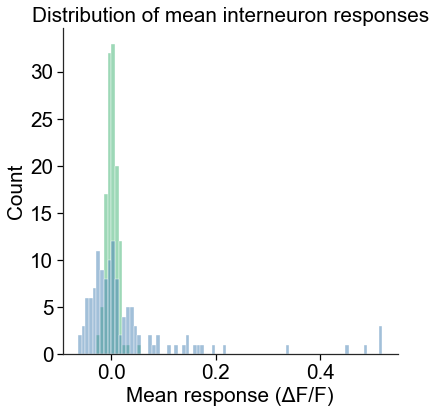

In [208]:
# PLOT DISTRIBUTION OF S2 CELL RESPONSES
if interneuron:
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, figsize=(6,6))

    s2_df = cell_df.query('int_cell').reset_index(drop=False)
    temp_df = s2_df.melt(id_vars='cell_id', value_vars=['pr_sta_amp_resp', 'spont_sta_amp_resp'])
    sns.histplot(data=temp_df, x='value', hue='variable', ax=ax,
                 palette=sns.color_palette(plot_colors), legend=False, line_kws={'linewidth': plot_lw})

    # axes = plt.gca()
    # box = axes.get_position()
    # axes.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # axes.legend(plot_labels, loc='center left', bbox_to_anchor=(1, 0.5))

    # plt.axis([-0.1, 0.5, None, None])
    plt.xlabel('Mean response (ΔF/F)')
    plt.ylabel('Count')
    plt.title('Distribution of mean interneuron responses');

    # save the figure
    save_path = fig_save_path + '_distribution_int_cell_responses_cell'
    ia.savePlot(save_path)

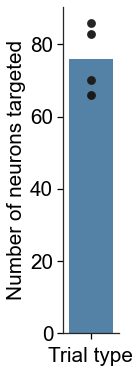

In [209]:
if interneuron:
    df = pd.DataFrame()

    unique_animals = len(cell_df.session_id.unique())

    targets = ['pr_target']

    for target in targets:
        target_df = cell_df.query(target)

        num_targets = target_df.groupby('session_id')[target].count()

        session_labels = [session_id[-5:] for session_id in target_df['session_id'].unique()]

        temp_df = pd.DataFrame({'target_type' : np.repeat(target, len(num_targets)),
                                'num_targets' : num_targets,
                                'session_id' : session_labels
                               })

        df = pd.concat([df, temp_df])

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(1,6))

    sns.barplot(data=df, y='num_targets', x='target_type', ci=None, 
                ax=axes, palette=sns.color_palette(plot_colors), zorder=-1);
    sns.pointplot(data=df, x="target_type", y="num_targets", hue='session_id', color='k', dodge=False)
    axes.legend().set_visible(False)

    axes.set_ylabel('Number of neurons targeted');
    axes.set_xlabel('Trial type')

    ax1_labels = [item.get_text() for item in axes.get_xticklabels()]
    ax1_labels = ['']

    axes.set_xticklabels(ax1_labels)

    # plt.suptitle('Number of neurons targeted \nby photostimulus', fontsize='xx-large', y=1);

    # save the figure
    save_path = fig_save_path + '_target_cell_group_size_mean'
    ia.savePlot(save_path)

N_numbers:
n = 4 animals
n = 305 cells for Random non targets
n = 305 cells for Sham non targets


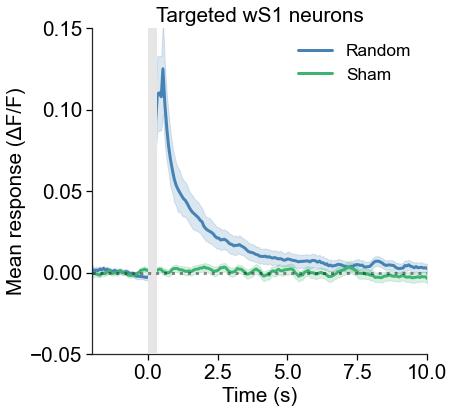

In [222]:
if interneuron:
    target_type = ['pr_target', 'pr_target']
    responses = ['pr_sta_resp', 'spont_sta_resp']

    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, figsize=(6,6))

    n_numbers = []

    n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

    for label, target, response, color in zip(plot_labels, target_type, responses, plot_colors):

        # filter dataframes using variables above
        s1_targets = cell_df[cell_df[target] & cell_df['s1_cell']].index

        # populate the plots with filtered data
        df_filter = cell_mean_timepoint_df['cell_id'].isin(s1_targets)
        filtered_df = cell_mean_timepoint_df[df_filter].copy()
        filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
                    ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
        rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]

        sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
                     estimator='mean', ci=95, ax=ax, label=label, legend=False, color=color, linewidth=plot_lw)

        display(fig)
        clear_output(wait = True)

        n_numbers.append(f'n = {len(s1_targets.unique())} cells for {label} non targets')

    # construct patch to cover stim artifact period
    stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
    ax.add_patch(stim_patch)

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('')

    ax.set_ylabel('Mean response (ΔF/F)', fontname='Arial');
    ax.legend(plot_labels, loc='upper right');

    ax.hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

    ax.set_ylim([-0.05, 0.15])

    ax.set_xlim([-2, 10])

    ax.set_title('Targeted wS1 neurons', fontsize='xx-large', y=1)

    ax.legend().draw_frame(False)

    print('N_numbers:', *n_numbers, sep='\n')

    save_path = fig_save_path + '_cell_grandaverage_target_dff_trace'
    ia.savePlot(save_path)

N_numbers:
n = 4 animals
n = 1573 cells for Random non targets
n = 1573 cells for Sham non targets


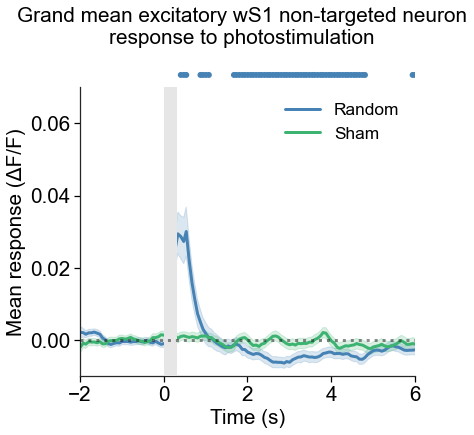

In [211]:
if interneuron:
    target_type = ['pr_target', 'pr_target']
    responses = ['pr_sta_resp', 'spont_sta_resp']

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,6), gridspec_kw={'height_ratios': [2,20]})

    n_numbers = []

    n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

    for label, target, response, color in zip(plot_labels, target_type, responses, plot_colors):

        # filter dataframes using variables above
        nontargets = cell_df[~cell_df[target] & cell_df['s1_cell']].index

        # populate the plots with filtered data
        df_filter = cell_mean_timepoint_df['cell_id'].isin(nontargets)
        filtered_df = cell_mean_timepoint_df[df_filter].copy()
        filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
                    ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
        rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]

        sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
                     estimator='mean', ci=95, ax=ax[1], label=label, legend=False, color=color, linewidth=plot_lw)

        display(fig)
        clear_output(wait = True)

        n_numbers.append(f'n = {len(nontargets.unique())} cells for {label} non targets')

    # construct patch to cover stim artifact period
    stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
    ax[1].add_patch(stim_patch)

    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Mean response (ΔF/F)');
    if sensory:
        ax[1].legend(plot_labels, loc='lower right');
    else:
        ax[1].legend(plot_labels, loc='upper right');

    ax[1].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

    ax[1].set_ylim([-0.01, 0.07])

    ax[1].set_xlim([-2, 6])

    #plot stats
    nontargets = cell_df[(~cell_df['pr_target']) & cell_df['s1_cell']].index
    df_filter = cell_mean_timepoint_df['cell_id'].isin(nontargets)
    temp_df = cell_mean_timepoint_df[df_filter].copy()
    temp_df.loc[(temp_df['timepoint'] > -3) & (temp_df['timepoint'] <= photostim_duration), 
                ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
    time_array = cell_mean_timepoint_df['timepoint'].unique()

    for tt_i, (col_1, col_2, color) in enumerate(zip(['pr_sta_resp'],
                                                     ['spont_sta_resp'],
                                                     [plot_colors[0]])):
        signif_array = ia.stat_test_timepoint(temp_df, time_array, col_1=col_1, col_2=col_2, 
                                           frames_bin=4, th=0.05)
        signif_array[(time_array > -3) & (time_array <= patch_size + 0.05)] = np.nan
        sns.scatterplot(x=time_array, y=[tt_i * 0.02 if x_val==1 else np.nan for x_val in signif_array], 
                        ax=ax[0], color=color, edgecolor='none', lw=0, legend=False)
        clear_output(wait=True)

    ax[0].set_ylim([-0.01, 0.02*3])
    ax[0].axis('off')
    plt.subplots_adjust(hspace=0.05)

    ax[1].legend().draw_frame(False)

    plt.suptitle('Grand mean excitatory wS1 non-targeted neuron\nresponse to photostimulation', fontsize='xx-large', y=0.98)

    print('N_numbers:', *n_numbers, sep='\n')

    save_path = fig_save_path + '_cell_grandaverage_s1nt_dff_trace'
    ia.savePlot(save_path)

N_numbers:
n = 4 animals
n = 98 cells for Random non targets
n = 98 cells for Sham non targets


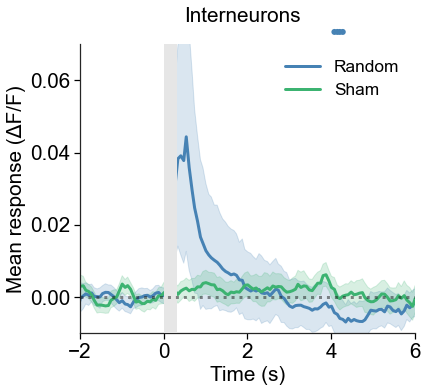

In [226]:
if interneuron:
    target_type = ['pr_target', 'pr_target']
    responses = ['pr_sta_resp', 'spont_sta_resp']

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,6), gridspec_kw={'height_ratios': [2,20]})

    n_numbers = []

    n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

    for label, target, response, color in zip(plot_labels, target_type, responses, plot_colors):

        # filter dataframes using variables above
        interneurons = cell_df[~cell_df[target] & cell_df['int_cell']].index

        # populate the plots with filtered data
        df_filter = cell_mean_timepoint_df['cell_id'].isin(interneurons)
        filtered_df = cell_mean_timepoint_df[df_filter].copy()
        filtered_df.loc[(filtered_df['timepoint'] > 0) & (filtered_df['timepoint'] <= photostim_duration), 
                    ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
        rolling_mean = filtered_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]

        sns.lineplot(data=filtered_df, x='timepoint', y=rolling_mean.to_numpy(), 
                     estimator='mean', ci=95, ax=ax[1], label=label, legend=False, color=color, linewidth=plot_lw)

        display(fig)
        clear_output(wait = True)

        n_numbers.append(f'n = {len(interneurons.unique())} cells for {label} non targets')

    # construct patch to cover stim artifact period
    stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
    ax[1].add_patch(stim_patch)

    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Mean response (ΔF/F)');
    if sensory:
        ax[1].legend(plot_labels, loc='lower right');
    else:
        ax[1].legend(plot_labels, loc='upper right');

    ax[1].hlines(0, -2, 10, linestyles='dotted', zorder=4, alpha=0.5, color='k', lw=3);

    ax[1].set_ylim([-0.01, 0.07])

    ax[1].set_xlim([-2, 6])

    #plot stats
    df_filter = cell_mean_timepoint_df['cell_id'].isin(interneurons)
    temp_df = cell_mean_timepoint_df[df_filter].copy()
    temp_df.loc[(temp_df['timepoint'] > -3) & (temp_df['timepoint'] <= photostim_duration), 
                ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
    time_array = cell_mean_timepoint_df['timepoint'].unique()

    for tt_i, (col_1, col_2, color) in enumerate(zip(['pr_sta_resp'],
                                                     ['spont_sta_resp'],
                                                     [plot_colors[0]])):
        signif_array = ia.stat_test_timepoint(temp_df, time_array, col_1=col_1, col_2=col_2, 
                                           frames_bin=4, th=0.05)
        signif_array[(time_array > -3) & (time_array <= patch_size + 0.05)] = np.nan
        sns.scatterplot(x=time_array, y=[tt_i * 0.02 if x_val==1 else np.nan for x_val in signif_array], 
                        ax=ax[0], color=color, edgecolor='none', lw=0, legend=False)
        clear_output(wait=True)

    ax[0].set_ylim([-0.01, 0.02*3])
    ax[0].axis('off')
    plt.subplots_adjust(hspace=0.05)

    ax[1].legend().draw_frame(False)

    plt.suptitle('Interneurons', fontsize='xx-large', y=0.88)

    print('N_numbers:', *n_numbers, sep='\n')

    save_path = fig_save_path + '_cell_grandaverage_interneuron_dff_trace'
    ia.savePlot(save_path)

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


trial: Random slope 0.3817098344878592 r_value 0.38170983243349915 p_value 2.5355469700243463e-15


/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


trial: Sham slope 0.4954981186374351 r_value 0.4954981155497189 p_value 3.5932926337757294e-26


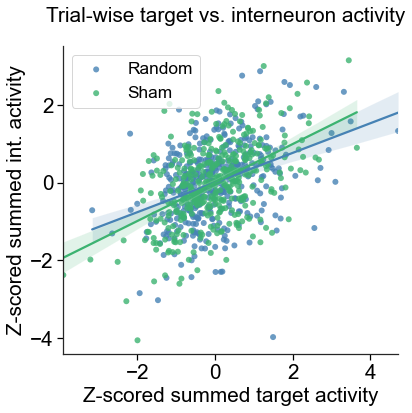

In [213]:
if interneuron:
    responses = ['pr_amp_resp', 'spont_amp_resp']
    targets = ['pr_target', 'pr_target']

    colors = plot_colors[:2]
    colors.append('k')

    # create and populate the plots using filtered data
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(6,6))

    for response, target, label, color in zip(responses, targets, plot_labels, colors):

        int_cell_ids = cell_df.query('int_cell & ~' + target).index
        target_cell_ids = cell_df.query(target).index

        target_filter = cell_trial_df['cell_id'].isin(target_cell_ids)
        target_df = cell_trial_df[target_filter].dropna(axis=0, subset=[response])
        target_amp_resp = target_df.groupby(['trial_num','session_id']).sum()
        target_amp_resp = target_amp_resp.groupby('session_id').transform(lambda x : stats.zscore(x, ddof=1))[response]

        int_filter = cell_trial_df['cell_id'].isin(int_cell_ids)
        int_df = cell_trial_df[int_filter].dropna(axis=0, subset=[response])
        int_amp_resp = int_df.groupby(['trial_num','session_id']).sum()
        int_amp_resp = int_amp_resp.groupby('session_id').transform(lambda x : stats.zscore(x, ddof=1))[response]

        df = pd.DataFrame({'target_amp_resp' : target_amp_resp,
                           'int_amp_resp'     : int_amp_resp})

        df = df.reset_index(drop=False)

        sns.regplot(x=df['target_amp_resp'], y=df['int_amp_resp'], 
                    data=df, ax=axes, label=label, color=color, scatter_kws={'edgecolor':'none'})

        axes.set_ylabel('Z-scored summed int. activity')
        axes.legend()
        axes.set_xlabel('Z-scored summed target activity')

        axes.set_aspect('equal')

        slope, _, r_value, p_value, _ = stats.linregress(x=df['target_amp_resp'], 
                                                         y=df['int_amp_resp'])
        print('trial:', label,
              'slope', slope,
              'r_value', r_value,
              'p_value', p_value
             )

    plt.suptitle('Trial-wise target vs. interneuron activity', y=0.95, 
             fontsize='xx-large');

    # save the figure
    save_path = fig_save_path + '_target_int_activity_correlation_trialwise_zscore'
    ia.savePlot(save_path)

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


trial: Random slope 0.6572864402499777 r_value 0.6572864261318078 p_value 7.834334449958075e-51


/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


trial: Sham slope 0.6900683627993642 r_value 0.6900683676660128 p_value 7.525105181478216e-58


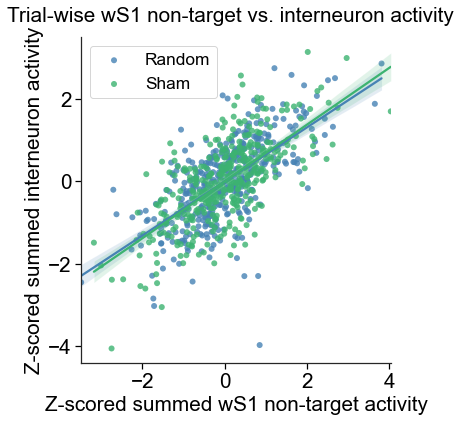

In [214]:
if interneuron:
    responses = ['pr_amp_resp', 'spont_amp_resp']
    targets = ['pr_target', 'pr_target']

    colors = plot_colors[:2]
    colors.append('k')

    # create and populate the plots using filtered data
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(6,6))

    for response, target, label, color in zip(responses, targets, plot_labels, colors):

        int_cell_ids = cell_df.query('int_cell & ~' + target).index
        target_cell_ids = cell_df.query('~' + target).index

        target_filter = cell_trial_df['cell_id'].isin(target_cell_ids)
        target_df = cell_trial_df[target_filter].dropna(axis=0, subset=[response])
        target_amp_resp = target_df.groupby(['trial_num','session_id']).sum()
        target_amp_resp = target_amp_resp.groupby('session_id').transform(lambda x : stats.zscore(x, ddof=1))[response]

        int_filter = cell_trial_df['cell_id'].isin(int_cell_ids)
        int_df = cell_trial_df[int_filter].dropna(axis=0, subset=[response])
        int_amp_resp = int_df.groupby(['trial_num','session_id']).sum()
        int_amp_resp = int_amp_resp.groupby('session_id').transform(lambda x : stats.zscore(x, ddof=1))[response]

        df = pd.DataFrame({'target_amp_resp' : target_amp_resp,
                           'int_amp_resp'     : int_amp_resp})

        df = df.reset_index(drop=False)

        sns.regplot(x=df['target_amp_resp'], y=df['int_amp_resp'], 
                    data=df, ax=axes, label=label, color=color, scatter_kws={'edgecolor':'none'})

        axes.set_ylabel('Z-scored summed interneuron activity')
        axes.legend()
        axes.set_xlabel('Z-scored summed wS1 non-target activity')

        axes.set_aspect('equal')

        slope, _, r_value, p_value, _ = stats.linregress(x=df['target_amp_resp'], 
                                                         y=df['int_amp_resp'])
        print('trial:', label,
              'slope', slope,
              'r_value', r_value,
              'p_value', p_value
             )

    plt.suptitle('Trial-wise wS1 non-target vs. interneuron activity', y=0.95, 
             fontsize='xx-large');

    # save the figure
    save_path = fig_save_path + '_s1nt_int_activity_correlation_trialwise_zscore'
    ia.savePlot(save_path)

In [215]:
if interneuron:
    int_ids = cell_df.query('int_cell & s1_cell & ~pr_target').index
    int_timepoint_filter = cell_trial_single_timepoint_df.cell_id.isin(int_ids)
    int_single_timepoint_df = cell_trial_single_timepoint_df[int_timepoint_filter].copy()

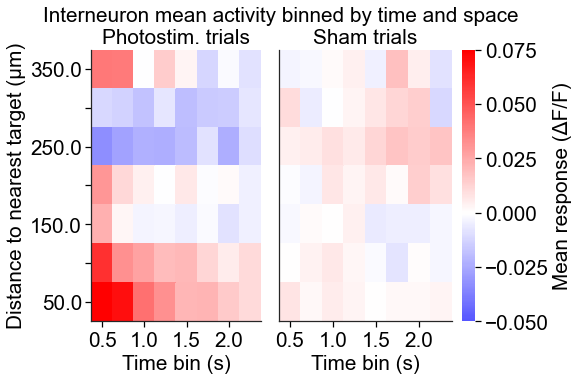

In [216]:
if interneuron:
    time_bins = np.linspace(0.05, 2.05, 9) + photostim_duration
    dists = np.linspace(-25, 375, 9)

    int_df = cell_df.query('int_cell & s1_cell & ~pr_target')

    dist_to_targ = int_df.dist_to_targ
    binned_dist, dist_bins = pd.cut(dist_to_targ, dists, retbins=True)
    binned_dist.sort_index(inplace=True)

    dist_bins = dist_bins[::-1]-(np.diff(dist_bins)[0]/2)

    df = pd.DataFrame(binned_dist)

    fig, axes = plt.subplots(1, 2, figsize=(7,5), gridspec_kw={'width_ratios': (1,1.2)})

    for response, title, ax in zip(['pr_resp', 'spont_resp'], ['Photostim.', 'Sham'], axes):
        for previous_bin, current_bin in zip(time_bins[:-1], time_bins[1:]):

            binned_df = int_single_timepoint_df.query('(timepoint <= @current_bin) & (timepoint > @previous_bin)')
            mean_of_bin = binned_df.groupby('cell_id').mean()

            mean_of_bin = mean_of_bin.loc[:,['pr_resp', 'spont_resp']].copy().sort_index()

            df[f'{current_bin.round(2)}'] = mean_of_bin[response]

        mean_binned_df = df.groupby('dist_to_targ').mean()

        if response == 'pr_resp':
            sns.heatmap(data=mean_binned_df[::-1], yticklabels=dist_bins.round(), vmin=-0.05, vmax=0.075, 
                        center=0, cmap='bwr', cbar=False, square=False, ax=ax)
        else:
            sns.heatmap(data=mean_binned_df[::-1], yticklabels=dist_bins.round(), vmin=-0.05, vmax=0.075, 
                        center=0, cmap='bwr', square=False, ax=ax, 
                        cbar_kws={'fraction' : 0.1, 'label': 'Mean response (ΔF/F)'})

        ax.set_xlabel('Time bin (s)')
        ax.set_ylabel('Distance to nearest target (μm)')
        ax.set_title(f'{title} trials')

    axes[1].set_ylabel('')
    axes[1].get_yaxis().set_visible(False)

    for ax in axes:
        ax_labels = [item.get_text() for item in ax.get_xticklabels()]
    #     ax_labels[1::2] = ['', '', '', '']
        ax.set_xticklabels(ax_labels)

        ax.set_ylim([7,0])
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)

    ax_labels = [item.get_text() for item in axes[0].get_yticklabels()]
    ax_labels[1::2] = ['', '', '', '']
    axes[0].set_yticklabels(ax_labels)

    plt.subplots_adjust(wspace=0.1)
    plt.suptitle('Interneuron mean activity binned by time and space', fontsize='xx-large', y=1);

    save_path = fig_save_path + '_target_int_activity_correlation_dist_to_targ_time_bin_2d'
    ia.savePlot(save_path)

In [217]:
# if interneuron:
#     responses = ['pr', 'spont']
#     targets = ['pr_target', 'pr_target']

#     colors = plot_colors[:2]
#     colors.append('k')

#     # create and populate the plots using filtered data
#     fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,12))

#     for response, target, label, color in zip(responses, targets, plot_labels, colors):

#         int_df = cell_df.query('int_cell & s1_cell & ~' + target)

#         int_resp = int_df[response + '_sta_amp_resp'].values.astype('float')
#         int_dist = int_df.dist_to_targ.values.astype('float')

#         mean_dist, bin_edges, bin_nums = stats.binned_statistic(int_dist, int_dist, statistic=np.nanmean, bins=20, range=(0,750))
#         bin_nums[np.where(bin_nums==21)[0]] = 20

#         count, hist_bins = np.histogram(int_dist, bin_edges)

#         sns.lineplot(x=mean_dist[bin_nums-1], y=int_resp, ax=axes[0], ci=95, label=label, color=color, lw=plot_lw)
#     #     sns.regplot(x=int_dist, y=int_resp, ax=axes, label=label, color=color)

#         axes[0].set_ylabel('Interneuron response (ΔF/F)')
#         axes[0].legend()
#         axes[0].set_xlabel('Distance to nearest target')

#         axes[0].hlines(0, -3, 550, linestyles='dotted', zorder=-1, alpha=0.5, lw=3, color='k');
#         axes[1].set_xlim([0,325])

#         slope, _, r_value, p_value, _ = stats.linregress(x=int_dist, y=int_resp)
#         print('trial:', label,
#               'slope', slope,
#               'r_value', r_value,
#               'p_value', p_value
#              )

#     sns.histplot(x=mean_dist[bin_nums-1], ax=axes[1], color='k')
#     axes[1].set_xlabel('Distance to nearest target (μm)')
#     axes[1].set_ylabel('# cells')

#     plt.subplots_adjust(hspace=0.1)
#     plt.suptitle('Interneuron activity vs. distance to target', y=0.91, 
#              fontsize='xx-large');

#     # save the figure
#     save_path = fig_save_path + '_target_int_activity_correlation_dist_to_targ'
#     ia.savePlot(save_path)

In [218]:
# if interneuron:
#     responses = ['pr', 'spont']
#     targets = ['pr_target', 'pr_target']

#     colors = plot_colors[:2]
#     colors.append('k')

#     # create and populate the plots using filtered data
#     fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,12))

#     for response, target, label, color in zip(responses, targets, plot_labels, colors):

#         int_df = cell_df.query('int_cell & s1_cell & ~' + target)

#         int_resp = int_df[response + '_sta_amp_resp'].values.astype('float')
#         int_dist = int_df.dist_to_resp_targ.values.astype('float')

#         mean_dist, bin_edges, bin_nums = stats.binned_statistic(int_dist, int_dist, statistic=np.nanmean, bins=20, range=(0,750))
#         bin_nums[np.where(bin_nums==21)[0]] = 20

#         count, hist_bins = np.histogram(int_dist, bin_edges)

#         sns.lineplot(x=mean_dist[bin_nums-1], y=int_resp, ax=axes[0], ci=95, label=label, color=color, lw=plot_lw)
#     #     sns.regplot(x=int_dist, y=int_resp, ax=axes, label=label, color=color)

#         axes[0].set_ylabel('Interneuron response (ΔF/F)')
#         axes[0].legend()
#         axes[0].set_xlabel('Distance to nearest target')

#         axes[0].hlines(0, -3, 550, linestyles='dotted', zorder=-1, alpha=0.5, lw=3, color='k');
#         axes[1].set_xlim([0,325])

#         slope, _, r_value, p_value, _ = stats.linregress(x=int_dist, y=int_resp)
#         print('trial:', label,
#               'slope', slope,
#               'r_value', r_value,
#               'p_value', p_value
#              )

#     sns.histplot(x=mean_dist[bin_nums-1], ax=axes[1], color='k')
#     axes[1].set_xlabel('Distance to nearest responsive target (μm)')
#     axes[1].set_ylabel('# cells')

#     plt.subplots_adjust(hspace=0.1)
#     plt.suptitle('Interneuron activity vs. distance to \nresponsive target', y=0.93, 
#              fontsize='xx-large');

#     # save the figure
#     save_path = fig_save_path + '_target_int_activity_correlation_dist_to_resp_targ'
#     ia.savePlot(save_path)

N_numbers:
n = 97 cells for Random non-targets
n = 97 cells for Sham non-targets
n = 4 animals


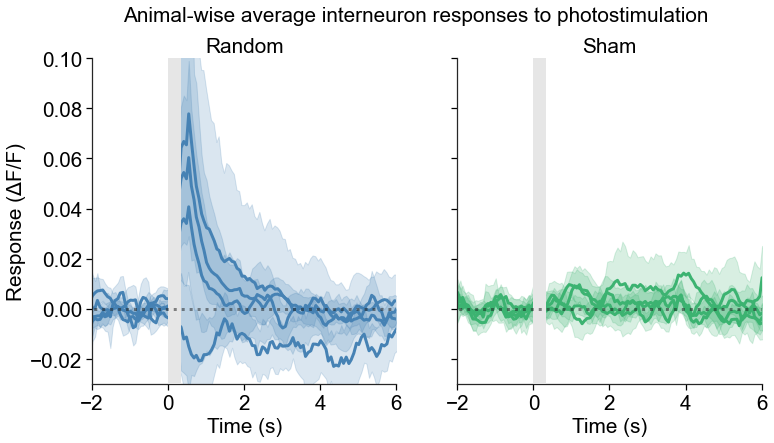

In [219]:
if interneuron:
    # list of column names to be used to filter the dataframe
    target_type = ['pr_target', 'pr_target']
    responses = ['pr_sta_resp', 'spont_sta_resp']

    n_numbers = []

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(12,6))

    for target, response, color, label, ax in zip(target_type, responses, plot_colors, plot_labels, axes):

        # filter dataframes using variables above
        interneurons = cell_df[~cell_df[target] & cell_df['int_cell'] & cell_df['s1_cell']].index

        df_filter = cell_mean_timepoint_df['cell_id'].isin(interneurons)
        filtered_df = cell_mean_timepoint_df[df_filter]

        for session_id in filtered_df.session_id.unique():
            animal_df = filtered_df.loc[filtered_df.session_id == session_id].copy()
            animal_df.loc[(animal_df['timepoint'] > 0) & (animal_df['timepoint'] <= photostim_duration), 
                    ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
            rolling_mean = animal_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]

            sns.lineplot(data=animal_df, x='timepoint', y=rolling_mean.to_numpy(), 
                         estimator='mean', ci=95, ax=ax, color=color, linewidth=plot_lw)

        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Response (ΔF/F)')
        ax.set_title(label)
        ax.hlines(0, -3, 11, linestyles='dotted', zorder=4, alpha=0.5, lw=3, color='k');
    #     ax.set_ylim([-0.03, 0.2])
        ax.set_ylim([-0.03, 0.1])
        ax.set_xlim([-2,6])

        # construct patch to cover stim artifact period
        stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
        ax.add_patch(stim_patch)

        target_text = ['targets', 'non targets']
        n_numbers.append(f'n = {len(interneurons.unique())} cells for {label} non-targets')

        display(fig)
        clear_output(wait = True)

    for ax in axes[1:3]:
        ax.set_ylabel('')

    plt.suptitle('Animal-wise average interneuron responses to photostimulation', fontsize='xx-large', y=1)
    save_path = fig_save_path + '_cell_grandaverage_dff_trace_animalwise'
    ia.savePlot(save_path)

    n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

    print('N_numbers:', *n_numbers, sep='\n')

N_numbers:
n = 1573 cells for Random non-targets
n = 1573 cells for Sham non-targets
n = 4 animals


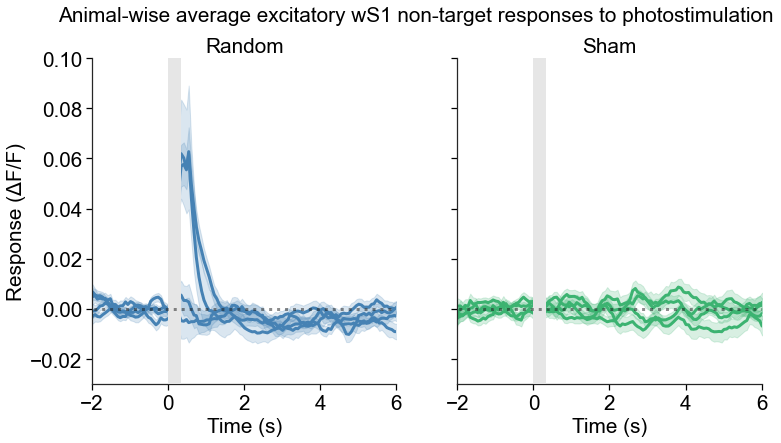

In [220]:
if interneuron:
    # list of column names to be used to filter the dataframe
    target_type = ['pr_target', 'pr_target']
    responses = ['pr_sta_resp', 'spont_sta_resp']

    n_numbers = []

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(12,6))

    for target, response, color, label, ax in zip(target_type, responses, plot_colors, plot_labels, axes):

        # filter dataframes using variables above
        interneurons = cell_df[~cell_df[target] & cell_df['s1_cell']].index

        df_filter = cell_mean_timepoint_df['cell_id'].isin(interneurons)
        filtered_df = cell_mean_timepoint_df[df_filter]

        for session_id in filtered_df.session_id.unique():
            animal_df = filtered_df.loc[filtered_df.session_id == session_id].copy()
            animal_df.loc[(animal_df['timepoint'] > 0) & (animal_df['timepoint'] <= photostim_duration), 
                    ['pr_sta_resp', 'ps_sta_resp', 'spont_sta_resp']] = np.nan # make photostim period NaN
            rolling_mean = animal_df.groupby('cell_id').rolling(5, min_periods=1).mean()[response]

            sns.lineplot(data=animal_df, x='timepoint', y=rolling_mean.to_numpy(), 
                         estimator='mean', ci=95, ax=ax, color=color, linewidth=plot_lw)

        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Response (ΔF/F)')
        ax.set_title(label)
        ax.hlines(0, -3, 11, linestyles='dotted', zorder=4, alpha=0.5, lw=3, color='k');
    #     ax.set_ylim([-0.03, 0.2])
        ax.set_ylim([-0.03, 0.1])
        ax.set_xlim([-2,6])

        # construct patch to cover stim artifact period
        stim_patch = patches.Rectangle((0,-100), patch_size, 999, zorder=3, color=patch_color)
        ax.add_patch(stim_patch)

        target_text = ['targets', 'non targets']
        n_numbers.append(f'n = {len(interneurons.unique())} cells for {label} non-targets')

        display(fig)
        clear_output(wait = True)

    for ax in axes[1:3]:
        ax.set_ylabel('')

    plt.suptitle('Animal-wise average excitatory wS1 non-target responses to photostimulation', fontsize='xx-large', y=1)
    save_path = fig_save_path + '_cell_grandaverage_s1nt_dff_trace_animalwise'
    ia.savePlot(save_path)

    n_numbers.append(f'n = {len(cell_df["session_id"].unique())} animals')

    print('N_numbers:', *n_numbers, sep='\n')